# 📋 ÍNDICE - TRILHA 03 (deepveg-gee360)

## 🔧 Setup e Configuração
- **Célula 0**: Instalação e Setup (GEE)
- **Célula 0B**: Autenticação GEE e Montagem do Drive
- **Célula 1A**: Configurações Globais (CONFIG HUB) ⭐
- **Célula 1B**: Geração de Pontos Amostrais (120 pts/bioma)

## 📥 Download de Dados
- **Célula 2**: Validação GEE (1 ponto/1 mês)
- **Célula 3**: Download NDVI/EVI via GEE (MOD13Q1)
- **Célula 4**: Download Precipitação via GEE (CHIRPS)

## 🔄 Processamento
- **Célula 5**: Agregação 16 dias → Mensal (MODIS)
- **Célula 6**: Merge MODIS + CHIRPS
- **Célula 7**: QA Visual

## 🧪 Feature Engineering
- **Célula 8**: Feature Engineering (anomalias, extremos, mês cíclico)
- **Célula 9**: Criação de Sequências Temporais
- **Célula 10**: Baselines

## 🤖 Modelagem TCN
- **Célula 10.B**: Helpers e Configurações Globais (TCNBlock, FocalLoss)
- **Célula 11**: TCN Regressão (PyTorch)
- **Célula 12**: TCN Classificação com Limiar Calibrado (PyTorch)
- **Célula 13**: LOBO - Leave-One-Biome-Out (PyTorch)

## 📊 Resultados e Visualização
- **Célula 14**: Métricas e Figuras Finais
- **Célula 15**: Composições Sentinel-2

---

## ⚙️ Configurações Rápidas (Célula 1A)

| Parâmetro | Valor | Descrição |
|-----------|-------|-----------|
| `N_POINTS_PER_BIOME` | 120 | Pontos por bioma |
| `MIN_DISTANCE_KM` | 50 | Distância mínima (Poisson-disk) |
| `EPOCHS` | 300 | Máximo de épocas |
| `BATCH_SIZE` | 128 | Tamanho do batch |
| `PATIENCE` | 20 | Early stopping |

---

# 1. SETUP E CONFIGURAÇÃO (GEE)






## 1.0. Instalações e imports

In [2]:
# Célula 1.0: Instalações e imports
"""
CELULA 0: INSTALACAO DE DEPENDENCIAS PARA GEE
Execute apenas UMA VEZ por sessao nova.
"""
# Instalar geedim
!pip install -q geedim

import subprocess
import sys

try:
    import ee
    import geemap
    print("Dependencias ja instaladas.  Pode pular para Celula 0B.")
except ImportError:
    print("Instalando pacotes...")
    subprocess.run([sys.executable, "-m", "pip", "-q", "install", "earthengine-api"], check=True)
    subprocess.run([sys.executable, "-m", "pip", "-q", "install", "geemap"], check=True)
    subprocess.run([sys.executable, "-m", "pip", "-q", "install", "pyarrow"], check=True)

    print("")
    print("=" * 60)
    print("INSTALACAO CONCLUIDA")
    print("Reinicie o runtime: Menu -> Runtime -> Restart runtime")
    print("Depois execute a Celula 0B.")
    print("=" * 60)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 8.4 MB/s eta 0:00:00
Dependencias ja instaladas.  Pode pular para Celula 0B.


## 1.1. Autenticação GEE e Montagem do Drive

In [3]:
# Célula 1.1: Autenticação GEE e Montagem do Drive
"""
CELULA 1.1: AUTENTICACAO GEE E CONFIGURACAO - TRILHA 03
Execute SEMPRE que iniciar ou reconectar a sessao.
"""

import os
import ee
from google.colab import drive

# ---------------------------------------------------------------------------
# 1.MONTAGEM DO GOOGLE DRIVE
# ---------------------------------------------------------------------------
DRIVE_MOUNT = '/content/drive'
if not os.path.ismount(DRIVE_MOUNT):
    print("Montando Google Drive...")
    drive.mount(DRIVE_MOUNT)
else:
    print("Drive ja montado.")

# ---------------------------------------------------------------------------
# 2.ESTRUTURA DE DIRETORIOS (TRILHA 03 - 360 pontos)
# ---------------------------------------------------------------------------
BASE = "/content/drive/MyDrive/deepveg-gee360"  # <- TRILHA 03

DIRETORIOS = [
    "data/raw",
    "data/interim",
    "data/processed",
    "data/sampling_checkpoints",
    "outputs/figures",
    "outputs/figures/lobo_pr_curves",
    "outputs/figures/s2_composites",
    "outputs/metrics",
    "outputs/checkpoints",
]

for diretorio in DIRETORIOS:
    os.makedirs(f"{BASE}/{diretorio}", exist_ok=True)

print(f"Diretorio base: {BASE}")
print(f"Trilha: 03 (360 pontos)")

# ---------------------------------------------------------------------------
# 3.AUTENTICACAO GOOGLE EARTH ENGINE
# ---------------------------------------------------------------------------
print("\nAutenticando no Google Earth Engine...")

GEE_PROJECT = "deepveg-gee"  # PROJECT ID

try:
    ee.Initialize(project=GEE_PROJECT)
    print(f"GEE ja autenticado com projeto: {GEE_PROJECT}")
except Exception as e:
    print(f"Erro inicial: {e}")
    print("\nIniciando autenticacao interativa...")
    ee.Authenticate()
    ee.Initialize(project=GEE_PROJECT)
    print(f"GEE autenticado com sucesso!  Projeto: {GEE_PROJECT}")

print("\n" + "=" * 60)
print("SETUP GEE CONCLUIDO - TRILHA 03 (360 pontos)")
print("=" * 60)

Montando Google Drive...
Mounted at /content/drive
Diretorio base: /content/drive/MyDrive/deepveg-gee360
Trilha: 03 (360 pontos)

Autenticando no Google Earth Engine...
Erro inicial: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.

Iniciando autenticacao interativa...
GEE autenticado com sucesso!  Projeto: deepveg-gee

SETUP GEE CONCLUIDO - TRILHA 03 (360 pontos)


## 1.2. Configurações Globais (CONFIG HUB)

In [19]:
# Célula 1.2: Configurações Globais (CONFIG HUB)
"""
CELULA 1A: CONFIGURACOES GLOBAIS - CONFIG HUB
==============================================
TODAS as configuracoes do pipeline estao centralizadas aqui.
Modifique APENAS esta celula para ajustar o experimento.

Secoes:
  1.AMBIENTE - Paths, seeds, device
  2.DATASET - Pontos, biomas, periodo, amostragem
  3.FEATURES - Variaveis de entrada e targets
  4.MODELO - Arquitetura TCN, hiperparametros
  5.TREINO - Epochs, batch size, early stopping, otimizador
  6.AVALIACAO - Metricas, thresholds, LOBO

Apos modificar, execute esta celula e todas as seguintes.
"""

from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
import os
import torch
import numpy as np

# ===========================================================================
# 1.AMBIENTE
# ===========================================================================
@dataclass
class AmbienteConfig:
    """Configuracoes de ambiente e paths."""

    # Path base no Google Drive
    BASE: str = "/content/drive/MyDrive/deepveg-gee360"

    # Seed para reproducibilidade
    SEED: int = 42

    # Device (auto-detectado)
    DEVICE: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")

    # Subpastas (geradas automaticamente)
    @property
    def PATHS(self) -> Dict[str, str]:
        return {
            # Data
            "data": f"{self.BASE}/data",
            "raw": f"{self.BASE}/data/raw",
            "interim": f"{self.BASE}/data/interim",
            "sampling_checkpoints": f"{self.BASE}/data/sampling_checkpoints",

            # Raw files
            "raw_modis": f"{self.BASE}/data/raw/modis_gee_points.parquet",
            "raw_chirps": f"{self.BASE}/data/raw/chirps_gee_points.parquet",

            # Interim files
            "interim_monthly": f"{self.BASE}/data/interim/modis_monthly.parquet",
            "interim_chirps": f"{self.BASE}/data/interim/chirps_monthly.parquet",
            "interim_merge": f"{self.BASE}/data/interim/merged_monthly.parquet",

            # Outputs
            "outputs": f"{self.BASE}/outputs",
            "checkpoints": f"{self.BASE}/outputs/checkpoints",
            "metrics": f"{self.BASE}/outputs/metrics",
            "figures": f"{self.BASE}/outputs/figures",

            # Sampling
            "sampling_csv": f"{self.BASE}/data/sampling_points_360.csv",

            # Figures (QA)
            "fig_qa_evi": f"{self.BASE}/outputs/figures/qa_evi_mensal_bioma.png",

            # Checkpoints do modelo
            "scaler_pkl": f"{self.BASE}/outputs/checkpoints/scaler.pkl",
            "tcn_reg_ckpt": f"{self.BASE}/outputs/checkpoints/tcn_reg_best.pt",
            "tcn_cls_ckpt": f"{self.BASE}/outputs/checkpoints/tcn_cls_best.pt",
        }

    def create_dirs(self):
        """Cria todas as pastas necessarias."""
        # Lista de extensões de arquivos (não são pastas)
        file_extensions = ('.parquet', '.csv', '.json', '.pt', '.png', '.pkl')

        for key, path in self.PATHS.items():
            # Só cria diretório se NÃO for arquivo
            if not path.endswith(file_extensions):
                os.makedirs(path, exist_ok=True)


# ===========================================================================
# 2. DATASET
# ===========================================================================
@dataclass
class DatasetConfig:
    """Configuracoes do dataset e amostragem."""

    # ----- ESCALA DO DATASET -----
    N_POINTS_PER_BIOME: int = 120          # Pontos por bioma
    BIOMES: List[str] = field(default_factory=lambda: ["Amazônia", "Cerrado", "Mata Atlântica"])

    @property
    def N_TOTAL_POINTS(self) -> int:
        return self.N_POINTS_PER_BIOME * len(self.BIOMES)

    # ----- PERIODO TEMPORAL -----
    START_DATE: str = "2019-01-01"
    END_DATE: str = "2024-12-31"

    # Split temporal
    WARMUP_END: str = "2020-12-31"         # Warm-up: 2019-2020 (histórico para SEQ_LEN=24)
    TRAIN_END: str = "2022-12-31"          # Treino: 2019-2022
    VAL_END: str = "2023-12-31"            # Val: 2023
    # Teste: 2024

    # ----- AMOSTRAGEM ESPACIAL -----
    MIN_DISTANCE_KM: float = 50.0          # Distancia minima entre pontos (Poisson-disk)
    GRID_RESOLUTION_DEG: float = 0.1       # Resolucao do grid de candidatos (~11km)
    STABILITY_THRESHOLD: float = 0.80      # % minimo de anos como vegetacao nativa
    STABILITY_YEARS: List[int] = field(default_factory=lambda: [2019, 2020, 2021, 2022, 2023])
    WATER_BUFFER_M: int = 5000             # Buffer de exclusao de agua (metros)
    URBAN_BUFFER_M: int = 10000            # Buffer de exclusao urbano (metros)
    N_STRATA: int = 10                     # Numero de estratos de precipitacao (decis)

    # ----- GEE ASSETS -----
    GEE_ASSETS: Dict[str, str] = field(default_factory=lambda: {
        "modis": "MODIS/061/MOD13Q1",
        "chirps": "UCSB-CHG/CHIRPS/DAILY",
        "sentinel": "COPERNICUS/S2_SR_HARMONIZED",
        "biomes": "projects/mapbiomas-workspace/AUXILIAR/biomas-2019",
        "mapbiomas": "projects/mapbiomas-public/assets/brazil/lulc/collection8/mapbiomas_collection80_integration_v1",
        "water": "JRC/GSW1_4/GlobalSurfaceWater",
    })

    # ----- MODIS -----
    MODIS_BANDS: List[str] = field(default_factory=lambda: ["NDVI", "EVI"])
    MODIS_SCALE_FACTOR: float = 0.0001

    # ----- DOWNLOAD -----
    DOWNLOAD_BATCH_SIZE: int = 50          # Pontos por batch no download GEE
    DOWNLOAD_MAX_RETRIES: int = 3          # Tentativas em caso de erro
    DOWNLOAD_RETRY_DELAY: int = 5          # Segundos entre tentativas


# ===========================================================================
# 3. FEATURES
# ===========================================================================
@dataclass
class FeaturesConfig:
    """Configuracoes de features e targets."""

    # ----- FEATURES DE ENTRADA -----
    FEATURES: List[str] = field(default_factory=lambda: [
        "evi",           # EVI (variavel principal)
        "ndvi",          # NDVI
        "precip_month",  # Precipitacao mensal
        "m_sin",         # Componente seno do mes (sazonalidade)
        "m_cos",         # Componente cosseno do mes (sazonalidade)
    ])

    # ----- SEQUENCE LENGTH -----
    SEQ_LEN: int = 12                      # Janela temporal (meses)

    # ----- TARGETS -----
    TARGET_REG: str = "evi_anom"           # Target de regressao (anomalia EVI)
    TARGET_CLS: str = "extreme"            # Target de classificacao (evento extremo)

    # ----- DEFINICAO DE EXTREMO -----
    EXTREME_PERCENTILE: int = 10           # Percentil para definir extremo (p10 = seca)
    EXTREME_BY_BIOME: bool = True          # Calcular percentil por bioma (True) ou global (False)

    # ----- NORMALIZACAO -----
    NORMALIZATION: str = "zscore"          # Tipo: "zscore", "minmax", "robust"


# ===========================================================================
# 4. MODELO
# ===========================================================================
@dataclass
class ModelConfig:
    """Configuracoes da arquitetura do modelo TCN."""

    # ----- ARQUITETURA TCN -----
    NUM_CHANNELS: int = 32                 # Canais por bloco TCN
    KERNEL_SIZE: int = 3                   # Tamanho do kernel convolucional
    DILATIONS: List[int] = field(default_factory=lambda: [1, 2, 4, 8])  # Dilatacoes
    DROPOUT: float = 0.1                   # Taxa de dropout

    # ----- PROPRIEDADES DERIVADAS -----
    @property
    def N_BLOCKS(self) -> int:
        """Numero de blocos TCN."""
        return len(self.DILATIONS)

    @property
    def RECEPTIVE_FIELD(self) -> int:
        """Campo receptivo em timesteps."""
        return 1 + sum([(self.KERNEL_SIZE - 1) * d for d in self.DILATIONS])

    @property
    def CONVS_PER_BLOCK(self) -> int:
        """Convolucoes por bloco (fixo em 2 para TCN padrao)."""
        return 2


# ===========================================================================
# 5. TREINO
# ===========================================================================
@dataclass
class TrainConfig:
    """Configuracoes de treinamento."""

    # ----- GERAL -----
    EPOCHS: int = 200                      # Maximo de epocas
    BATCH_SIZE: int = 64                   # Tamanho do batch

    # ----- EARLY STOPPING -----
    PATIENCE: int = 15                     # Epocas sem melhora antes de parar
    MIN_DELTA: float = 1e-4                # Melhora minima para considerar progresso

    # ----- OTIMIZADOR -----
    OPTIMIZER: str = "adam"                # Otimizador: "adam", "adamw", "sgd"
    LEARNING_RATE: float = 1e-3            # Taxa de aprendizado inicial
    WEIGHT_DECAY: float = 1e-5             # Regularizacao L2

    # ----- SCHEDULER -----
    USE_SCHEDULER: bool = True             # Usar LR scheduler
    SCHEDULER_FACTOR: float = 0.5          # Fator de reducao do LR
    SCHEDULER_PATIENCE: int = 7            # Epocas sem melhora para reduzir LR

    # ----- GRADIENT CLIPPING -----
    GRADIENT_CLIP: float = 1.0             # Max norm do gradiente (0 = desativado)

    # ----- CLASSIFICACAO -----
    CLS_LOSS: str = "focal"                # Loss: "bce", "focal", "weighted_bce"
    FOCAL_ALPHA: float = 0.25              # Alpha do Focal Loss
    FOCAL_GAMMA: float = 2.0               # Gamma do Focal Loss
    USE_CLASS_WEIGHTS: bool = True         # Usar weighted sampler

    # ----- REGRESSAO -----
    REG_LOSS: str = "mse"                  # Loss: "mse", "mae", "huber"


# ===========================================================================
# 6. AVALIACAO
# ===========================================================================
@dataclass
class EvalConfig:
    """Configuracoes de avaliacao."""

    # ----- METRICAS -----
    METRICS_REG: List[str] = field(default_factory=lambda: ["MAE", "RMSE", "CORR"])
    METRICS_CLS: List[str] = field(default_factory=lambda: ["Precision", "Recall", "F1", "PR_AUC"])

    # ----- THRESHOLD -----
    THRESHOLD_METHOD: str = "max_f1"       # Metodo: "max_f1", "fixed", "precision_at_recall"
    FIXED_THRESHOLD: float = 0.5           # Threshold fixo (se method="fixed")
    TARGET_RECALL: float = 0.7             # Recall alvo (se method="precision_at_recall")

    # ----- LOBO -----
    RUN_LOBO: bool = True                  # Executar Leave-One-Biome-Out

    # ----- BASELINE -----
    RUN_BASELINE: bool = True              # Executar baseline linear para comparacao

    # ----- BOOTSTRAP -----
    RUN_BOOTSTRAP: bool = True             # Executar bootstrap para intervalos de confiança
    N_BOOTSTRAP: int = 1000                # Número de iterações bootstrap
    BOOTSTRAP_CI: float = 0.95             # Intervalo de confiança (95%)

# ===========================================================================
# CONFIGURACAO GLOBAL (INSTANCIAS)
# ===========================================================================
# Criar instancias de todas as configuracoes
ENV = AmbienteConfig()
DATA = DatasetConfig()
FEAT = FeaturesConfig()
MODEL = ModelConfig()
TRAIN = TrainConfig()
EVAL = EvalConfig()

# Criar diretorios
ENV.create_dirs()

# ===========================================================================
# RESUMO DA CONFIGURACAO
# ===========================================================================
def print_config_summary():
    """Imprime resumo de todas as configuracoes."""

    print("=" * 70)
    print("CONFIGURACAO DO EXPERIMENTO - TRILHA 03")
    print("=" * 70)

    print("\n[AMBIENTE]")
    print(f"  BASE: {ENV.BASE}")
    print(f"  DEVICE: {ENV.DEVICE}")
    print(f"  SEED: {ENV.SEED}")

    print("\n[DATASET]")
    print(f"  Pontos por bioma: {DATA.N_POINTS_PER_BIOME}")
    print(f"  Biomas: {DATA.BIOMES}")
    print(f"  Total de pontos: {DATA.N_TOTAL_POINTS}")
    print(f"  Periodo: {DATA.START_DATE} a {DATA.END_DATE}")
    print(f"  Distancia minima: {DATA.MIN_DISTANCE_KM} km")
    print(f"  Estabilidade: >= {DATA.STABILITY_THRESHOLD*100:.0f}%")

    print("\n[FEATURES]")
    print(f"  Features: {FEAT.FEATURES}")
    print(f"  Seq len: {FEAT.SEQ_LEN}")
    print(f"  Target reg: {FEAT.TARGET_REG}")
    print(f"  Target cls: {FEAT.TARGET_CLS}")
    print(f"  Extremo: p{FEAT.EXTREME_PERCENTILE} {'por bioma' if FEAT.EXTREME_BY_BIOME else 'global'}")

    print("\n[MODELO TCN]")
    print(f"  Canais: {MODEL.NUM_CHANNELS}")
    print(f"  Blocos: {MODEL.N_BLOCKS}")
    print(f"  Dilatacoes: {MODEL.DILATIONS}")
    print(f"  Kernel: {MODEL.KERNEL_SIZE}")
    print(f"  Dropout: {MODEL.DROPOUT}")
    print(f"  Campo receptivo: {MODEL.RECEPTIVE_FIELD} timesteps")

    print("\n[TREINO]")
    print(f"  Epochs: {TRAIN.EPOCHS}")
    print(f"  Batch size: {TRAIN.BATCH_SIZE}")
    print(f"  Patience: {TRAIN.PATIENCE}")
    print(f"  Optimizer: {TRAIN.OPTIMIZER} (lr={TRAIN.LEARNING_RATE})")
    print(f"  Loss cls: {TRAIN.CLS_LOSS}")
    print(f"  Loss reg: {TRAIN.REG_LOSS}")

    print("\n[AVALIACAO]")
    print(f"  Threshold: {EVAL.THRESHOLD_METHOD}")
    print(f"  LOBO: {'Sim' if EVAL.RUN_LOBO else 'Nao'}")
    print(f"  Baseline: {'Sim' if EVAL.RUN_BASELINE else 'Nao'}")

    # Estimativas
    meses = 72  # 6 anos
    amostras_est = DATA.N_TOTAL_POINTS * (meses - FEAT.SEQ_LEN)
    print("\n[ESTIMATIVAS]")
    print(f"  Amostras totais: ~{amostras_est:,}")
    print(f"  Amostras treino: ~{int(amostras_est * 0.67):,}")
    print(f"  Amostras val: ~{int(amostras_est * 0.17):,}")
    print(f"  Amostras teste: ~{int(amostras_est * 0.17):,}")

    print("\n" + "=" * 70)
    print("Para modificar, edite os valores acima e re-execute esta celula.")
    print("=" * 70)

# Imprimir resumo
print_config_summary()

# ===========================================================================
# VARIAVEIS LEGADAS (compatibilidade com celulas existentes)
# ===========================================================================
# Estas variaveis mantem compatibilidade com o codigo existente
BASE = ENV.BASE
PATHS = ENV.PATHS
SEED = ENV.SEED
device = torch.device(ENV.DEVICE)

FEATURES = FEAT.FEATURES
SEQ_LEN = FEAT.SEQ_LEN

BATCH_SIZE = TRAIN.BATCH_SIZE
EPOCHS = TRAIN.EPOCHS
PATIENCE = TRAIN.PATIENCE

# CFG para compatibilidade com células de download (2, 3, 4)
CFG = {
    "start": DATA.START_DATE,
    "end": DATA.END_DATE,
    "gee": {
        "modis_collection": DATA.GEE_ASSETS["modis"],
        "chirps_collection": DATA.GEE_ASSETS["chirps"],
        "sentinel_collection": DATA.GEE_ASSETS["sentinel"],
        "modis_bands": DATA.MODIS_BANDS,
        "modis_scale_factor": DATA.MODIS_SCALE_FACTOR,
    }
}

# Configurar seeds
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("\nConfiguracoes carregadas e variaveis legadas criadas.")
print(f"Device: {device}")

CONFIGURACAO DO EXPERIMENTO - TRILHA 03

[AMBIENTE]
  BASE: /content/drive/MyDrive/deepveg-gee360
  DEVICE: cuda
  SEED: 42

[DATASET]
  Pontos por bioma: 120
  Biomas: ['Amazônia', 'Cerrado', 'Mata Atlântica']
  Total de pontos: 360
  Periodo: 2019-01-01 a 2024-12-31
  Distancia minima: 50.0 km
  Estabilidade: >= 80%

[FEATURES]
  Features: ['evi', 'ndvi', 'precip_month', 'm_sin', 'm_cos']
  Seq len: 12
  Target reg: evi_anom
  Target cls: extreme
  Extremo: p10 por bioma

[MODELO TCN]
  Canais: 32
  Blocos: 4
  Dilatacoes: [1, 2, 4, 8]
  Kernel: 3
  Dropout: 0.1
  Campo receptivo: 31 timesteps

[TREINO]
  Epochs: 200
  Batch size: 64
  Patience: 15
  Optimizer: adam (lr=0.001)
  Loss cls: focal
  Loss reg: mse

[AVALIACAO]
  Threshold: max_f1
  LOBO: Sim
  Baseline: Sim

[ESTIMATIVAS]
  Amostras totais: ~21,600
  Amostras treino: ~14,472
  Amostras val: ~3,672
  Amostras teste: ~3,672

Para modificar, edite os valores acima e re-execute esta celula.

Configuracoes carregadas e variav

## 1.3. Geração de Pontos Amostrais (GEE)

In [5]:
# ===========================================================================
# CÉLULA 1.3: GERAÇÃO DE PONTOS AMOSTRAIS
# ===========================================================================
# Célula 1.3: Geração de Pontos Amostrais (Poisson-disk + Filtros)
"""
CELULA 1.3: GERACAO DE PONTOS AMOSTRAIS

Pipeline:
1. Gera grid de candidatos por bioma
2. Filtra por vegetacao nativa (MapBiomas)
3.Verifica estabilidade temporal
4.Atribui estratos de precipitacao
5.Aplica Poisson-disk para distancia minima
6.Salva CSV consolidado

Checkpoints salvos para retomada em caso de erro.
"""

import os
import time
import json
import numpy as np
import pandas as pd
import ee

# ---------------------------------------------------------------------------
# VERIFICAR SE JÁ EXISTE CSV FINAL
# ---------------------------------------------------------------------------
SAMPLING_CSV = PATHS["sampling_csv"]

if os.path.exists(SAMPLING_CSV):
    print(f"Arquivo de pontos encontrado: {SAMPLING_CSV}")
    print("Carregando pontos do cache...")
    df_points = pd.read_csv(SAMPLING_CSV)
    POINTS = df_points[['biome', 'name', 'lat', 'lon']].to_dict('records')
    print(f"Carregados {len(POINTS)} pontos de {len(df_points['biome'].unique())} biomas.")
    print(f"\nDistribuicao:")
    print(df_points.groupby('biome').size())
else:
    print("=" * 70)
    print("GERACAO DE PONTOS AMOSTRAIS - TRILHA 03")
    print("=" * 70)
    print(f"  Pontos por bioma: {DATA.N_POINTS_PER_BIOME}")
    print(f"  Total esperado: {DATA.N_TOTAL_POINTS}")
    print(f"  Distancia minima: {DATA.MIN_DISTANCE_KM} km")
    print(f"  Estabilidade: >= {DATA.STABILITY_THRESHOLD*100:.0f}%")
    print(f"  Anos verificados: {DATA.STABILITY_YEARS}")
    print(f"  Biomas: {DATA.BIOMES}")
    print("=" * 70)

    # ---------------------------------------------------------------------------
    # CONFIGURAÇÕES
    # ---------------------------------------------------------------------------
    CHECKPOINT_DIR = PATHS["sampling_checkpoints"]
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    MAPBIOMAS_ASSET = DATA.GEE_ASSETS["mapbiomas"]
    BIOMES_ASSET = DATA.GEE_ASSETS["biomes"]
    CHIRPS_ASSET = DATA.GEE_ASSETS["chirps"]

    # Classes de vegetação nativa MapBiomas Collection 8
    # https://brasil.mapbiomas.org/codigos-de-legenda/
    NATIVE_CLASSES = [
        3,   # Formação Florestal
        4,   # Formação Savânica
        5,   # Mangue
        6,   # Floresta Alagável
        11,  # Campo Alagado e Área Pantanosa
        12,  # Formação Campestre
        32,  # Apicum
        29,  # Afloramento Rochoso
        50,  # Restinga Arborizada
        49,  # Restinga Herbácea
    ]

    BIOME_NAMES_MAP = {
        "Amazônia": "Amazônia",
        "Cerrado": "Cerrado",
        "Mata Atlântica": "Mata Atlântica"
    }

    BIOME_SHORT = {
        "Amazônia": "AMZ",
        "Cerrado": "CER",
        "Mata Atlântica": "MAT"
    }

    # ---------------------------------------------------------------------------
    # FUNÇÕES AUXILIARES
    # ---------------------------------------------------------------------------
    def save_checkpoint(df, biome_short, stage):
        """Salva checkpoint para retomada."""
        path = f"{CHECKPOINT_DIR}/{biome_short}_{stage}.parquet"
        df.to_parquet(path, index=False)
        print(f"    Checkpoint salvo: {stage}")

    def load_checkpoint(biome_short, stage):
        """Carrega checkpoint se existir."""
        path = f"{CHECKPOINT_DIR}/{biome_short}_{stage}.parquet"
        if os.path.exists(path):
            return pd.read_parquet(path)
        return None

    def get_biome_geometry(biome_name):
        """Obtém geometria do bioma."""
        biomes_fc = ee.FeatureCollection(BIOMES_ASSET)
        biome_feat = biomes_fc.filter(ee.Filter.eq('Bioma', biome_name)).first()
        return biome_feat.geometry()

    def generate_grid_candidates(geom, resolution_deg=0.1, seed=42):
        """Gera grid regular de pontos candidatos."""
        np.random.seed(seed)

        bounds = geom.bounds().getInfo()['coordinates'][0]
        lons = [p[0] for p in bounds]
        lats = [p[1] for p in bounds]

        lon_min, lon_max = min(lons), max(lons)
        lat_min, lat_max = min(lats), max(lats)

        lons_grid = np.arange(lon_min, lon_max, resolution_deg)
        lats_grid = np.arange(lat_min, lat_max, resolution_deg)

        # Adicionar jitter para evitar padrões regulares
        candidates = []
        for lon in lons_grid:
            for lat in lats_grid:
                jitter_lon = lon + np.random.uniform(0, resolution_deg)
                jitter_lat = lat + np.random.uniform(0, resolution_deg)
                candidates.append({'lon': jitter_lon, 'lat': jitter_lat})

        return pd.DataFrame(candidates)

    def filter_by_geometry(candidates_df, geom, batch_size=1000):
        """Filtra pontos que estão dentro da geometria."""
        valid = []

        for i in range(0, len(candidates_df), batch_size):
            batch = candidates_df.iloc[i:i+batch_size]

            features = []
            for _, row in batch.iterrows():
                point = ee.Geometry.Point([row['lon'], row['lat']])
                features.append(ee.Feature(point, {'lon': row['lon'], 'lat': row['lat']}))

            fc = ee.FeatureCollection(features)
            filtered = fc.filterBounds(geom)

            try:
                result = filtered.getInfo()
                for feat in result['features']:
                    props = feat['properties']
                    valid.append({'lon': props['lon'], 'lat': props['lat']})
            except Exception as e:
                print(f"    Erro no batch {i//batch_size}: {str(e)[:50]}")
                continue

        return pd.DataFrame(valid)

    def check_native_vegetation(candidates_df, year=2023, batch_size=100):
        """
        Verifica se pontos estão em vegetação nativa.
        VERSÃO CORRIGIDA com diagnóstico.
        """
        mapbiomas = ee.Image(MAPBIOMAS_ASSET)
        band_name = f'classification_{year}'

        # Verificar se a banda existe
        try:
            band_names = mapbiomas.bandNames().getInfo()
            if band_name not in band_names:
                print(f"    AVISO: Banda {band_name} não encontrada. Usando classification_2022")
                band_name = 'classification_2022'
        except:
            pass

        classification = mapbiomas.select(band_name)

        valid = []
        total_batches = (len(candidates_df) + batch_size - 1) // batch_size

        # Diagnóstico: contar classes encontradas
        class_counts = {}

        for i in range(0, len(candidates_df), batch_size):
            batch = candidates_df.iloc[i:i+batch_size]
            batch_num = i // batch_size + 1

            print(f"\r    Processando batch {batch_num}/{total_batches}...", end="", flush=True)

            for _, row in batch.iterrows():
                try:
                    point = ee.Geometry.Point([row['lon'], row['lat']])

                    value = classification.reduceRegion(
                        reducer=ee.Reducer.first(),
                        geometry=point,
                        scale=30
                    ).get(band_name).getInfo()

                    # Contar classes para diagnóstico
                    if value is not None:
                        class_counts[value] = class_counts.get(value, 0) + 1

                        if value in NATIVE_CLASSES:
                            valid.append({
                                'lon': row['lon'],
                                'lat': row['lat'],
                                'lulc_class': value
                            })
                except Exception as e:
                    continue

            # Pequena pausa para não sobrecarregar API
            time.sleep(0.1)

        print()  # Nova linha após progress

        # Diagnóstico: mostrar classes encontradas
        if class_counts:
            print(f"    Diagnóstico - Classes encontradas:")
            sorted_classes = sorted(class_counts.items(), key=lambda x: -x[1])[:10]
            for cls, count in sorted_classes:
                is_native = "✓ NATIVA" if cls in NATIVE_CLASSES else ""
                print(f"      Classe {cls}: {count} pontos {is_native}")
        else:
            print(f"    AVISO: Nenhuma classe encontrada! Verificar conexão com GEE.")

        return pd.DataFrame(valid)

    def check_stability(candidates_df, years, threshold=0.8, batch_size=50):
        """Verifica estabilidade temporal."""
        if len(candidates_df) == 0:
            return pd.DataFrame()

        mapbiomas = ee.Image(MAPBIOMAS_ASSET)

        valid = []
        total_batches = (len(candidates_df) + batch_size - 1) // batch_size

        for i in range(0, len(candidates_df), batch_size):
            batch = candidates_df.iloc[i:i+batch_size]
            batch_num = i // batch_size + 1

            print(f"\r    Verificando batch {batch_num}/{total_batches}...", end="", flush=True)

            for _, row in batch.iterrows():
                try:
                    point = ee.Geometry.Point([row['lon'], row['lat']])

                    native_count = 0
                    for year in years:
                        band_name = f'classification_{year}'
                        try:
                            value = mapbiomas.select(band_name).reduceRegion(
                                reducer=ee.Reducer.first(),
                                geometry=point,
                                scale=30
                            ).get(band_name).getInfo()

                            if value in NATIVE_CLASSES:
                                native_count += 1
                        except:
                            continue

                    stability = native_count / len(years)

                    if stability >= threshold:
                        valid.append({
                            'lon': row['lon'],
                            'lat': row['lat'],
                            'lulc_class': row.get('lulc_class', 0),
                            'stability': stability
                        })
                except:
                    continue

            time.sleep(0.1)

        print()
        return pd.DataFrame(valid)

    def get_annual_precipitation(candidates_df, batch_size=50):
        """Obtém precipitação anual média."""
        if len(candidates_df) == 0:
            return candidates_df

        chirps = ee.ImageCollection(CHIRPS_ASSET).filterDate('2019-01-01', '2023-12-31')
        annual_precip = chirps.sum().divide(5)  # Média de 5 anos

        results = []
        total_batches = (len(candidates_df) + batch_size - 1) // batch_size

        for i in range(0, len(candidates_df), batch_size):
            batch = candidates_df.iloc[i:i+batch_size]
            batch_num = i // batch_size + 1

            print(f"\r    Processando batch {batch_num}/{total_batches}...", end="", flush=True)

            for _, row in batch.iterrows():
                try:
                    point = ee.Geometry.Point([row['lon'], row['lat']])

                    precip = annual_precip.reduceRegion(
                        reducer=ee.Reducer.first(),
                        geometry=point,
                        scale=5566
                    ).get('precipitation').getInfo()

                    result = row.to_dict()
                    result['precip_annual'] = precip if precip else 0
                    results.append(result)
                except:
                    result = row.to_dict()
                    result['precip_annual'] = 0
                    results.append(result)

            time.sleep(0.1)

        print()
        return pd.DataFrame(results)

    def assign_strata(df, n_strata=10):
        """Atribui estratos de precipitação."""
        if len(df) == 0 or 'precip_annual' not in df.columns:
            df['stratum'] = 1
            return df

        df = df.copy()
        df['stratum'] = pd.qcut(
            df['precip_annual'].rank(method='first'),
            q=n_strata,
            labels=range(1, n_strata + 1)
        ).astype(int)
        return df

    def haversine_distance(lon1, lat1, lon2, lat2):
        """Distância em km entre dois pontos."""
        R = 6371.0

        lon1_r, lat1_r = np.radians(lon1), np.radians(lat1)
        lon2_r, lat2_r = np.radians(lon2), np.radians(lat2)

        dlon = lon2_r - lon1_r
        dlat = lat2_r - lat1_r

        a = np.sin(dlat/2)**2 + np.cos(lat1_r) * np.cos(lat2_r) * np.sin(dlon/2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

        return R * c

    def poisson_disk_sample(candidates_df, n_points, min_dist_km, seed=42):
        """Amostragem Poisson-disk estratificada."""
        np.random.seed(seed)

        if len(candidates_df) == 0:
            return pd.DataFrame()

        if 'stratum' not in candidates_df.columns:
            candidates_df = candidates_df.copy()
            candidates_df['stratum'] = 1

        strata = sorted(candidates_df['stratum'].unique())
        n_strata = len(strata)
        per_stratum = n_points // n_strata
        extra = n_points % n_strata

        selected = []
        selected_coords = []

        for s_idx, stratum in enumerate(strata):
            target = per_stratum + (1 if s_idx < extra else 0)
            stratum_df = candidates_df[candidates_df['stratum'] == stratum].sample(
                frac=1, random_state=seed + s_idx
            )

            count = 0
            for _, row in stratum_df.iterrows():
                if count >= target:
                    break

                # Verificar distância mínima
                is_valid = True
                for lon, lat in selected_coords:
                    if haversine_distance(row['lon'], row['lat'], lon, lat) < min_dist_km:
                        is_valid = False
                        break

                if is_valid:
                    selected.append(row.to_dict())
                    selected_coords.append((row['lon'], row['lat']))
                    count += 1

        # Completar se necessário (relaxando distância)
        if len(selected) < n_points:
            remaining = candidates_df[
                ~candidates_df.apply(lambda r: (r['lon'], r['lat']) in selected_coords, axis=1)
            ].sample(frac=1, random_state=seed + 100)

            for relaxation in [0.8, 0.6, 0.4, 0.2]:
                for _, row in remaining.iterrows():
                    if len(selected) >= n_points:
                        break

                    is_valid = True
                    for lon, lat in selected_coords:
                        if haversine_distance(row['lon'], row['lat'], lon, lat) < min_dist_km * relaxation:
                            is_valid = False
                            break

                    if is_valid:
                        selected.append(row.to_dict())
                        selected_coords.append((row['lon'], row['lat']))

                if len(selected) >= n_points:
                    break

        return pd.DataFrame(selected)

    # ---------------------------------------------------------------------------
    # VERIFICAR ASSETS
    # ---------------------------------------------------------------------------
    print("\nVerificando assets do MapBiomas...")
    try:
        mb_test = ee.Image(MAPBIOMAS_ASSET)
        bands = mb_test.bandNames().getInfo()
        print(f"  Asset válido: {MAPBIOMAS_ASSET[:70]}...")
        print(f"  Bandas disponíveis: {len(bands)} (ex: {bands[:3]}...)")
        print(f"  Classes nativas configuradas: {NATIVE_CLASSES}")
    except Exception as e:
        print(f"  ERRO ao acessar MapBiomas: {e}")
        raise

    # ---------------------------------------------------------------------------
    # PROCESSAR CADA BIOMA
    # ---------------------------------------------------------------------------
    all_points = []

    for biome_name in DATA.BIOMES:
        short_name = BIOME_SHORT[biome_name]

        print(f"\n{'='*70}")
        print(f"BIOMA: {biome_name}")
        print("=" * 70)

        # 1. Geometria
        print(f"\n  [1/6] Obtendo geometria...")
        biome_geom = get_biome_geometry(biome_name)

        # 2. Grid de candidatos
        print(f"\n  [2/6] Gerando candidatos...")
        candidates = load_checkpoint(short_name, "grid")
        if candidates is None:
            candidates_raw = generate_grid_candidates(
                biome_geom,
                resolution_deg=DATA.GRID_RESOLUTION_DEG,
                seed=ENV.SEED
            )
            candidates = filter_by_geometry(candidates_raw, biome_geom)
            save_checkpoint(candidates, short_name, "grid")
        n_candidates = len(candidates)
        print(f"    Candidatos dentro do bioma: {n_candidates:,}")

        if n_candidates == 0:
            print(f"    ERRO: Nenhum candidato gerado para {biome_name}!")
            continue

        # 3. Filtrar por vegetação nativa
        print(f"\n  [3/6] Filtrando por vegetacao nativa...")
        candidates_masked = load_checkpoint(short_name, "masked")
        if candidates_masked is None:
            # Limitar candidatos para não sobrecarregar API
            max_to_check = min(5000, n_candidates)
            candidates_sample = candidates.sample(n=max_to_check, random_state=ENV.SEED)

            candidates_masked = check_native_vegetation(candidates_sample, year=2023)
            save_checkpoint(candidates_masked, short_name, "masked")

        n_masked = len(candidates_masked)
        pct_masked = 100 * n_masked / n_candidates if n_candidates > 0 else 0
        print(f"    Vegetação nativa: {n_masked:,} ({pct_masked:.1f}%)")

        # Se nenhum passou, tentar com classes mais amplas
        if n_masked == 0:
            print(f"\n    AVISO: Nenhum ponto em vegetação nativa com classes {NATIVE_CLASSES}")
            print(f"    Tentando com classes florestais básicas [3, 4, 12]...")

            NATIVE_CLASSES_FALLBACK = [3, 4, 12]  # Floresta, Savana, Campo

            # Redefinir temporariamente
            original_classes = NATIVE_CLASSES.copy()
            NATIVE_CLASSES.clear()
            NATIVE_CLASSES.extend(NATIVE_CLASSES_FALLBACK)

            candidates_sample = candidates.sample(n=min(3000, n_candidates), random_state=ENV.SEED)
            candidates_masked = check_native_vegetation(candidates_sample, year=2023)

            # Restaurar
            NATIVE_CLASSES.clear()
            NATIVE_CLASSES.extend(original_classes)

            n_masked = len(candidates_masked)
            print(f"    Com classes fallback: {n_masked:,}")

            if n_masked > 0:
                save_checkpoint(candidates_masked, short_name, "masked")

        if n_masked == 0:
            print(f"    ERRO: Nenhum ponto válido para {biome_name}. Pulando...")
            continue

        # 4.Verificar estabilidade
        print(f"\n  [4/6] Verificando estabilidade temporal...")
        candidates_stable = load_checkpoint(short_name, "stable")
        if candidates_stable is None:
            candidates_stable = check_stability(
                candidates_masked,
                years=DATA.STABILITY_YEARS,
                threshold=DATA.STABILITY_THRESHOLD
            )
            save_checkpoint(candidates_stable, short_name, "stable")

        n_stable = len(candidates_stable)
        pct_stable = 100 * n_stable / n_masked if n_masked > 0 else 0
        print(f"    Estáveis: {n_stable:,} ({pct_stable:.1f}%)")

        if n_stable == 0:
            print(f"    AVISO: Usando pontos sem verificação de estabilidade...")
            candidates_stable = candidates_masked.copy()
            candidates_stable['stability'] = 1.0
            n_stable = len(candidates_stable)

        # 5. Precipitação e estratos
        print(f"\n  [5/6] Obtendo precipitacao anual...")
        candidates_precip = load_checkpoint(short_name, "precip")
        if candidates_precip is None:
            candidates_precip = get_annual_precipitation(candidates_stable)
            candidates_precip = assign_strata(candidates_precip, n_strata=DATA.N_STRATA)
            save_checkpoint(candidates_precip, short_name, "precip")
        print(f"    Estratos atribuídos: {candidates_precip['stratum'].nunique()}")

        # 6. Poisson-disk
        print(f"\n  [6/6] Aplicando Poisson-disk...")
        selected = poisson_disk_sample(
            candidates_precip,
            n_points=DATA.N_POINTS_PER_BIOME,
            min_dist_km=DATA.MIN_DISTANCE_KM,
            seed=ENV.SEED
        )

        n_selected = len(selected)
        print(f"    Selecionados: {n_selected}")

        if n_selected < DATA.N_POINTS_PER_BIOME:
            print(f"    AVISO: Apenas {n_selected}/{DATA.N_POINTS_PER_BIOME} pontos selecionados")

        # Adicionar metadados
        selected['biome'] = biome_name
        selected['name'] = [f"{short_name}_{str(i+1).zfill(3)}" for i in range(len(selected))]

        all_points.append(selected)

        # Verificar distância mínima
        if len(selected) > 1:
            min_d = float('inf')
            coords = selected[['lon', 'lat']].values
            for i in range(len(coords)):
                for j in range(i+1, len(coords)):
                    d = haversine_distance(coords[i][0], coords[i][1], coords[j][0], coords[j][1])
                    min_d = min(min_d, d)
            print(f"    Distância mínima: {min_d:.1f} km")

    # ---------------------------------------------------------------------------
    # CONSOLIDAR
    # ---------------------------------------------------------------------------
    if len(all_points) == 0:
        raise RuntimeError("Nenhum ponto foi gerado!  Verifique os logs acima.")

    df_points = pd.concat(all_points, ignore_index=True)

    # Organizar colunas
    cols_order = ['biome', 'name', 'lat', 'lon', 'stratum', 'stability', 'precip_annual']
    cols_available = [c for c in cols_order if c in df_points.columns]
    df_points = df_points[cols_available]

    # Salvar
    df_points.to_csv(SAMPLING_CSV, index=False)

    print("\n" + "=" * 70)
    print("AMOSTRAGEM CONCLUIDA")
    print("=" * 70)
    print(f"\nTotal de pontos: {len(df_points)}")
    print(f"\nDistribuição por bioma:")
    print(df_points.groupby('biome').size())
    print(f"\nArquivo salvo: {SAMPLING_CSV}")

    # Criar variável POINTS
    POINTS = df_points[['biome', 'name', 'lat', 'lon']].to_dict('records')
    print(f"\nVariável POINTS criada: {len(POINTS)} pontos")

Arquivo de pontos encontrado: /content/drive/MyDrive/deepveg-gee360/data/sampling_points_360.csv
Carregando pontos do cache...
Carregados 360 pontos de 3 biomas.

Distribuicao:
biome
Amazônia          120
Cerrado           120
Mata Atlântica    120
dtype: int64


# 2. Aquisição e Preparação de Dados

## 2.1. Download MODIS (GEE)

In [7]:
# ===========================================================================
# CÉLULA 2: VALIDAÇÃO GEE (1 PONTO/1 MÊS)
# ===========================================================================
# Célula 2: Validação 1 ponto/1 mês para MOD13Q1 e CHIRPS
"""
CELULA 2: VALIDACAO GEE - 1 PONTO/1 MES
Testa a extração de dados do GEE antes do download completo.
"""

import ee
import pandas as pd

# ---------------------------------------------------------------------------
# PONTO DE TESTE
# ---------------------------------------------------------------------------
test_point = POINTS[0]
test_lat = test_point['lat']
test_lon = test_point['lon']
test_start = "2024-01-01"
test_end = "2024-01-31"

print(f"Validando GEE para: {test_point['name']}")
print(f"Coordenadas: ({test_lat}, {test_lon})")
print(f"Periodo: {test_start} a {test_end}")
print("-" * 60)

# Criar ponto no GEE
point = ee.Geometry.Point([test_lon, test_lat])

# ---------------------------------------------------------------------------
# TESTE MOD13Q1
# ---------------------------------------------------------------------------
print("\n1. Testando MOD13Q1 (NDVI/EVI)...")

modis = ee.ImageCollection(CFG['gee']['modis_collection']) \
    .filterDate(test_start, test_end) \
    .filterBounds(point) \
    .select(['NDVI', 'EVI'])

modis_count = modis.size().getInfo()
print(f"   Imagens encontradas: {modis_count}")

if modis_count > 0:
    def extract_modis_values(image):
        values = image.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=point,
            scale=250
        )
        return ee.Feature(None, {
            'date': image.date().format('YYYY-MM-dd'),
            'ndvi': ee.Number(values.get('NDVI')).multiply(CFG['gee']['modis_scale_factor']),
            'evi': ee.Number(values.get('EVI')).multiply(CFG['gee']['modis_scale_factor'])
        })

    modis_features = modis.map(extract_modis_values)
    modis_data = modis_features.getInfo()['features']

    for f in modis_data:
        props = f['properties']
        print(f"   Data: {props['date']}, NDVI: {props['ndvi']:.4f}, EVI: {props['evi']:.4f}")

    print("   MOD13Q1: OK")
else:
    print("   AVISO: Nenhuma imagem MODIS encontrada!")

# ---------------------------------------------------------------------------
# TESTE CHIRPS
# ---------------------------------------------------------------------------
print("\n2.Testando CHIRPS (Precipitacao)...")

chirps = ee.ImageCollection(CFG['gee']['chirps_collection']) \
    .filterDate(test_start, test_end) \
    .filterBounds(point)

chirps_count = chirps.size().getInfo()
print(f"   Imagens encontradas: {chirps_count}")

if chirps_count > 0:
    chirps_sum = chirps.sum()
    precip_value = chirps_sum.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=5566
    ).get('precipitation').getInfo()

    print(f"   Precipitacao mensal: {precip_value:.2f} mm")
    print("   CHIRPS: OK")
else:
    print("   AVISO: Nenhuma imagem CHIRPS encontrada!")

print("\n" + "=" * 60)
print("VALIDACAO GEE CONCLUIDA")
print("=" * 60)

Validando GEE para: AMZ_001
Coordenadas: (-9.223755636361668, -51.880032866480754)
Periodo: 2024-01-01 a 2024-01-31
------------------------------------------------------------

1. Testando MOD13Q1 (NDVI/EVI)...
   Imagens encontradas: 2
   Data: 2024-01-01, NDVI: 0.8882, EVI: 0.4526
   Data: 2024-01-17, NDVI: 0.8334, EVI: 0.6089
   MOD13Q1: OK

2.Testando CHIRPS (Precipitacao)...
   Imagens encontradas: 30
   Precipitacao mensal: 233.99 mm
   CHIRPS: OK

VALIDACAO GEE CONCLUIDA


# Célula 3: Download NDVI/EVI via GEE (MOD13Q1)

In [8]:
# ===========================================================================
# CÉLULA 3: DOWNLOAD NDVI/EVI VIA GEE (MOD13Q1)
# ===========================================================================
# Célula 3: Download NDVI/EVI via GEE (MOD13Q1)
"""
CELULA 3: DOWNLOAD DE SERIES TEMPORAIS NDVI/EVI VIA GEE
Conecta ao Google Earth Engine e baixa series temporais MOD13Q1.
Adaptado para 360 pontos com batches e retry.
"""

import os
import ee
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import time

# ---------------------------------------------------------------------------
# VERIFICA CACHE
# ---------------------------------------------------------------------------
CACHE_PATH = PATHS["raw_modis"]

if os.path.exists(CACHE_PATH):
    print(f"Arquivo encontrado em cache: {CACHE_PATH}")
    print("Carregando dados do Drive (sem download)...")
    df_modis = pd.read_parquet(CACHE_PATH)
    print(f"Carregado: {len(df_modis)} registros de {df_modis['site'].nunique()} pontos")
    print(f"Periodo: {df_modis['date'].min().date()} a {df_modis['date'].max().date()}")

else:
    print("Cache nao encontrado. Iniciando download do GEE...")

    START_DATE = CFG['start']
    END_DATE = CFG['end']
    SCALE_FACTOR = CFG['gee']['modis_scale_factor']

    print(f"Colecao: {CFG['gee']['modis_collection']}")
    print(f"Periodo: {START_DATE} a {END_DATE}")
    print(f"Pontos: {len(POINTS)}\n")

    lista_dfs = []
    erros = []

    for ponto in tqdm(POINTS, desc="Download MODIS"):
        try:
            point = ee.Geometry.Point([ponto['lon'], ponto['lat']])

            modis = ee.ImageCollection(CFG['gee']['modis_collection']) \
                .filterDate(START_DATE, END_DATE) \
                .filterBounds(point) \
                .select(['NDVI', 'EVI'])

            def extract_values(image):
                values = image.reduceRegion(
                    reducer=ee.Reducer.first(),
                    geometry=point,
                    scale=250
                )
                return ee.Feature(None, {
                    'date': image.date().format('YYYY-MM-dd'),
                    'ndvi': values.get('NDVI'),
                    'evi': values.get('EVI')
                })

            features = modis.map(extract_values)

            # Retry logic
            for attempt in range(DATA.DOWNLOAD_MAX_RETRIES):
                try:
                    data = features.getInfo()['features']
                    break
                except Exception as e:
                    if attempt < DATA.DOWNLOAD_MAX_RETRIES - 1:
                        time.sleep(DATA.DOWNLOAD_RETRY_DELAY)
                    else:
                        raise e

            if len(data) == 0:
                erros.append({"ponto": ponto["name"], "erro": "Dados vazios"})
                continue

            records = []
            for f in data:
                props = f['properties']
                if props['ndvi'] is not None and props['evi'] is not None:
                    records.append({
                        'date': pd.to_datetime(props['date']),
                        'ndvi': props['ndvi'] * SCALE_FACTOR,
                        'evi': props['evi'] * SCALE_FACTOR,
                        'biome': ponto['biome'],
                        'site': ponto['name'],
                        'lat': ponto['lat'],
                        'lon': ponto['lon']
                    })

            if records:
                df = pd.DataFrame(records)
                lista_dfs.append(df)

        except Exception as e:
            erros.append({"ponto": ponto["name"], "erro": str(e)})
            tqdm.write(f"Erro em {ponto['name']}: {str(e)[:50]}")

    if not lista_dfs:
        raise RuntimeError("Nenhuma serie temporal foi baixada!")

    df_modis = (
        pd.concat(lista_dfs, ignore_index=True)
        .sort_values(["biome", "site", "date"])
        .reset_index(drop=True)
    )

    df_modis.to_parquet(CACHE_PATH)

    print(f"\nDados salvos em: {CACHE_PATH}")
    print(f"Pontos processados: {len(lista_dfs)}/{len(POINTS)}")
    print(f"Total de observacoes: {len(df_modis)}")

    if erros:
        print(f"\nErros ({len(erros)}):")
        for e in erros[:10]:
            print(f"  - {e['ponto']}: {e['erro'][:50]}")
        if len(erros) > 10:
            print(f"  ...e mais {len(erros)-10} erros")

print(f"\nResumo dos dados MODIS:")
print(f"  Registros: {len(df_modis)}")
print(f"  Pontos: {df_modis['site'].nunique()}")
print(f"  Periodo: {df_modis['date'].min().date()} a {df_modis['date'].max().date()}")
print(f"  NDVI - min: {df_modis['ndvi'].min():.3f}, max: {df_modis['ndvi'].max():.3f}")
print(f"  EVI  - min: {df_modis['evi'].min():.3f}, max: {df_modis['evi'].max():.3f}")

Arquivo encontrado em cache: /content/drive/MyDrive/deepveg-gee360/data/raw/modis_gee_points.parquet
Carregando dados do Drive (sem download)...
Carregado: 49661 registros de 360 pontos
Periodo: 2019-01-01 a 2024-12-18

Resumo dos dados MODIS:
  Registros: 49661
  Pontos: 360
  Periodo: 2019-01-01 a 2024-12-18
  NDVI - min: 0.030, max: 0.999
  EVI  - min: 0.027, max: 0.984


# Célula 4: Download Precipitação via GEE (CHIRPS)

In [9]:
# ===========================================================================
# CÉLULA 4: DOWNLOAD PRECIPITAÇÃO VIA GEE (CHIRPS)
# ===========================================================================
# Célula 4: Download Precipitação via GEE (CHIRPS)
"""
CELULA 4: DOWNLOAD DE PRECIPITACAO VIA GEE (CHIRPS)
Baixa dados diarios CHIRPS e agrega para mensal.
Adaptado para 360 pontos.
"""

import os
import ee
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import time

# ---------------------------------------------------------------------------
# VERIFICA CACHE
# ---------------------------------------------------------------------------
CACHE_PATH = PATHS["raw_chirps"]

if os.path.exists(CACHE_PATH):
    print(f"Arquivo encontrado em cache: {CACHE_PATH}")
    print("Carregando dados do Drive (sem download)...")
    df_chirps = pd.read_parquet(CACHE_PATH)
    print(f"Carregado: {len(df_chirps)} registros de {df_chirps['site'].nunique()} pontos")

else:
    print("Cache nao encontrado.Iniciando download CHIRPS do GEE...")

    START_DATE = datetime.strptime(CFG['start'], '%Y-%m-%d')
    END_DATE = datetime.strptime(CFG['end'], '%Y-%m-%d')

    print(f"Colecao: {CFG['gee']['chirps_collection']}")
    print(f"Periodo: {CFG['start']} a {CFG['end']}")
    print(f"Pontos: {len(POINTS)}\n")

    meses = []
    current = START_DATE.replace(day=1)
    while current <= END_DATE:
        meses.append(current)
        current += relativedelta(months=1)

    lista_dfs = []
    erros = []

    for ponto in tqdm(POINTS, desc="Download CHIRPS"):
        try:
            point = ee.Geometry.Point([ponto['lon'], ponto['lat']])
            records = []

            for mes in meses:
                mes_start = mes.strftime('%Y-%m-%d')
                mes_end = (mes + relativedelta(months=1)).strftime('%Y-%m-%d')

                chirps = ee.ImageCollection(CFG['gee']['chirps_collection']) \
                    .filterDate(mes_start, mes_end) \
                    .filterBounds(point)

                chirps_sum = chirps.sum()

                # Retry logic
                for attempt in range(DATA.DOWNLOAD_MAX_RETRIES):
                    try:
                        precip = chirps_sum.reduceRegion(
                            reducer=ee.Reducer.first(),
                            geometry=point,
                            scale=5566
                        ).get('precipitation').getInfo()
                        break
                    except:
                        if attempt < DATA.DOWNLOAD_MAX_RETRIES - 1:
                            time.sleep(DATA.DOWNLOAD_RETRY_DELAY)
                        else:
                            precip = None

                if precip is not None:
                    records.append({
                        'month': mes,
                        'precip_month': precip,
                        'biome': ponto['biome'],
                        'site': ponto['name'],
                        'lat': ponto['lat'],
                        'lon': ponto['lon']
                    })

            if records:
                df = pd.DataFrame(records)
                lista_dfs.append(df)

        except Exception as e:
            erros.append({"ponto": ponto["name"], "erro": str(e)})
            tqdm.write(f"Erro em {ponto['name']}: {str(e)[:50]}")

    if not lista_dfs:
        raise RuntimeError("Nenhum dado CHIRPS foi baixado!")

    df_chirps = (
        pd.concat(lista_dfs, ignore_index=True)
        .sort_values(["biome", "site", "month"])
        .reset_index(drop=True)
    )

    # Padronizar nome antes de salvar
    df_chirps.rename(columns={"precipitation": "precip_month"}, inplace=True)
    df_chirps.to_parquet(CACHE_PATH)

    print(f"\nDados salvos em: {CACHE_PATH}")
    print(f"Pontos processados: {len(lista_dfs)}/{len(POINTS)}")
    print(f"Total de registros mensais: {len(df_chirps)}")

    if erros:
        print(f"\nErros ({len(erros)}):")
        for e in erros[:10]:
            print(f"  - {e['ponto']}: {e['erro'][:50]}")

print(f"\nResumo dos dados CHIRPS:")
print(f"  Registros: {len(df_chirps)}")
print(f"  Pontos: {df_chirps['site'].nunique()}")
print(f"  Precipitacao - min: {df_chirps['precip_month'].min():.2f} mm")
print(f"  Precipitacao - max: {df_chirps['precip_month'].max():.2f} mm")
print(f"  Precipitacao - media: {df_chirps['precip_month'].mean():.2f} mm")

Arquivo encontrado em cache: /content/drive/MyDrive/deepveg-gee360/data/raw/chirps_gee_points.parquet
Carregando dados do Drive (sem download)...
Carregado: 25920 registros de 360 pontos

Resumo dos dados CHIRPS:
  Registros: 25920
  Pontos: 360
  Precipitacao - min: 0.00 mm
  Precipitacao - max: 909.71 mm
  Precipitacao - media: 142.52 mm


# Célula 5: Agregação 16 dias → Mensal (MODIS)

In [10]:
# ===========================================================================
# CÉLULA 5: AGREGAÇÃO 16 DIAS → MENSAL (MODIS)
# ===========================================================================
# Célula 5: Agregação 16 dias → Mensal (MODIS)
"""
CELULA 5: AGREGACAO TEMPORAL - 16 DIAS PARA MENSAL
Agrega observacoes MODIS de 16 dias em medias mensais.
"""

import pandas as pd
import os

# ---------------------------------------------------------------------------
# VERIFICA CACHE
# ---------------------------------------------------------------------------
CACHE_PATH = PATHS["interim_monthly"]

if os.path.exists(CACHE_PATH):
    print(f"Arquivo encontrado em cache: {CACHE_PATH}")
    monthly = pd.read_parquet(CACHE_PATH)
    print(f"Carregado: {len(monthly)} registros mensais de {monthly['site'].nunique()} pontos")

else:
    print("Cache nao encontrado.Agregando dados MODIS...")

    if 'df_modis' not in dir():
        raw_path = PATHS["raw_modis"]
        print(f"Carregando dados brutos de: {raw_path}")
        df_modis = pd.read_parquet(raw_path)

    df = df_modis.copy()

    # Cria coluna de mes
    df["month"] = pd.to_datetime(df["date"]).dt.to_period("M").dt.to_timestamp()

    # Agrega para mensal (media)
    monthly = (
        df.groupby(["biome", "site", "lat", "lon", "month"], as_index=False)
        .agg(ndvi=("ndvi", "mean"), evi=("evi", "mean"))
    )

    # Salva
    monthly.to_parquet(CACHE_PATH)

    print(f"Dados salvos em: {CACHE_PATH}")
    print(f"Registros originais: {len(df_modis)} -> Mensais: {len(monthly)}")

# ---------------------------------------------------------------------------
# RESUMO
# ---------------------------------------------------------------------------
print(f"\nResumo MODIS Mensal:")
print(f"  Registros: {len(monthly)}")
print(f"  Pontos: {monthly['site'].nunique()}")
print(f"  Periodo: {monthly['month'].min().date()} a {monthly['month'].max().date()}")
print(f"  NDVI - min: {monthly['ndvi'].min():.3f}, max: {monthly['ndvi'].max():.3f}, media: {monthly['ndvi'].mean():.3f}")
print(f"  EVI  - min: {monthly['evi'].min():.3f}, max: {monthly['evi'].max():.3f}, media: {monthly['evi'].mean():.3f}")

Arquivo encontrado em cache: /content/drive/MyDrive/deepveg-gee360/data/interim/modis_monthly.parquet
Carregado: 25916 registros mensais de 360 pontos

Resumo MODIS Mensal:
  Registros: 25916
  Pontos: 360
  Periodo: 2019-01-01 a 2024-12-01
  NDVI - min: 0.063, max: 0.983, media: 0.722
  EVI  - min: 0.062, max: 0.976, media: 0.447


# Célula 6: Merge MODIS + CHIRPS

In [11]:
# ===========================================================================
# CÉLULA 6: MERGE MODIS + CHIRPS
# ===========================================================================
# Célula 6: Merge MODIS + CHIRPS
"""
CELULA 6: MERGE DOS DADOS MODIS E CHIRPS
Combina dados de vegetacao e precipitacao.
"""

import pandas as pd
import os

# ---------------------------------------------------------------------------
# VERIFICA CACHE
# ---------------------------------------------------------------------------
CACHE_PATH = PATHS["interim_merge"]

if os.path.exists(CACHE_PATH):
    print(f"Arquivo encontrado em cache: {CACHE_PATH}")
    merged = pd.read_parquet(CACHE_PATH)
    print(f"Carregado: {len(merged)} registros de {merged['site'].nunique()} pontos")

else:
    print("Realizando merge MODIS + CHIRPS...")

    # Carregar dados se necessario
    if 'monthly' not in dir():
        monthly = pd.read_parquet(PATHS["interim_monthly"])

    if 'df_chirps' not in dir():
        df_chirps = pd.read_parquet(PATHS["raw_chirps"])

    # Merge
    merged = monthly.merge(
        df_chirps[['biome', 'site', 'month', 'precip_month']],
        on=['biome', 'site', 'month'],
        how='left'
    )

    # Salvar
    merged.to_parquet(CACHE_PATH)

    print(f"Dados salvos em: {CACHE_PATH}")
    print(f"Registros: {len(merged)}")

# ---------------------------------------------------------------------------
# RESUMO
# ---------------------------------------------------------------------------
print(f"\nResumo Dados Merged:")
print(f"  Registros: {len(merged)}")
print(f"  Pontos: {merged['site'].nunique()}")
print(f"  Colunas: {list(merged.columns)}")
print(f"  Valores nulos precipitacao: {merged['precip_month'].isna().sum()}")

Arquivo encontrado em cache: /content/drive/MyDrive/deepveg-gee360/data/interim/merged_monthly.parquet
Carregado: 25916 registros de 360 pontos

Resumo Dados Merged:
  Registros: 25916
  Pontos: 360
  Colunas: ['biome', 'site', 'lat', 'lon', 'month', 'ndvi', 'evi', 'precip_month']
  Valores nulos precipitacao: 0


# Célula 7: QA Visual (Sentinel-2)

Figura encontrada em cache: /content/drive/MyDrive/deepveg-gee360/outputs/figures/qa_evi_mensal_bioma.png
Exibindo figura salva...


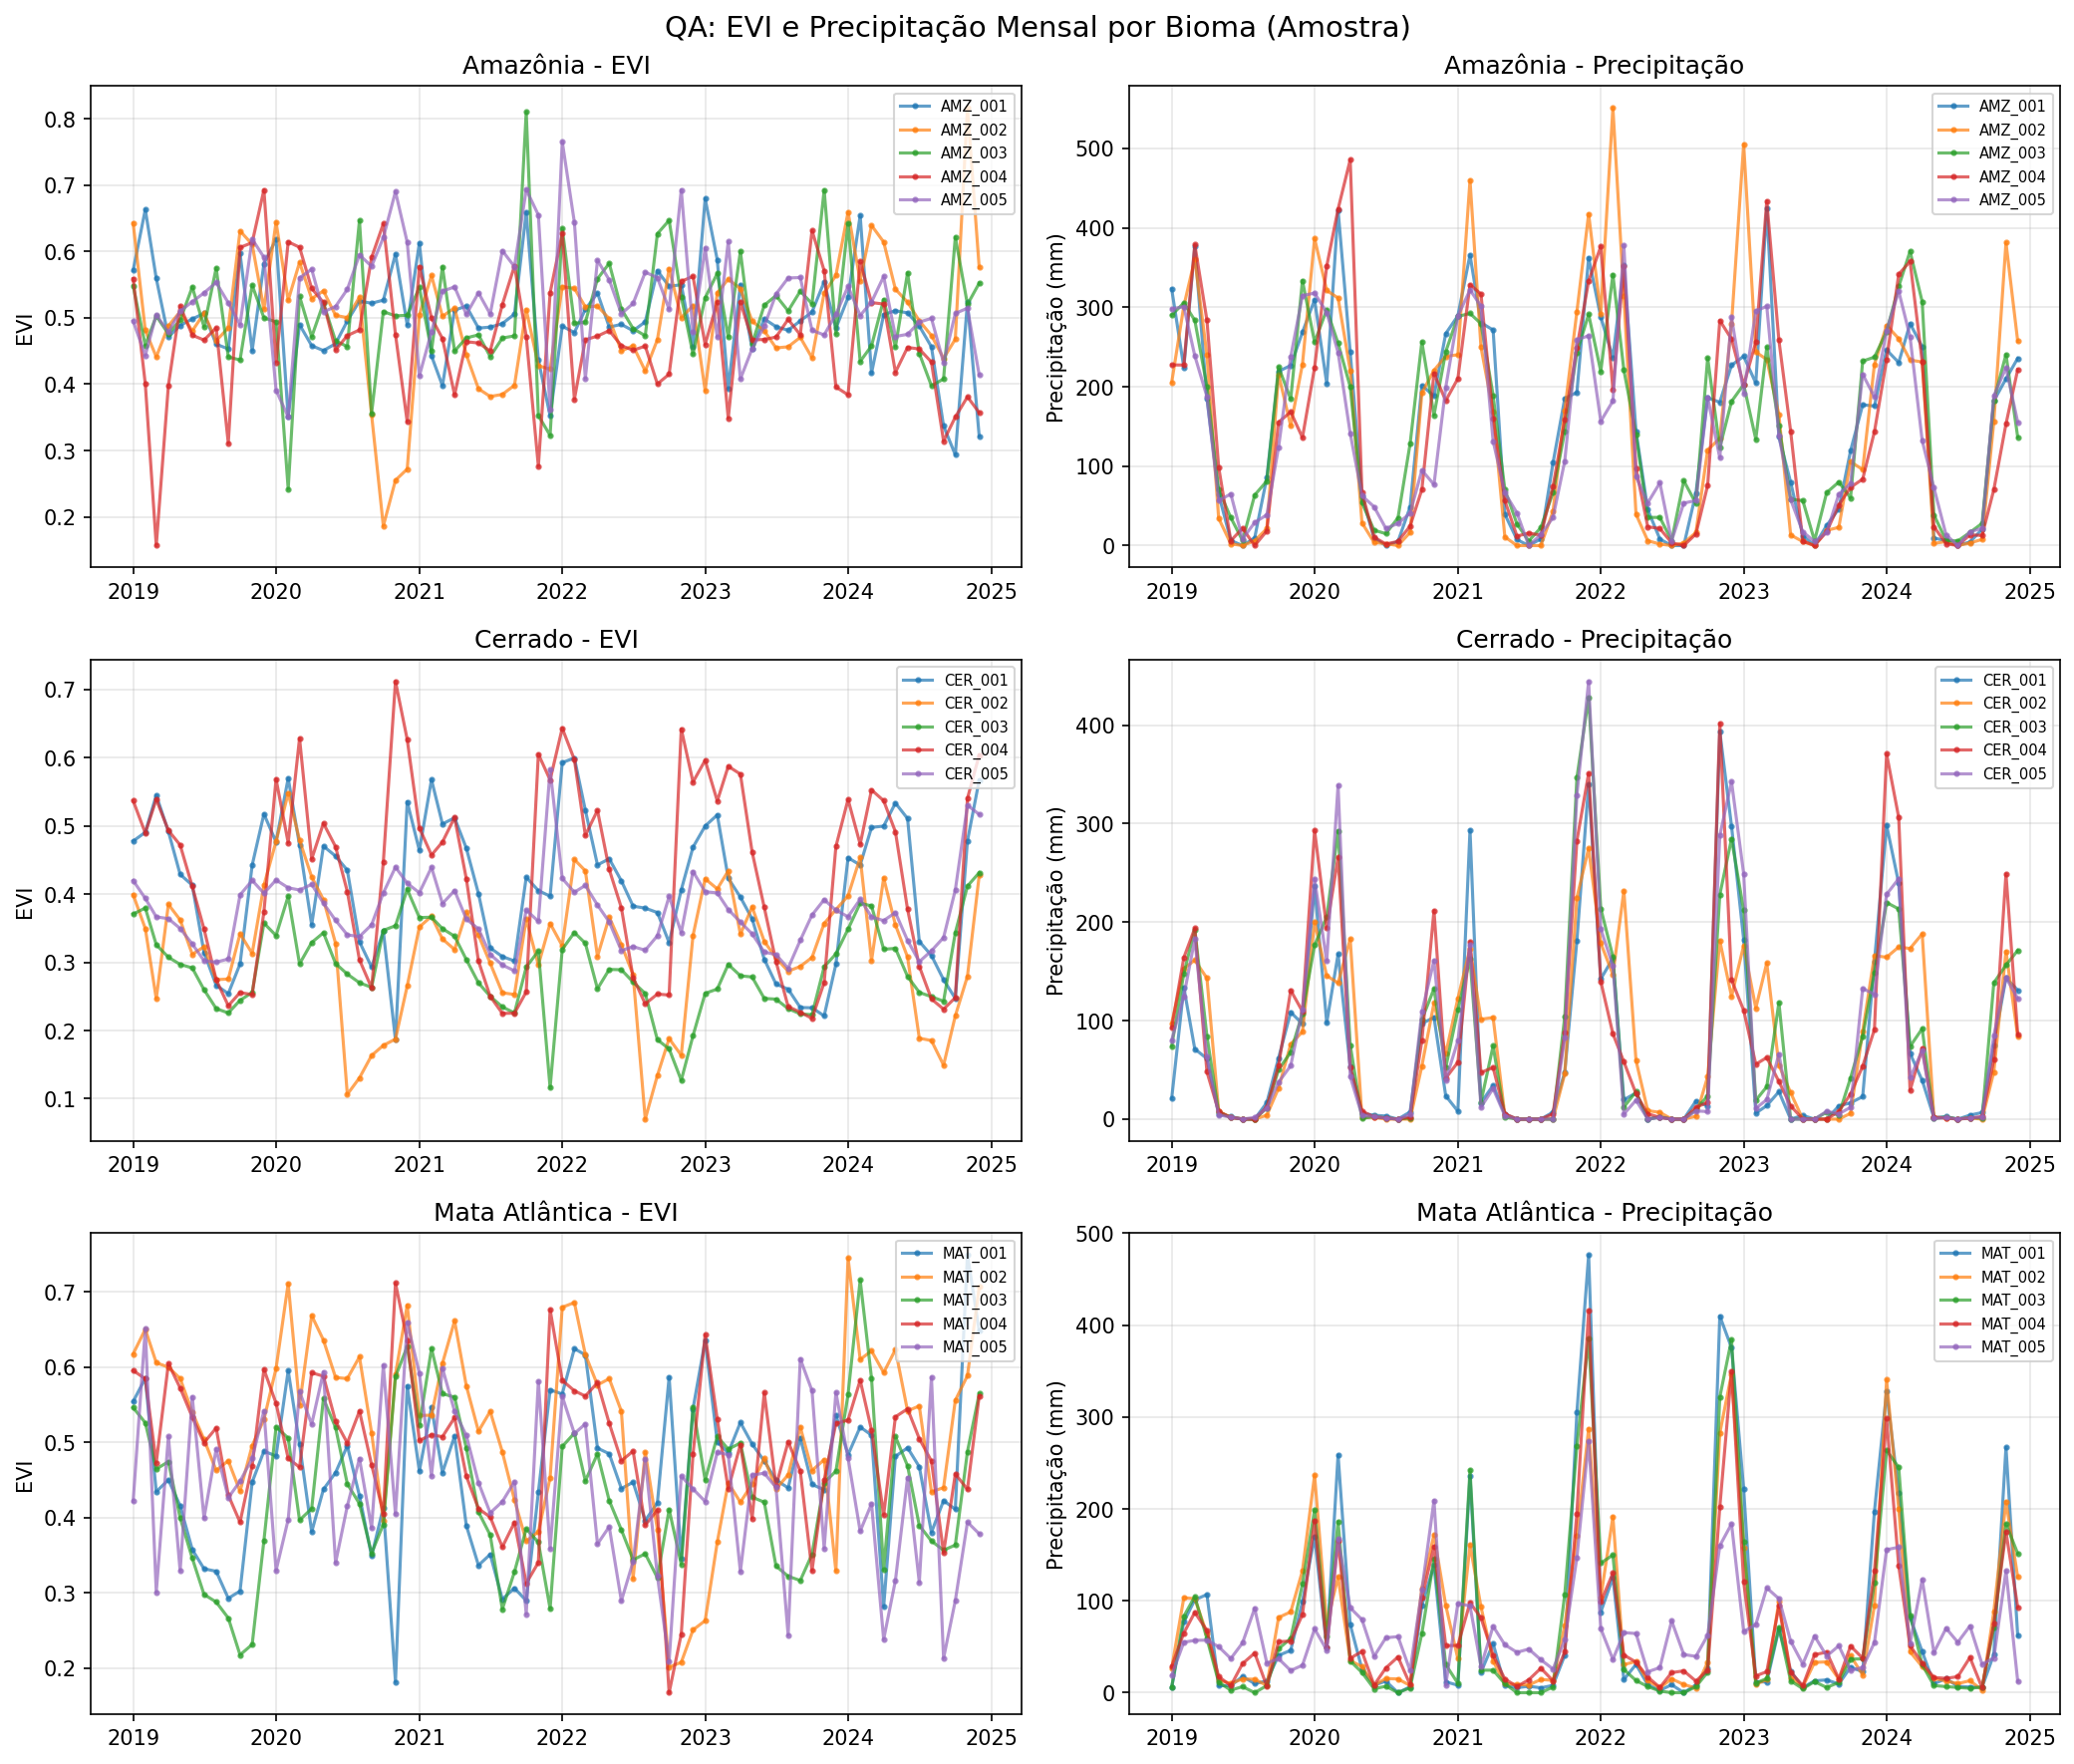

In [12]:
# ===========================================================================
# CÉLULA 7: QA VISUAL
# ===========================================================================
# Célula 7: QA Visual
"""
CELULA 7: QUALITY ASSURANCE - VISUALIZACAO
Gera graficos para validacao dos dados.
Adaptado para 360 pontos (amostra representativa).
"""

import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# ---------------------------------------------------------------------------
# VERIFICA CACHE DA FIGURA
# ---------------------------------------------------------------------------
FIG_PATH = PATHS["fig_qa_evi"]

if os.path.exists(FIG_PATH):
    print(f"Figura encontrada em cache: {FIG_PATH}")
    print("Exibindo figura salva...")
    from IPython.display import Image, display
    display(Image(filename=FIG_PATH))
else:
    print("Gerando figura QA...")

    # Carregar dados
    if 'merged' not in dir():
        merged = pd.read_parquet(PATHS["interim_merge"])

    # Criar figura com subplots (3 biomas x 2 metricas)
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle('QA: EVI e Precipitação Mensal por Bioma (Amostra)', fontsize=14)

    biomes = sorted(merged['biome'].unique())

    for idx, biome in enumerate(biomes):
        row = idx
        df_biome = merged[merged['biome'] == biome]

        # Selecionar amostra de sites para visualizacao (max 5 por bioma)
        sites_sample = df_biome['site'].unique()[:5]

        for site in sites_sample:
            df_site = df_biome[df_biome['site'] == site]

            # EVI
            axes[row, 0].plot(df_site['month'], df_site['evi'],
                            label=site, marker='o', markersize=2, alpha=0.7)
            axes[row, 0].set_ylabel('EVI')
            axes[row, 0].set_title(f'{biome} - EVI')
            axes[row, 0].grid(True, alpha=0.3)

            # Precipitação
            axes[row, 1].plot(df_site['month'], df_site['precip_month'],
                            label=site, marker='o', markersize=2, alpha=0.7)
            axes[row, 1].set_ylabel('Precipitação (mm)')
            axes[row, 1].set_title(f'{biome} - Precipitação')
            axes[row, 1].grid(True, alpha=0.3)

        axes[row, 0].legend(fontsize=7, loc='upper right')
        axes[row, 1].legend(fontsize=7, loc='upper right')

    plt.tight_layout()
    plt.savefig(FIG_PATH, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Figura salva em: {FIG_PATH}")

# Célula 8: Feature Engineering (anomalias, extremos, mês cíclico)

In [13]:
# ===========================================================================
# CÉLULA 8: FEATURE ENGINEERING
# ===========================================================================
# Célula 8: Feature Engineering (anomalias, extremos, mês cíclico) - VERSÃO RIGOROSA
"""
CELULA 8: FEATURE ENGINEERING - VERSÃO RIGOROSA (PAPER)

REGRAS SEM VAZAMENTO:
1.Climatologia (média/std mensal) calculada APENAS no período de treino (2019-2022)
2.P10 calculado APENAS no período de treino
3.Valores CONGELADOS e aplicados em val/test (sem recalcular)
4.Tudo salvo para reprodutibilidade
"""

import pandas as pd
import numpy as np
import json
import os

# Carregar dados
df = pd.read_parquet(PATHS["interim_merge"]).copy()
df["month"] = pd.to_datetime(df["month"])
df["moy"] = df["month"].dt.month
df["m_sin"] = np.sin(2 * np.pi * df["moy"] / 12)
df["m_cos"] = np.cos(2 * np.pi * df["moy"] / 12)

# ---------------------------------------------------------------------------
# MÁSCARAS TEMPORAIS - VERSÃO PAPER
# ---------------------------------------------------------------------------
warmup_end = pd.Timestamp(DATA.WARMUP_END) + pd.Timedelta(days=1)
train_end = pd.Timestamp(DATA.TRAIN_END) + pd.Timedelta(days=1)
val_end = pd.Timestamp(DATA.VAL_END) + pd.Timedelta(days=1)

# Máscara para cálculo de estatísticas (APENAS dados até fim do treino)
# Inclui warm-up + treino para climatologia robusta (2019-2022)
stats_mask = df["month"] < train_end

# Máscaras de split para verificação
warmup_mask = df["month"] < warmup_end
train_target_mask = (df["month"] >= warmup_end) & (df["month"] < train_end)
val_mask = (df["month"] >= train_end) & (df["month"] < val_end)
test_mask = df["month"] >= val_end

print("=" * 70)
print("FEATURE ENGINEERING - VERSÃO RIGOROSA (SEM VAZAMENTO)")
print("=" * 70)
print(f"\nSplit temporal:")
print(f"  Dados para stats: {DATA.START_DATE} a {DATA.TRAIN_END} (treino)")
print(f"  Warm-up (histórico): {DATA.START_DATE} a {DATA.WARMUP_END}")
print(f"  Train (targets):     2021-01-01 a {DATA.TRAIN_END}")
print(f"  Validation:          2023-01-01 a {DATA.VAL_END}")
print(f"  Test:                2024-01-01 a {DATA.END_DATE}")

print(f"\nRegistros por período:")
print(f"  Stats (treino):  {stats_mask.sum():,}")
print(f"  Warm-up:         {warmup_mask.sum():,}")
print(f"  Train (targets): {train_target_mask.sum():,}")
print(f"  Validation:      {val_mask.sum():,}")
print(f"  Test:            {test_mask.sum():,}")

# ---------------------------------------------------------------------------
# 1.CLIMATOLOGIA (CONGELADA DO TREINO)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[1] CLIMATOLOGIA (calculada APENAS no treino)")
print("-" * 60)

clim = (
    df[stats_mask]
    .groupby(["biome", "site", "moy"], as_index=False)
    .agg(
        evi_clim=("evi", "mean"),
        evi_std=("evi", "std"),
        ndvi_clim=("ndvi", "mean"),
        precip_clim=("precip_month", "mean")
    )
)

# Tratar std=0 ou NaN
clim["evi_std"] = clim["evi_std"].fillna(1e-6).replace(0, 1e-6)

# Estatísticas da climatologia
print(f"  Climatologias calculadas: {len(clim):,}")
print(f"  EVI_clim - min: {clim['evi_clim'].min():.4f}, max: {clim['evi_clim'].max():.4f}")
print(f"  EVI_std  - min: {clim['evi_std'].min():.4f}, max: {clim['evi_std'].max():.4f}")

# Salvar climatologia para reprodutibilidade
clim_path = f"{BASE}/outputs/checkpoints/climatology_frozen.csv"
clim.to_csv(clim_path, index=False)
print(f"  Climatologia salva: {clim_path}")

# Merge (aplica climatologia congelada a TODOS os dados)
df = df.merge(clim, on=["biome", "site", "moy"], how="left")

# Verificar se há NaNs após merge
n_missing_clim = df["evi_clim"].isna().sum()
if n_missing_clim > 0:
    print(f"  AVISO: {n_missing_clim} registros sem climatologia (serão removidos)")

# ---------------------------------------------------------------------------
# 2.ANOMALIAS E Z-SCORE (USANDO STATS CONGELADAS)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[2] ANOMALIAS E Z-SCORE (usando stats congeladas)")
print("-" * 60)

df["evi_anom"] = df["evi"] - df["evi_clim"]
df["evi_z"] = df["evi_anom"] / df["evi_std"]
df["ndvi_anom"] = df["ndvi"] - df["ndvi_clim"]
df["precip_anom"] = df["precip_month"] - df["precip_clim"]

print(f"  EVI_anom - min: {df['evi_anom'].min():.4f}, max: {df['evi_anom'].max():.4f}")
print(f"  EVI_z    - min: {df['evi_z'].min():.4f}, max: {df['evi_z'].max():.4f}")

# ---------------------------------------------------------------------------
# 3.P10 EXTREMOS (CONGELADO DO TREINO)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[3] P10 EXTREMOS (calculado APENAS no treino)")
print("-" * 60)

# P10 Global (apenas dados de treino)
p10_global = df[stats_mask]["evi_anom"].quantile(FEAT.EXTREME_PERCENTILE / 100)
print(f"  P10 Global: {p10_global:.4f}")

# P10 por Bioma (apenas dados de treino)
p10_por_bioma = (
    df[stats_mask]
    .groupby("biome")["evi_anom"]
    .quantile(FEAT.EXTREME_PERCENTILE / 100)
    .to_dict()
)
print(f"  P10 por Bioma:")
for biome, p10_val in p10_por_bioma.items():
    print(f"    {biome}: {p10_val:.4f}")

# Salvar thresholds P10 para reprodutibilidade
p10_frozen = {
    "method": "p10_from_train_only",
    "train_period": f"{DATA.START_DATE} to {DATA.TRAIN_END}",
    "percentile": FEAT.EXTREME_PERCENTILE,
    "n_samples_used": int(stats_mask.sum()),
    "p10_global": float(p10_global),
    "p10_por_bioma": {k: float(v) for k, v in p10_por_bioma.items()}
}

p10_path = f"{BASE}/outputs/checkpoints/p10_thresholds_frozen.json"
with open(p10_path, "w") as f:
    json.dump(p10_frozen, f, indent=2)
print(f"  P10 salvo: {p10_path}")

# Aplicar P10 congelado a TODOS os dados
df["extreme_global"] = (df["evi_anom"] <= p10_global).astype(int)
df["p10_biome"] = df["biome"].map(p10_por_bioma)
df["extreme_biome"] = (df["evi_anom"] <= df["p10_biome"]).astype(int)

# Escolha do alvo
if FEAT.EXTREME_BY_BIOME:
    df["extreme"] = df["extreme_biome"]
    extreme_method = "P10 por bioma (congelado do treino)"
else:
    df["extreme"] = df["extreme_global"]
    extreme_method = "P10 global (congelado do treino)"

print(f"\n  Alvo selecionado: {extreme_method}")

# ---------------------------------------------------------------------------
# 4.LIMPEZA
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[4] LIMPEZA DE DADOS")
print("-" * 60)

n_antes = len(df)
cols_required = ["evi_anom", "ndvi", "evi", "precip_month", "m_sin", "m_cos", "evi_clim", "evi_std"]
df = df.dropna(subset=cols_required)
n_depois = len(df)

print(f"  Registros antes: {n_antes:,}")
print(f"  Registros após:  {n_depois:,}")
print(f"  Removidos:       {n_antes - n_depois:,}")

# ---------------------------------------------------------------------------
# 5.VERIFICAÇÃO DE VAZAMENTO
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("VERIFICAÇÃO DE VAZAMENTO DE DADOS")
print("=" * 70)

# Recalcular máscaras após limpeza
warmup_mask = df["month"] < warmup_end
train_target_mask = (df["month"] >= warmup_end) & (df["month"] < train_end)
val_mask = (df["month"] >= train_end) & (df["month"] < val_end)
test_mask = df["month"] >= val_end

print(f"\n  Dados usados para P10/climatologia: {(df['month'] < train_end).sum():,} (treino)")
print(f"  Dados de validação: {val_mask.sum():,} (NÃO usados para stats)")
print(f"  Dados de teste: {test_mask.sum():,} (NÃO usados para stats)")

print(f"\n  Distribuição de extremos ({extreme_method}):")
for split_name, mask in [("Warm-up", warmup_mask), ("Train", train_target_mask),
                          ("Val", val_mask), ("Test", test_mask)]:
    df_split = df[mask]
    n_ext = df_split["extreme"].sum()
    n_tot = len(df_split)
    pct = 100 * n_ext / n_tot if n_tot > 0 else 0
    print(f"    {split_name:8s}: {n_ext:5d} / {n_tot:5d} ({pct:5.1f}%)")

print(f"\n  Distribuição por bioma e split:")
for biome in sorted(df["biome"].unique()):
    print(f"\n  {biome}:")
    for split_name, mask in [("Train", train_target_mask), ("Val", val_mask), ("Test", test_mask)]:
        biome_mask = mask & (df["biome"] == biome)
        df_bm = df[biome_mask]
        n_ext = df_bm["extreme"].sum()
        n_tot = len(df_bm)
        pct = 100 * n_ext / n_tot if n_tot > 0 else 0
        print(f"    {split_name:6s}: {n_ext:4d} / {n_tot:4d} ({pct:5.1f}%)")

print("\n" + "=" * 70)
print("FEATURE ENGINEERING CONCLUÍDO (SEM VAZAMENTO)")
print(f"  Total de registros: {len(df):,}")
print(f"  Arquivos salvos:")
print(f"    - {clim_path}")
print(f"    - {p10_path}")
print("=" * 70)

FEATURE ENGINEERING - VERSÃO RIGOROSA (SEM VAZAMENTO)

Split temporal:
  Dados para stats: 2019-01-01 a 2022-12-31 (treino)
  Warm-up (histórico): 2019-01-01 a 2020-12-31
  Train (targets):     2021-01-01 a 2022-12-31
  Validation:          2023-01-01 a 2023-12-31
  Test:                2024-01-01 a 2024-12-31

Registros por período:
  Stats (treino):  17,276
  Warm-up:         8,639
  Train (targets): 8,637
  Validation:      4,320
  Test:            4,320

------------------------------------------------------------
[1] CLIMATOLOGIA (calculada APENAS no treino)
------------------------------------------------------------
  Climatologias calculadas: 4,320
  EVI_clim - min: 0.1425, max: 0.7150
  EVI_std  - min: 0.0018, max: 0.2978
  Climatologia salva: /content/drive/MyDrive/deepveg-gee360/outputs/checkpoints/climatology_frozen.csv

------------------------------------------------------------
[2] ANOMALIAS E Z-SCORE (usando stats congeladas)
--------------------------------------------

# Célula 9: Criação de Sequências Temporais

In [14]:
# ===========================================================================
# CÉLULA 9: CRIAÇÃO DE SEQUÊNCIAS - SCALER CONGELADO
# ===========================================================================
# Célula 9: Criação de Sequências Temporais - VERSÃO RIGOROSA
"""
CELULA 9: CRIAÇÃO DE SEQUÊNCIAS - VERSÃO RIGOROSA (PAPER)

REGRAS SEM VAZAMENTO:
1.Scaler fit APENAS no treino
2.Transform aplicado em val/test (sem refit)
3.Scaler salvo para reprodutibilidade e deploy
4.Metadados de sites/biomas preservados para bootstrap por tile
"""

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import json

# Usar configs
SEQ_LEN = FEAT.SEQ_LEN
FEATURES = FEAT.FEATURES
TARGET_REG = FEAT.TARGET_REG
TARGET_BIN = FEAT.TARGET_CLS

print("=" * 70)
print("CRIAÇÃO DE SEQUÊNCIAS - SCALER CONGELADO")
print("=" * 70)
print(f"  SEQ_LEN: {SEQ_LEN} meses")
print(f"  Features: {FEATURES}")
print(f"  Target Reg: {TARGET_REG}")
print(f"  Target Cls: {TARGET_BIN}")


def make_sequences_with_metadata(df_site, seq_len, features, target_reg, target_bin):
    """
    Cria sequências de tamanho fixo para um site, preservando metadados.
    """
    df_site = df_site.sort_values("month").reset_index(drop=True)
    X, y_reg, y_bin, dates, biomes, sites = [], [], [], [], [], []

    for i in range(seq_len, len(df_site)):
        win = df_site.iloc[i - seq_len:i]
        X.append(win[features].values.astype("float32"))
        y_reg.append(float(df_site.iloc[i][target_reg]))
        y_bin.append(int(df_site.iloc[i][target_bin]))
        dates.append(df_site.iloc[i]["month"])
        biomes.append(df_site.iloc[i]["biome"])
        sites.append(df_site.iloc[i]["site"])

    if len(X) == 0:
        return (np.array([]).reshape(0, seq_len, len(features)),
                np.array([]), np.array([]),
                pd.Series([], dtype='datetime64[ns]'),
                pd.Series([], dtype=str),
                pd.Series([], dtype=str))

    return (np.stack(X), np.array(y_reg), np.array(y_bin),
            pd.Series(dates), pd.Series(biomes), pd.Series(sites))


# ---------------------------------------------------------------------------
# 1.CONSTRUIR SEQUÊNCIAS PARA TODOS OS SITES
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[1] CONSTRUINDO SEQUÊNCIAS")
print("-" * 60)

Xs, yr, yb, ds, bs, ss = [], [], [], [], [], []

for (b, s), g in df.groupby(["biome", "site"]):
    Xg, yg_r, yg_b, dg, bg, sg = make_sequences_with_metadata(
        g, SEQ_LEN, FEATURES, TARGET_REG, TARGET_BIN
    )
    if len(Xg) > 0:
        Xs.append(Xg)
        yr.append(yg_r)
        yb.append(yg_b)
        ds.append(dg)
        bs.append(bg)
        ss.append(sg)

X = np.vstack(Xs)
y_reg = np.concatenate(yr)
y_bin = np.concatenate(yb)
dates = pd.concat(ds, ignore_index=True)
biomes_seq = pd.concat(bs, ignore_index=True)
sites_seq = pd.concat(ss, ignore_index=True)

print(f"  Total sequências: {len(X):,}")
print(f"  Shape X: {X.shape}")
print(f"  Sites únicos: {sites_seq.nunique()}")

# ---------------------------------------------------------------------------
# 2.SPLIT TEMPORAL
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[2] SPLIT TEMPORAL")
print("-" * 60)

warmup_end = pd.Timestamp(DATA.WARMUP_END) + pd.Timedelta(days=1)
train_end = pd.Timestamp(DATA.TRAIN_END) + pd.Timedelta(days=1)
val_end = pd.Timestamp(DATA.VAL_END) + pd.Timedelta(days=1)

# Índices de split (targets começam após warm-up)
train_idx = (dates >= warmup_end) & (dates < train_end)
val_idx = (dates >= train_end) & (dates < val_end)
test_idx = dates >= val_end

# Arrays de dados
X_train_raw = X[train_idx]
X_val_raw = X[val_idx]
X_test_raw = X[test_idx]

yreg_train, ybin_train = y_reg[train_idx], y_bin[train_idx]
yreg_val, ybin_val = y_reg[val_idx], y_bin[val_idx]
yreg_test, ybin_test = y_reg[test_idx], y_bin[test_idx]

# Metadados para bootstrap por tile
dates_train = dates[train_idx].reset_index(drop=True)
dates_val = dates[val_idx].reset_index(drop=True)
dates_test = dates[test_idx].reset_index(drop=True)

biomes_train = biomes_seq[train_idx].reset_index(drop=True)
biomes_val = biomes_seq[val_idx].reset_index(drop=True)
biomes_test = biomes_seq[test_idx].reset_index(drop=True)

sites_train = sites_seq[train_idx].reset_index(drop=True)
sites_val = sites_seq[val_idx].reset_index(drop=True)
sites_test = sites_seq[test_idx].reset_index(drop=True)

print(f"  Train: {len(X_train_raw):,} ({dates[train_idx].min().date()} a {dates[train_idx].max().date()})")
print(f"  Val:   {len(X_val_raw):,} ({dates[val_idx].min().date()} a {dates[val_idx].max().date()})")
print(f"  Test:  {len(X_test_raw):,} ({dates[test_idx].min().date()} a {dates[test_idx].max().date()})")

# ---------------------------------------------------------------------------
# 3.SCALER FIT APENAS NO TREINO (CONGELADO)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[3] SCALER (fit APENAS no treino)")
print("-" * 60)

n_samples_train, seq_len, n_feat = X_train_raw.shape
X_train_flat = X_train_raw.reshape(-1, n_feat)

scaler = StandardScaler()
scaler.fit(X_train_flat)  # FIT APENAS NO TREINO!

print(f"  Amostras usadas para fit: {len(X_train_flat):,}")
print(f"  Média (treino):  {scaler.mean_.round(4)}")
print(f"  Std (treino):    {scaler.scale_.round(4)}")

# Salvar scaler (pickle)
scaler_path = PATHS["scaler_pkl"]
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"  Scaler salvo: {scaler_path}")

# Salvar metadados do scaler (JSON)
scaler_meta = {
    "method": "StandardScaler",
    "fit_on": "train_only",
    "train_period": f"2021-01-01 to {DATA.TRAIN_END}",
    "n_samples_fit": int(len(X_train_flat)),
    "n_features": int(n_feat),
    "features": list(FEATURES),
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
    "var": scaler.var_.tolist()
}

scaler_meta_path = f"{BASE}/outputs/checkpoints/scaler_meta.json"
with open(scaler_meta_path, "w") as f:
    json.dump(scaler_meta, f, indent=2)
print(f"  Metadados salvos: {scaler_meta_path}")

# ---------------------------------------------------------------------------
# 4.TRANSFORM (APLICAR SCALER CONGELADO)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[4] APLICANDO SCALER CONGELADO")
print("-" * 60)

X_train = scaler.transform(X_train_flat).reshape(n_samples_train, seq_len, n_feat).astype("float32")
X_val = scaler.transform(X_val_raw.reshape(-1, n_feat)).reshape(X_val_raw.shape).astype("float32")
X_test = scaler.transform(X_test_raw.reshape(-1, n_feat)).reshape(X_test_raw.shape).astype("float32")

# Verificar que transform não alterou scaler
print(f"  Média após transform (deve ser igual): {scaler.mean_.round(4)}")

# Estatísticas pós-normalização
print(f"\n  Estatísticas pós-normalização (Train):")
X_train_check = X_train.reshape(-1, n_feat)
print(f"    Média:  {X_train_check.mean(axis=0).round(4)}")
print(f"    Std:    {X_train_check.std(axis=0).round(4)}")

print(f"\n  Estatísticas pós-normalização (Val):")
X_val_check = X_val.reshape(-1, n_feat)
print(f"    Média:  {X_val_check.mean(axis=0).round(4)}")
print(f"    Std:    {X_val_check.std(axis=0).round(4)}")

print(f"\n  Estatísticas pós-normalização (Test):")
X_test_check = X_test.reshape(-1, n_feat)
print(f"    Média:  {X_test_check.mean(axis=0).round(4)}")
print(f"    Std:    {X_test_check.std(axis=0).round(4)}")

# ---------------------------------------------------------------------------
# 5.RESUMO E VERIFICAÇÃO
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("RESUMO DAS SEQUÊNCIAS")
print("=" * 70)

print(f"\nShapes finais:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

print(f"\nDistribuição de classes:")
for name, y in [("Train", ybin_train), ("Val", ybin_val), ("Test", ybin_test)]:
    n0, n1 = (y == 0).sum(), (y == 1).sum()
    pct1 = 100 * n1 / len(y)
    print(f"  {name}: classe_0={n0:,} ({100-pct1:.1f}%), classe_1={n1:,} ({pct1:.1f}%)")

print(f"\nTiles por split:")
print(f"  Train: {sites_train.nunique()} tiles")
print(f"  Val:   {sites_val.nunique()} tiles")
print(f"  Test:  {sites_test.nunique()} tiles")

# Verificar estimativas PAPER
n_tiles = DATA.N_TOTAL_POINTS
seqs_esperadas = n_tiles * 48  # 24 train + 12 val + 12 test

print(f"\nVerificação PAPER:")
print(f"  Tiles esperados: {n_tiles}")
print(f"  Seqs esperadas: {seqs_esperadas:,} (48/tile)")
print(f"  Seqs obtidas:   {len(X_train) + len(X_val) + len(X_test):,}")
print(f"    - Train: {len(X_train):,} (esperado ~{n_tiles * 24:,})")
print(f"    - Val:   {len(X_val):,} (esperado ~{n_tiles * 12:,})")
print(f"    - Test:  {len(X_test):,} (esperado ~{n_tiles * 12:,})")

print("\n" + "=" * 70)
print("SEQUÊNCIAS CRIADAS (SCALER CONGELADO, SEM VAZAMENTO)")
print("=" * 70)

CRIAÇÃO DE SEQUÊNCIAS - SCALER CONGELADO
  SEQ_LEN: 12 meses
  Features: ['evi', 'ndvi', 'precip_month', 'm_sin', 'm_cos']
  Target Reg: evi_anom
  Target Cls: extreme

------------------------------------------------------------
[1] CONSTRUINDO SEQUÊNCIAS
------------------------------------------------------------
  Total sequências: 21,596
  Shape X: (21596, 12, 5)
  Sites únicos: 360

------------------------------------------------------------
[2] SPLIT TEMPORAL
------------------------------------------------------------
  Train: 8,637 (2021-01-01 a 2022-12-01)
  Val:   4,320 (2023-01-01 a 2023-12-01)
  Test:  4,320 (2024-01-01 a 2024-12-01)

------------------------------------------------------------
[3] SCALER (fit APENAS no treino)
------------------------------------------------------------
  Amostras usadas para fit: 103,644
  Média (treino):  [ 4.451000e-01  7.154000e-01  1.458286e+02 -0.000000e+00 -2.000000e-04]
  Std (treino):    [1.152000e-01 1.446000e-01 1.239128e+02 7

# Célula 10: Baselines

In [15]:
# ===========================================================================
# CÉLULA 10: BASELINES COMPLETOS
# ===========================================================================
# Célula 10: Baselines Completos
"""
CELULA 10: BASELINES COMPLETOS (PAPER)

BASELINES:
1.Persistência Climatológica (anomalia = 0)
2.Persistência Lag-1 (prever último valor observado)
3.Ridge Regression com features flatten
4.Classificação: nunca extremo, random

Todos os resultados salvos em JSON para comparação com TCN.
"""

import numpy as np
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
from sklearn.linear_model import Ridge
from scipy.stats import pearsonr


def rmse(a, b):
    """Root Mean Squared Error."""
    return float(np.sqrt(mean_squared_error(a, b)))


def corr(a, b):
    """Correlação de Pearson."""
    if np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return float(pearsonr(a, b)[0])


print("=" * 70)
print("BASELINES COMPLETOS")
print("=" * 70)

baselines_results = {
    "regression": {},
    "classification": {}
}

# ---------------------------------------------------------------------------
# 1.REGRESSÃO: PERSISTÊNCIA CLIMATOLÓGICA (anomalia = 0)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[1] PERSISTÊNCIA CLIMATOLÓGICA (anomalia = 0)")
print("-" * 60)

yreg_pred_zero = np.zeros_like(yreg_test)

baseline_persist_zero = {
    "description": "Prever anomalia = 0 (média sazonal)",
    "MAE": float(mean_absolute_error(yreg_test, yreg_pred_zero)),
    "RMSE": float(rmse(yreg_test, yreg_pred_zero)),
    "CORR": float(corr(yreg_test, yreg_pred_zero))
}

print(f"  MAE  = {baseline_persist_zero['MAE']:.4f}")
print(f"  RMSE = {baseline_persist_zero['RMSE']:.4f}")
print(f"  CORR = {baseline_persist_zero['CORR']:.4f}")

baselines_results["regression"]["persistence_zero"] = baseline_persist_zero

# ---------------------------------------------------------------------------
# 2.REGRESSÃO: PERSISTÊNCIA LAG-1 (último valor da sequência)
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[2] PERSISTÊNCIA LAG-1 (último valor observado)")
print("-" * 60)

# O último timestep da sequência, feature EVI
# Usamos X_test_raw (antes da normalização) para ter valores reais
evi_idx = FEATURES.index("evi") if "evi" in FEATURES else 0

# Último timestep, feature evi (que está como valor bruto no X_raw)
yreg_pred_lag1 = X_test_raw[:, -1, evi_idx]

baseline_persist_lag1 = {
    "description": "Prever último valor de EVI observado na sequência",
    "MAE": float(mean_absolute_error(yreg_test, yreg_pred_lag1)),
    "RMSE": float(rmse(yreg_test, yreg_pred_lag1)),
    "CORR": float(corr(yreg_test, yreg_pred_lag1))
}

print(f"  MAE  = {baseline_persist_lag1['MAE']:.4f}")
print(f"  RMSE = {baseline_persist_lag1['RMSE']:.4f}")
print(f"  CORR = {baseline_persist_lag1['CORR']:.4f}")

baselines_results["regression"]["persistence_lag1"] = baseline_persist_lag1

# ---------------------------------------------------------------------------
# 3.REGRESSÃO: RIDGE REGRESSION
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[3] RIDGE REGRESSION (flatten sequência)")
print("-" * 60)

# Flatten sequências
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"  Shape flatten: {X_train_flat.shape}")

# Treinar Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_flat, yreg_train)

# Predições
yhat_ridge_train = model_ridge.predict(X_train_flat)
yhat_ridge_val = model_ridge.predict(X_val_flat)
yhat_ridge_test = model_ridge.predict(X_test_flat)

baseline_ridge = {
    "description": "Ridge Regression com sequência flatten",
    "alpha": 1.0,
    "n_features": int(X_train_flat.shape[1]),
    "train": {
        "MAE": float(mean_absolute_error(yreg_train, yhat_ridge_train)),
        "RMSE": float(rmse(yreg_train, yhat_ridge_train)),
        "CORR": float(corr(yreg_train, yhat_ridge_train))
    },
    "val": {
        "MAE": float(mean_absolute_error(yreg_val, yhat_ridge_val)),
        "RMSE": float(rmse(yreg_val, yhat_ridge_val)),
        "CORR": float(corr(yreg_val, yhat_ridge_val))
    },
    "test": {
        "MAE": float(mean_absolute_error(yreg_test, yhat_ridge_test)),
        "RMSE": float(rmse(yreg_test, yhat_ridge_test)),
        "CORR": float(corr(yreg_test, yhat_ridge_test))
    }
}

print(f"  Train: MAE={baseline_ridge['train']['MAE']:.4f}, CORR={baseline_ridge['train']['CORR']:.4f}")
print(f"  Val:   MAE={baseline_ridge['val']['MAE']:.4f}, CORR={baseline_ridge['val']['CORR']:.4f}")
print(f"  Test:  MAE={baseline_ridge['test']['MAE']:.4f}, CORR={baseline_ridge['test']['CORR']:.4f}")

baselines_results["regression"]["ridge"] = baseline_ridge

# Guardar para comparação com TCN
BASELINE_MAE = baseline_ridge["test"]["MAE"]
BASELINE_CORR = baseline_ridge["test"]["CORR"]

# ---------------------------------------------------------------------------
# 4.CLASSIFICAÇÃO: NUNCA EXTREMO
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[4] CLASSIFICAÇÃO - NUNCA EXTREMO")
print("-" * 60)

ybin_pred_never = np.zeros_like(ybin_test)
prec_never, rec_never, f1_never, _ = precision_recall_fscore_support(
    ybin_test, ybin_pred_never, average="binary", zero_division=0
)

baseline_cls_never = {
    "description": "Nunca prever extremo (sempre classe 0)",
    "Precision": float(prec_never),
    "Recall": float(rec_never),
    "F1": float(f1_never),
    "PR_AUC": 0.0
}

print(f"  Precision = {baseline_cls_never['Precision']:.4f}")
print(f"  Recall    = {baseline_cls_never['Recall']:.4f}")
print(f"  F1        = {baseline_cls_never['F1']:.4f}")

baselines_results["classification"]["never_extreme"] = baseline_cls_never

# ---------------------------------------------------------------------------
# 5.CLASSIFICAÇÃO: RANDOM BASELINE
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[5] CLASSIFICAÇÃO - RANDOM BASELINE")
print("-" * 60)

pos_rate = ybin_test.mean()
expected_precision = pos_rate
expected_recall = 0.5
expected_f1 = 2 * expected_precision * expected_recall / (expected_precision + expected_recall + 1e-8)

baseline_cls_random = {
    "description": "Predição aleatória com taxa observada",
    "positive_rate": float(pos_rate),
    "expected_Precision": float(expected_precision),
    "expected_Recall": float(expected_recall),
    "expected_F1": float(expected_f1)
}

print(f"  Taxa de positivos no teste: {pos_rate:.3f} ({pos_rate*100:.1f}%)")
print(f"  Precision esperada (random): {expected_precision:.4f}")
print(f"  F1 esperado (random):        {expected_f1:.4f}")

baselines_results["classification"]["random"] = baseline_cls_random

# ---------------------------------------------------------------------------
# 6.SALVAR BASELINES
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("[6] SALVANDO BASELINES")
print("-" * 60)

baselines_path = f"{BASE}/outputs/metrics/baselines.json"
with open(baselines_path, "w") as f:
    json.dump(baselines_results, f, indent=2)

print(f"  Baselines salvos: {baselines_path}")

# ---------------------------------------------------------------------------
# RESUMO
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("RESUMO - BASELINES PARA SUPERAR")
print("=" * 70)

print(f"""
REGRESSÃO (Anomalia EVI):
  - Persistência (anom=0): MAE={baseline_persist_zero['MAE']:.4f}, CORR={baseline_persist_zero['CORR']:.4f}
  - Persistência (lag-1):  MAE={baseline_persist_lag1['MAE']:.4f}, CORR={baseline_persist_lag1['CORR']:.4f}
  - Ridge Regression:      MAE={BASELINE_MAE:.4f}, CORR={BASELINE_CORR:.4f}

CLASSIFICAÇÃO (Extremos):
  - Nunca extremo: F1=0.000 (trivial)
  - Random:        F1≈{expected_f1:.3f} (esperado)

>>> TCN deve superar Ridge: MAE < {BASELINE_MAE:.4f}, CORR > {BASELINE_CORR:.4f}
""")

print("=" * 70)

BASELINES COMPLETOS

------------------------------------------------------------
[1] PERSISTÊNCIA CLIMATOLÓGICA (anomalia = 0)
------------------------------------------------------------
  MAE  = 0.0606
  RMSE = 0.0839
  CORR = 0.0000

------------------------------------------------------------
[2] PERSISTÊNCIA LAG-1 (último valor observado)
------------------------------------------------------------
  MAE  = 0.4477
  RMSE = 0.4665
  CORR = 0.1556

------------------------------------------------------------
[3] RIDGE REGRESSION (flatten sequência)
------------------------------------------------------------
  Shape flatten: (8637, 60)
  Train: MAE=0.0458, CORR=0.3160
  Val:   MAE=0.0557, CORR=0.2334
  Test:  MAE=0.0610, CORR=0.1057

------------------------------------------------------------
[4] CLASSIFICAÇÃO - NUNCA EXTREMO
------------------------------------------------------------
  Precision = 0.0000
  Recall    = 0.0000
  F1        = 0.0000

--------------------------------

## Célula 10.B: Helpers e Configurações Globais

In [16]:
# ===========================================================================
# CÉLULA 10.5: HELPERS E CONFIGURAÇÕES GLOBAIS
# ===========================================================================
# Célula 10.5: Helpers e Configurações Globais
"""
CELULA 10.5: HELPERS E CONFIGURACOES GLOBAIS
Funcoes utilitarias, configuracao de dispositivo e seeds.
Inclui baseline linear para comparacao.
Arquitetura TCN completa.
Usa configuracoes da Celula 1A.
"""

import os
import copy
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

# ---------------------------------------------------------------------------
# CONFIGURACAO DE DISPOSITIVO (GPU/CPU)
# ---------------------------------------------------------------------------
device = torch.device(ENV.DEVICE)
print(f"Dispositivo: {device}")
if device.type == "cuda":
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memoria: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# ---------------------------------------------------------------------------
# SEEDS PARA REPRODUCIBILIDADE
# ---------------------------------------------------------------------------
def set_seeds(seed=42):
    """Define seeds para reproducibilidade."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(ENV.SEED)

# ---------------------------------------------------------------------------
# FUNCOES DE METRICAS
# ---------------------------------------------------------------------------
def rmse(a, b):
    """Calcula Root Mean Squared Error."""
    return float(np.sqrt(mean_squared_error(a, b)))

def corr(a, b):
    """Calcula correlacao de Pearson."""
    if np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return float(pearsonr(a, b)[0])

# ---------------------------------------------------------------------------
# CONFIGURACOES GLOBAIS DE TREINO (da Celula 1A)
# ---------------------------------------------------------------------------
BATCH_SIZE = TRAIN.BATCH_SIZE
EPOCHS = TRAIN.EPOCHS
PATIENCE = TRAIN.PATIENCE

print(f"\nConfiguracoes de treino (da Celula 1A):")
print(f"  BATCH_SIZE = {BATCH_SIZE}")
print(f"  EPOCHS = {EPOCHS}")
print(f"  PATIENCE = {PATIENCE}")

# ---------------------------------------------------------------------------
# DIRETORIOS DE SAIDA
# ---------------------------------------------------------------------------
os.makedirs(f"{BASE}/outputs/checkpoints", exist_ok=True)
os.makedirs(f"{BASE}/outputs/metrics", exist_ok=True)
os.makedirs(f"{BASE}/outputs/figures", exist_ok=True)

# ---------------------------------------------------------------------------
# BLOCO TCN COMPLETO (2 convolucoes por bloco)
# ---------------------------------------------------------------------------
class Chomp1d(nn.Module):
    """Remove padding extra para manter causalidade."""
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        if self.chomp_size > 0:
            return x[:, :, :-self.chomp_size].contiguous()
        return x


class TCNBlock(nn.Module):
    """
    Bloco TCN completo com 2 convolucoes causais dilatadas.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, dropout=0.1):
        super(TCNBlock, self).__init__()

        padding = (kernel_size - 1) * dilation

        # Primeira convolução
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # Segunda convolução
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Conexão residual
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.relu_out = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = self.downsample(x)
        return self.relu_out(out + res)


# ---------------------------------------------------------------------------
# FOCAL LOSS (para classificacao desbalanceada)
# ---------------------------------------------------------------------------
class FocalLoss(nn.Module):
    """Focal Loss para classificacao desbalanceada."""
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        bce = nn.functional.binary_cross_entropy(pred, target, reduction='none')
        pt = torch.where(target == 1, pred, 1 - pred)
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        return (focal_weight * bce).mean()


# ---------------------------------------------------------------------------
# BASELINE LINEAR (para comparacao)
# ---------------------------------------------------------------------------
print("\n" + "=" * 60)
print("BASELINE LINEAR (Ridge Regression)")
print("=" * 60)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

model_linear = Ridge(alpha=1.0)
model_linear.fit(X_train_flat, yreg_train)

yhat_linear_val = model_linear.predict(X_val_flat)
yhat_linear_test = model_linear.predict(X_test_flat)

print(f"\nValidacao (n={len(yreg_val):,}):")
print(f"  MAE  = {mean_absolute_error(yreg_val, yhat_linear_val):.4f}")
print(f"  RMSE = {rmse(yreg_val, yhat_linear_val):.4f}")
print(f"  CORR = {corr(yreg_val, yhat_linear_val):.4f}")

print(f"\nTeste (n={len(yreg_test):,}):")
print(f"  MAE  = {mean_absolute_error(yreg_test, yhat_linear_test):.4f}")
print(f"  RMSE = {rmse(yreg_test, yhat_linear_test):.4f}")
print(f"  CORR = {corr(yreg_test, yhat_linear_test):.4f}")

BASELINE_CORR = corr(yreg_test, yhat_linear_test)
BASELINE_MAE = mean_absolute_error(yreg_test, yhat_linear_test)

print(f"\n>>> Baseline: MAE={BASELINE_MAE:.4f}, CORR={BASELINE_CORR:.4f}")
print(">>> TCN deve superar esses valores")

print("\n" + "=" * 60)
print("Helpers carregados com sucesso.")
print("=" * 60)

Dispositivo: cuda
  GPU: NVIDIA A100-SXM4-40GB
  Memoria: 42.47 GB

Configuracoes de treino (da Celula 1A):
  BATCH_SIZE = 64
  EPOCHS = 200
  PATIENCE = 15

BASELINE LINEAR (Ridge Regression)

Validacao (n=4,320):
  MAE  = 0.0557
  RMSE = 0.0767
  CORR = 0.2334

Teste (n=4,320):
  MAE  = 0.0610
  RMSE = 0.0844
  CORR = 0.1057

>>> Baseline: MAE=0.0610, CORR=0.1057
>>> TCN deve superar esses valores

Helpers carregados com sucesso.


# Célula 11: TCN Regressão (PyTorch)

In [17]:
# ===========================================================================
# CÉLULA 11: TCN REGRESSÃO (PyTorch)
# ===========================================================================
# Célula 11: TCN Regressão (PyTorch)
"""
CELULA 11: TCN REGRESSAO (PyTorch)
Usa configuracoes da Celula 1A (MODEL, TRAIN).
"""

import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import copy

# ---------------------------------------------------------------------------
# MODELO TCN REGRESSAO
# ---------------------------------------------------------------------------
class TCNRegressor(nn.Module):
    """TCN para regressao de series temporais."""

    def __init__(self, input_size, num_channels, kernel_size, dilations, dropout):
        super(TCNRegressor, self).__init__()

        layers = []
        in_ch = input_size

        for d in dilations:
            layers.append(TCNBlock(in_ch, num_channels, kernel_size,
                                   dilation=d, dropout=dropout))
            in_ch = num_channels

        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_channels, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.tcn(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.fc(x)
        return x.squeeze(-1)


# ---------------------------------------------------------------------------
# PREPARACAO DOS DADOS
# ---------------------------------------------------------------------------
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

yreg_train_t = torch.tensor(yreg_train, dtype=torch.float32)
yreg_val_t = torch.tensor(yreg_val, dtype=torch.float32)
yreg_test_t = torch.tensor(yreg_test, dtype=torch.float32)

train_dataset_reg = TensorDataset(X_train_t, yreg_train_t)
val_dataset_reg = TensorDataset(X_val_t, yreg_val_t)
test_dataset_reg = TensorDataset(X_test_t, yreg_test_t)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=BATCH_SIZE, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=BATCH_SIZE, shuffle=False)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=BATCH_SIZE, shuffle=False)

print("=" * 60)
print("TCN REGRESSAO - CONFIGURACAO")
print("=" * 60)
print(f"\nDataset:")
print(f"  Treino: {len(train_dataset_reg):,} amostras")
print(f"  Val:    {len(val_dataset_reg):,} amostras")
print(f"  Teste:  {len(test_dataset_reg):,} amostras")
print(f"  Features: {len(FEATURES)} ({FEATURES})")
print(f"  Seq len: {SEQ_LEN}")

# ---------------------------------------------------------------------------
# MODELO (usando configs da Celula 1A)
# ---------------------------------------------------------------------------
model_reg = TCNRegressor(
    input_size=len(FEATURES),
    num_channels=MODEL.NUM_CHANNELS,
    kernel_size=MODEL.KERNEL_SIZE,
    dilations=MODEL.DILATIONS,
    dropout=MODEL.DROPOUT
).to(device)

n_params = sum(p.numel() for p in model_reg.parameters())

print(f"\nArquitetura (da Celula 1A):")
print(f"  Blocos TCN: {MODEL.N_BLOCKS}")
print(f"  Canais: {MODEL.NUM_CHANNELS}")
print(f"  Dilatacoes: {MODEL.DILATIONS}")
print(f"  Campo receptivo: {MODEL.RECEPTIVE_FIELD} timesteps")
print(f"  Parametros: {n_params:,}")

# ---------------------------------------------------------------------------
# LOSS, OTIMIZADOR, SCHEDULER
# ---------------------------------------------------------------------------
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=TRAIN.LEARNING_RATE, weight_decay=TRAIN.WEIGHT_DECAY)
scheduler_reg = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_reg, mode='min', factor=TRAIN.SCHEDULER_FACTOR, patience=TRAIN.SCHEDULER_PATIENCE
)

# ---------------------------------------------------------------------------
# TREINAMENTO
# ---------------------------------------------------------------------------
best_val_loss_reg = float('inf')
best_val_corr_reg = -float('inf')
patience_counter_reg = 0
best_model_state_reg = None
train_losses_reg = []
val_losses_reg = []
val_corrs_reg = []

print("\n" + "=" * 60)
print("TREINAMENTO")
print("=" * 60)

for epoch in range(EPOCHS):
    # Treino
    model_reg.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_reg:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_reg.zero_grad()
        y_pred = model_reg(X_batch)
        loss = criterion_reg(y_pred, y_batch)
        loss.backward()

        if TRAIN.GRADIENT_CLIP > 0:
            torch.nn.utils.clip_grad_norm_(model_reg.parameters(), max_norm=TRAIN.GRADIENT_CLIP)

        optimizer_reg.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader_reg.dataset)
    train_losses_reg.append(train_loss)

    # Validacao
    model_reg.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader_reg:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model_reg(X_batch)
            loss = criterion_reg(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_preds.append(y_pred.cpu().numpy())
            val_true.append(y_batch.cpu().numpy())

    val_loss /= len(val_loader_reg.dataset)
    val_losses_reg.append(val_loss)

    val_preds = np.concatenate(val_preds)
    val_true = np.concatenate(val_true)
    val_corr = corr(val_true, val_preds)
    val_corrs_reg.append(val_corr)

    scheduler_reg.step(val_loss)

    # Early Stopping baseado em CORR
    if val_corr > best_val_corr_reg:
        best_val_corr_reg = val_corr
        best_val_loss_reg = val_loss
        patience_counter_reg = 0
        best_model_state_reg = copy.deepcopy(model_reg.state_dict())
    else:
        patience_counter_reg += 1

    # Log
    if (epoch + 1) % 10 == 0 or patience_counter_reg == PATIENCE:
        lr = optimizer_reg.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {val_loss:.4f} | CORR: {val_corr:.4f} | LR: {lr:.2e} | Patience: {patience_counter_reg}/{PATIENCE}")

    if patience_counter_reg >= PATIENCE:
        print(f"\n>>> Early stopping na epoch {epoch+1}")
        break

# Restaurar melhor modelo
if best_model_state_reg is not None:
    model_reg.load_state_dict(best_model_state_reg)

print(f"\nMelhor modelo:")
print(f"  Val Loss: {best_val_loss_reg:.4f}")
print(f"  Val CORR: {best_val_corr_reg:.4f}")

# ---------------------------------------------------------------------------
# AVALIACAO NO TESTE
# ---------------------------------------------------------------------------
model_reg.eval()
yhat_reg_list = []

with torch.no_grad():
    for X_batch, _ in test_loader_reg:
        X_batch = X_batch.to(device)
        y_pred = model_reg(X_batch)
        yhat_reg_list.append(y_pred.cpu().numpy())

yhat_reg = np.concatenate(yhat_reg_list)

mae_reg = mean_absolute_error(yreg_test, yhat_reg)
rmse_reg = rmse(yreg_test, yhat_reg)
corr_reg = corr(yreg_test, yhat_reg)

print("\n" + "=" * 60)
print("RESULTADOS - TESTE")
print("=" * 60)

print(f"\nTCN Regressao (Anomalia EVI):")
print(f"  MAE  = {mae_reg:.4f}")
print(f"  RMSE = {rmse_reg:.4f}")
print(f"  CORR = {corr_reg:.4f}")

print(f"\nComparacao com Baseline:")
print(f"  {'Metrica':<12} {'Baseline':>10} {'TCN':>10} {'Diff':>10}")
print(f"  {'-'*44}")
print(f"  {'MAE':<12} {BASELINE_MAE:>10.4f} {mae_reg:>10.4f} {mae_reg - BASELINE_MAE:>+10.4f}")
print(f"  {'CORR':<12} {BASELINE_CORR:>10.4f} {corr_reg:>10.4f} {corr_reg - BASELINE_CORR:>+10.4f}")

if corr_reg > BASELINE_CORR:
    print(f"\n>>> TCN superou baseline!")
else:
    print(f"\n>>> ATENCAO: TCN nao superou baseline")

# ---------------------------------------------------------------------------
# EVI ABSOLUTO RECONSTRUIDO
# ---------------------------------------------------------------------------
dates_test = dates[test_idx].reset_index(drop=True)

test_info = []
for (b, s), g in df.groupby(["biome", "site"]):
    g = g.sort_values("month").reset_index(drop=True)
    for i in range(SEQ_LEN, len(g)):
        row = g.iloc[i]
        if row["month"] >= pd.Timestamp(DATA.VAL_END) + pd.Timedelta(days=1):
            test_info.append({
                "month": row["month"],
                "biome": b,
                "site": s,
                "evi_clim": row["evi_clim"]
            })

df_test_info = pd.DataFrame(test_info)

if len(df_test_info) > 0 and len(df_test_info) == len(yhat_reg):
    evi_clim_test = df_test_info["evi_clim"].values
    evi_true_abs = yreg_test + evi_clim_test
    evi_pred_abs = yhat_reg + evi_clim_test

    mae_abs = mean_absolute_error(evi_true_abs, evi_pred_abs)
    rmse_abs = rmse(evi_true_abs, evi_pred_abs)
    corr_abs = corr(evi_true_abs, evi_pred_abs)

    print(f"\nTCN Regressao (EVI Absoluto):")
    print(f"  MAE  = {mae_abs:.4f}")
    print(f"  RMSE = {rmse_abs:.4f}")
    print(f"  CORR = {corr_abs:.4f}")
else:
    print(f"\n[AVISO] Desalinhamento EVI absoluto: {len(df_test_info)} vs {len(yhat_reg)}")
    mae_abs, rmse_abs, corr_abs = None, None, None
    evi_true_abs, evi_pred_abs = None, None

# ---------------------------------------------------------------------------
# SALVAR CHECKPOINT
# ---------------------------------------------------------------------------
CKPT_REG_PATH = f"{BASE}/outputs/checkpoints/tcn_reg_best.pt"
META_REG_PATH = f"{BASE}/outputs/checkpoints/tcn_reg_meta.json"

torch.save({
    "state_dict": model_reg.state_dict(),
    "input_size": len(FEATURES),
    "num_channels": MODEL.NUM_CHANNELS,
    "dilations": MODEL.DILATIONS,
    "kernel_size": MODEL.KERNEL_SIZE,
    "dropout": MODEL.DROPOUT,
    "best_val_loss": float(best_val_loss_reg),
    "best_val_corr": float(best_val_corr_reg)
}, CKPT_REG_PATH)

meta_reg = {
    "architecture": {
        "type": "TCN",
        "blocks": MODEL.N_BLOCKS,
        "convs_per_block": MODEL.CONVS_PER_BLOCK,
        "channels": MODEL.NUM_CHANNELS,
        "dilations": MODEL.DILATIONS,
        "receptive_field": MODEL.RECEPTIVE_FIELD,
        "parameters": n_params
    },
    "training": {
        "epochs_trained": epoch + 1,
        "best_val_loss": float(best_val_loss_reg),
        "best_val_corr": float(best_val_corr_reg),
        "batch_size": BATCH_SIZE,
        "learning_rate": TRAIN.LEARNING_RATE
    },
    "baseline": {
        "MAE": float(BASELINE_MAE),
        "CORR": float(BASELINE_CORR)
    },
    "test_metrics": {
        "anomaly": {
            "MAE": float(mae_reg),
            "RMSE": float(rmse_reg),
            "CORR": float(corr_reg)
        }
    },
    "features": list(FEATURES),
    "seq_len": int(SEQ_LEN),
    "dataset": {
        "n_train": len(yreg_train),
        "n_val": len(yreg_val),
        "n_test": len(yreg_test)
    }
}

if mae_abs is not None:
    meta_reg["test_metrics"]["evi_absolute"] = {
        "MAE": float(mae_abs),
        "RMSE": float(rmse_abs),
        "CORR": float(corr_abs)
    }

with open(META_REG_PATH, "w") as f:
    json.dump(meta_reg, f, indent=2)

print(f"\nCheckpoint: {CKPT_REG_PATH}")
print(f"Metadados:  {META_REG_PATH}")

TCN REGRESSAO - CONFIGURACAO

Dataset:
  Treino: 8,637 amostras
  Val:    4,320 amostras
  Teste:  4,320 amostras
  Features: 5 (['evi', 'ndvi', 'precip_month', 'm_sin', 'm_cos'])
  Seq len: 12

Arquitetura (da Celula 1A):
  Blocos TCN: 4
  Canais: 32
  Dilatacoes: [1, 2, 4, 8]
  Campo receptivo: 31 timesteps
  Parametros: 22,977

TREINAMENTO
Epoch  10/200 | Loss: 0.0061 | CORR: 0.1572 | LR: 1.00e-03 | Patience: 2/15
Epoch  20/200 | Loss: 0.0076 | CORR: 0.1434 | LR: 1.00e-03 | Patience: 1/15
Epoch  30/200 | Loss: 0.0060 | CORR: 0.1842 | LR: 5.00e-04 | Patience: 9/15
Epoch  36/200 | Loss: 0.0061 | CORR: 0.1845 | LR: 5.00e-04 | Patience: 15/15

>>> Early stopping na epoch 36

Melhor modelo:
  Val Loss: 0.0060
  Val CORR: 0.2020

RESULTADOS - TESTE

TCN Regressao (Anomalia EVI):
  MAE  = 0.0618
  RMSE = 0.0852
  CORR = 0.0514

Comparacao com Baseline:
  Metrica        Baseline        TCN       Diff
  --------------------------------------------
  MAE              0.0610     0.0618    +0.0

# Célula 12: TCN Classificação com Limiar Calibrado (PyTorch)

TCN CLASSIFICAÇÃO - VERSÃO RIGOROSA

Dataset:
  Treino: 8,637 amostras
  Val:    4,320 amostras
  Teste:  4,320 amostras

Distribuição de classes (treino):
  Classe 0 (normal):  7,609 (88.1%)
  Classe 1 (extremo): 1,028 (11.9%)
  Ratio: 1:7.4

Arquitetura:
  Blocos TCN: 4
  Canais: 32
  Dilatações: [1, 2, 4, 8]
  Parâmetros: 22,977

Loss: Focal (alpha=0.25, gamma=2.0)

------------------------------------------------------------
TREINAMENTO
------------------------------------------------------------
Epoch  10/200 | Loss: 0.0334 | F1: 0.2927 | LR: 1.00e-03 | Patience: 5/15
Epoch  20/200 | Loss: 0.0372 | F1: 0.2761 | LR: 5.00e-04 | Patience: 15/15

>>> Early stopping na epoch 20

Melhor modelo:
  Val Loss: 0.0382
  Val F1:   0.3080

------------------------------------------------------------
CALIBRAÇÃO DE THRESHOLD (Validação)
------------------------------------------------------------
  Método: max_f1
  Threshold calibrado: 0.4970
  Métricas na validação:
    Precision: 0.2026
    Re

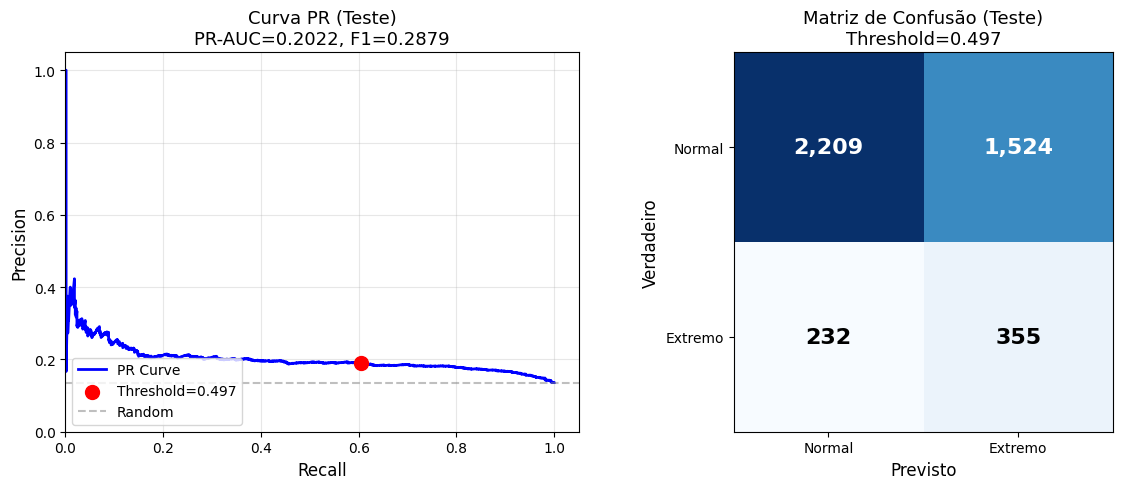

  Figura salva: /content/drive/MyDrive/deepveg-gee360/outputs/figures/pr_curve_confusion_cls.png

------------------------------------------------------------
SALVANDO CHECKPOINT
------------------------------------------------------------
  Checkpoint: /content/drive/MyDrive/deepveg-gee360/outputs/checkpoints/tcn_cls_best.pt
  Metadados:  /content/drive/MyDrive/deepveg-gee360/outputs/checkpoints/tcn_cls_meta.json

TCN CLASSIFICAÇÃO CONCLUÍDA


In [20]:
# ===========================================================================
# CÉLULA 12: TCN CLASSIFICAÇÃO COM CALIBRAÇÃO RIGOROSA
# ===========================================================================
# Célula 12: TCN Classificação com Limiar Calibrado (PyTorch) - VERSÃO RIGOROSA
"""
CELULA 12: TCN CLASSIFICAÇÃO - VERSÃO RIGOROSA (PAPER)

CALIBRAÇÃO RIGOROSA:
1.Threshold ótimo calculado via PR curve na VALIDAÇÃO
2.Threshold CONGELADO e aplicado no TESTE
3.Mesmo threshold será usado no LOBO
4.Bootstrap por tile para CIs
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    precision_recall_curve,
    classification_report,
    confusion_matrix
)
import copy


# ---------------------------------------------------------------------------
# FUNÇÃO DE CALIBRAÇÃO DE THRESHOLD
# ---------------------------------------------------------------------------
def calibrate_threshold_from_validation(y_true, y_proba, method="max_f1"):
    """
    Calibra threshold usando dados de validação.

    Args:
        y_true: labels verdadeiros (validação)
        y_proba: probabilidades preditas (validação)
        method: "max_f1", "target_recall", ou "fixed"

    Returns:
        dict com threshold calibrado e métricas
    """
    prec_curve, rec_curve, thresholds = precision_recall_curve(y_true, y_proba)

    # Calcular F1 para cada threshold
    f1_scores = 2 * (prec_curve[:-1] * rec_curve[:-1]) / (prec_curve[:-1] + rec_curve[:-1] + 1e-8)

    if method == "max_f1":
        best_idx = np.argmax(f1_scores)
        best_threshold = float(thresholds[best_idx])
        best_f1 = float(f1_scores[best_idx])
        best_precision = float(prec_curve[best_idx])
        best_recall = float(rec_curve[best_idx])

    elif method == "target_recall":
        target = EVAL.TARGET_RECALL
        valid_idx = np.where(rec_curve[:-1] >= target)[0]
        if len(valid_idx) > 0:
            best_idx = valid_idx[np.argmax(prec_curve[:-1][valid_idx])]
        else:
            best_idx = np.argmax(f1_scores)
        best_threshold = float(thresholds[best_idx])
        best_f1 = float(f1_scores[best_idx])
        best_precision = float(prec_curve[best_idx])
        best_recall = float(rec_curve[best_idx])

    else:  # fixed
        best_threshold = EVAL.FIXED_THRESHOLD
        y_pred = (y_proba >= best_threshold).astype(int)
        best_precision, best_recall, best_f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', zero_division=0
        )

    return {
        "threshold": best_threshold,
        "method": method,
        "validation_metrics": {
            "precision": float(best_precision),
            "recall": float(best_recall),
            "f1": float(best_f1)
        }
    }


# ---------------------------------------------------------------------------
# FUNÇÃO DE BOOTSTRAP POR TILE
# ---------------------------------------------------------------------------
def bootstrap_metric_by_tile(y_true, y_pred, tiles, metric_fn, n_bootstrap=1000, ci=0.95, seed=None):
    """
    Bootstrap por tile (não por amostra) para CIs mais conservadores.
    """
    if seed is None:
        seed = ENV.SEED
    np.random.seed(seed)
    unique_tiles = np.unique(tiles)
    n_tiles = len(unique_tiles)
    scores = []

    for _ in range(n_bootstrap):
        sampled_tiles = np.random.choice(unique_tiles, size=n_tiles, replace=True)

        idx = []
        for tile in sampled_tiles:
            tile_idx = np.where(tiles == tile)[0]
            idx.extend(tile_idx)
        idx = np.array(idx)

        if len(idx) > 0:
            try:
                score = metric_fn(y_true[idx], y_pred[idx])
                scores.append(score)
            except:
                continue

    if len(scores) == 0:
        return 0.0, 0.0, 0.0

    alpha = (1 - ci) / 2
    return (float(np.mean(scores)),
            float(np.percentile(scores, 100 * alpha)),
            float(np.percentile(scores, 100 * (1 - alpha))))


# ---------------------------------------------------------------------------
# MODELO TCN CLASSIFICAÇÃO
# ---------------------------------------------------------------------------
class TCNClassifier(nn.Module):
    """TCN para classificação binária."""

    def __init__(self, input_size, num_channels, kernel_size, dilations, dropout):
        super(TCNClassifier, self).__init__()

        layers = []
        in_ch = input_size

        for d in dilations:
            layers.append(TCNBlock(in_ch, num_channels, kernel_size,
                                   dilation=d, dropout=dropout))
            in_ch = num_channels

        self.tcn = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(num_channels, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.tcn(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x.squeeze(-1)


# ---------------------------------------------------------------------------
# PREPARAÇÃO DOS DADOS COM BALANCEAMENTO
# ---------------------------------------------------------------------------
print("=" * 70)
print("TCN CLASSIFICAÇÃO - VERSÃO RIGOROSA")
print("=" * 70)

ybin_train_t = torch.tensor(ybin_train, dtype=torch.float32)
ybin_val_t = torch.tensor(ybin_val, dtype=torch.float32)
ybin_test_t = torch.tensor(ybin_test, dtype=torch.float32)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# Weighted Sampler
class_counts = np.bincount(ybin_train.astype(int))
if len(class_counts) < 2:
    class_counts = np.array([len(ybin_train) - 1, 1])

class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = np.array([class_weights[int(y)] for y in ybin_train], dtype=np.float32)
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_dataset_cls = TensorDataset(X_train_t, ybin_train_t)
val_dataset_cls = TensorDataset(X_val_t, ybin_val_t)
test_dataset_cls = TensorDataset(X_test_t, ybin_test_t)

train_loader_cls = DataLoader(train_dataset_cls, batch_size=BATCH_SIZE, sampler=sampler)
val_loader_cls = DataLoader(val_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataset:")
print(f"  Treino: {len(train_dataset_cls):,} amostras")
print(f"  Val:    {len(val_dataset_cls):,} amostras")
print(f"  Teste:  {len(test_dataset_cls):,} amostras")

print(f"\nDistribuição de classes (treino):")
print(f"  Classe 0 (normal):  {class_counts[0]:,} ({100*class_counts[0]/len(ybin_train):.1f}%)")
print(f"  Classe 1 (extremo): {class_counts[1]:,} ({100*class_counts[1]/len(ybin_train):.1f}%)")
print(f"  Ratio: 1:{class_counts[0]/(class_counts[1]+1e-6):.1f}")

# ---------------------------------------------------------------------------
# MODELO
# ---------------------------------------------------------------------------
model_cls = TCNClassifier(
    input_size=len(FEATURES),
    num_channels=MODEL.NUM_CHANNELS,
    kernel_size=MODEL.KERNEL_SIZE,
    dilations=MODEL.DILATIONS,
    dropout=MODEL.DROPOUT
).to(device)

n_params_cls = sum(p.numel() for p in model_cls.parameters())

print(f"\nArquitetura:")
print(f"  Blocos TCN: {MODEL.N_BLOCKS}")
print(f"  Canais: {MODEL.NUM_CHANNELS}")
print(f"  Dilatações: {MODEL.DILATIONS}")
print(f"  Parâmetros: {n_params_cls:,}")

# ---------------------------------------------------------------------------
# LOSS, OTIMIZADOR, SCHEDULER
# ---------------------------------------------------------------------------
if TRAIN.CLS_LOSS == "focal":
    criterion_cls = FocalLoss(alpha=TRAIN.FOCAL_ALPHA, gamma=TRAIN.FOCAL_GAMMA)
    print(f"\nLoss: Focal (alpha={TRAIN.FOCAL_ALPHA}, gamma={TRAIN.FOCAL_GAMMA})")
else:
    criterion_cls = nn.BCELoss()
    print(f"\nLoss: BCE")

optimizer_cls = optim.Adam(model_cls.parameters(), lr=TRAIN.LEARNING_RATE, weight_decay=TRAIN.WEIGHT_DECAY)
scheduler_cls = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cls, mode='max', factor=TRAIN.SCHEDULER_FACTOR, patience=TRAIN.SCHEDULER_PATIENCE
)

# ---------------------------------------------------------------------------
# TREINAMENTO
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("TREINAMENTO")
print("-" * 60)

best_val_loss_cls = float('inf')
best_val_f1_cls = -float('inf')
patience_counter_cls = 0
best_model_state_cls = None
train_losses_cls = []
val_losses_cls = []
val_f1s_cls = []

for epoch in range(EPOCHS):
    # Treino
    model_cls.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_cls:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_cls.zero_grad()
        y_pred = model_cls(X_batch)
        loss = criterion_cls(y_pred, y_batch)
        loss.backward()

        if TRAIN.GRADIENT_CLIP > 0:
            torch.nn.utils.clip_grad_norm_(model_cls.parameters(), max_norm=TRAIN.GRADIENT_CLIP)

        optimizer_cls.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader_cls.dataset)
    train_losses_cls.append(train_loss)

    # Validação
    model_cls.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader_cls:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model_cls(X_batch)
            loss = criterion_cls(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_preds.append(y_pred.cpu().numpy())
            val_true.append(y_batch.cpu().numpy())

    val_loss /= len(val_loader_cls.dataset)
    val_losses_cls.append(val_loss)

    val_preds_arr = np.concatenate(val_preds)
    val_true_arr = np.concatenate(val_true)

    val_pred_binary = (val_preds_arr >= 0.5).astype(int)
    _, _, val_f1, _ = precision_recall_fscore_support(
        val_true_arr, val_pred_binary, average='binary', zero_division=0
    )
    val_f1s_cls.append(val_f1)

    scheduler_cls.step(val_f1)

    # Early Stopping baseado em F1
    if val_f1 > best_val_f1_cls:
        best_val_f1_cls = val_f1
        best_val_loss_cls = val_loss
        patience_counter_cls = 0
        best_model_state_cls = copy.deepcopy(model_cls.state_dict())
    else:
        patience_counter_cls += 1

    # Log
    if (epoch + 1) % 10 == 0 or patience_counter_cls == PATIENCE:
        lr = optimizer_cls.param_groups[0]['lr']
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {val_loss:.4f} | F1: {val_f1:.4f} | LR: {lr:.2e} | Patience: {patience_counter_cls}/{PATIENCE}")

    if patience_counter_cls >= PATIENCE:
        print(f"\n>>> Early stopping na epoch {epoch+1}")
        break

# Restaurar melhor modelo
if best_model_state_cls is not None:
    model_cls.load_state_dict(best_model_state_cls)

print(f"\nMelhor modelo:")
print(f"  Val Loss: {best_val_loss_cls:.4f}")
print(f"  Val F1:   {best_val_f1_cls:.4f}")

# ---------------------------------------------------------------------------
# CALIBRAÇÃO DE THRESHOLD NA VALIDAÇÃO
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("CALIBRAÇÃO DE THRESHOLD (Validação)")
print("-" * 60)

model_cls.eval()
yval_p_list = []

with torch.no_grad():
    for X_batch, _ in val_loader_cls:
        X_batch = X_batch.to(device)
        y_pred = model_cls(X_batch)
        yval_p_list.append(y_pred.cpu().numpy())

yval_p = np.concatenate(yval_p_list)

# Calibrar threshold via PR curve
calibration_result = calibrate_threshold_from_validation(
    ybin_val, yval_p, method="max_f1"
)

CALIB_THRESHOLD = calibration_result["threshold"]

print(f"  Método: {calibration_result['method']}")
print(f"  Threshold calibrado: {CALIB_THRESHOLD:.4f}")
print(f"  Métricas na validação:")
print(f"    Precision: {calibration_result['validation_metrics']['precision']:.4f}")
print(f"    Recall:    {calibration_result['validation_metrics']['recall']:.4f}")
print(f"    F1:        {calibration_result['validation_metrics']['f1']:.4f}")

# Salvar calibração
calib_path = f"{BASE}/outputs/checkpoints/threshold_calibration.json"
calibration_result["calibrated_on"] = "validation"
calibration_result["n_samples_validation"] = len(ybin_val)
calibration_result["n_positives_validation"] = int(ybin_val.sum())

with open(calib_path, "w") as f:
    json.dump(calibration_result, f, indent=2)
print(f"\n  Calibração salva: {calib_path}")
print(f"\n  >>> THRESHOLD {CALIB_THRESHOLD:.4f} será usado em teste e LOBO")

# ---------------------------------------------------------------------------
# AVALIAÇÃO NO TESTE
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("AVALIAÇÃO NO TESTE (Threshold Congelado)")
print("-" * 60)

ytest_p_list = []

with torch.no_grad():
    for X_batch, _ in test_loader_cls:
        X_batch = X_batch.to(device)
        y_pred = model_cls(X_batch)
        ytest_p_list.append(y_pred.cpu().numpy())

ytest_p = np.concatenate(ytest_p_list)
ytest_hat = (ytest_p >= CALIB_THRESHOLD).astype(int)

prec, rec, f1, _ = precision_recall_fscore_support(
    ybin_test, ytest_hat, average="binary", zero_division=0
)
ap = average_precision_score(ybin_test, ytest_p) if ybin_test.sum() > 0 else 0

print(f"\nResultados (threshold={CALIB_THRESHOLD:.4f}):")
print(f"  Precision = {prec:.4f}")
print(f"  Recall    = {rec:.4f}")
print(f"  F1        = {f1:.4f}")
print(f"  PR-AUC    = {ap:.4f}")

# Bootstrap por tile para CIs
if EVAL.RUN_BOOTSTRAP:
    print(f"\nBootstrap por tile (n={EVAL.N_BOOTSTRAP}, CI={EVAL.BOOTSTRAP_CI*100:.0f}%):")

    sites_test_arr = sites_test.values

    def f1_metric(y_true, y_pred_proba):
        y_pred = (y_pred_proba >= CALIB_THRESHOLD).astype(int)
        _, _, f1_val, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        return f1_val

    def ap_metric(y_true, y_pred_proba):
        if y_true.sum() == 0:
            return 0.0
        return average_precision_score(y_true, y_pred_proba)

    f1_mean, f1_lo, f1_hi = bootstrap_metric_by_tile(
        ybin_test, ytest_p, sites_test_arr, f1_metric, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI
    )
    ap_mean, ap_lo, ap_hi = bootstrap_metric_by_tile(
        ybin_test, ytest_p, sites_test_arr, ap_metric, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI
    )

    print(f"  F1:     {f1_mean:.4f} [{f1_lo:.4f}, {f1_hi:.4f}]")
    print(f"  PR-AUC: {ap_mean:.4f} [{ap_lo:.4f}, {ap_hi:.4f}]")

    bootstrap_cls_results = {
        "F1": {"mean": f1_mean, "ci_lower": f1_lo, "ci_upper": f1_hi},
        "PR_AUC": {"mean": ap_mean, "ci_lower": ap_lo, "ci_upper": ap_hi}
    }
else:
    bootstrap_cls_results = None

print(f"\nRelatório de Classificação:")
print(classification_report(ybin_test, ytest_hat, digits=4, target_names=['Normal', 'Extremo']))

# ---------------------------------------------------------------------------
# FIGURAS
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("GERANDO FIGURAS")
print("-" * 60)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Curva PR
prec_curve_test, rec_curve_test, _ = precision_recall_curve(ybin_test, ytest_p)
axes[0].plot(rec_curve_test, prec_curve_test, lw=2, color='blue', label=f'PR Curve')
axes[0].scatter([rec], [prec], color='red', s=100, zorder=5,
                label=f'Threshold={CALIB_THRESHOLD:.3f}')
axes[0].axhline(y=ybin_test.mean(), color='gray', linestyle='--', alpha=0.5, label='Random')
axes[0].set_xlabel("Recall", fontsize=12)
axes[0].set_ylabel("Precision", fontsize=12)
axes[0].set_title(f"Curva PR (Teste)\nPR-AUC={ap:.4f}, F1={f1:.4f}", fontsize=13)
axes[0].legend(loc='lower left')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1.05])
axes[0].set_ylim([0, 1.05])

# Matriz de Confusão
cm = confusion_matrix(ybin_test, ytest_hat, labels=[0, 1])
im = axes[1].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1].set_title(f"Matriz de Confusão (Teste)\nThreshold={CALIB_THRESHOLD:.3f}", fontsize=13)
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(['Normal', 'Extremo'])
axes[1].set_yticklabels(['Normal', 'Extremo'])
axes[1].set_xlabel('Previsto', fontsize=12)
axes[1].set_ylabel('Verdadeiro', fontsize=12)

thresh_cm = cm.max() / 2
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > thresh_cm else 'black'
        axes[1].text(j, i, f'{cm[i, j]:,}', ha='center', va='center',
                     color=color, fontsize=16, fontweight='bold')

plt.tight_layout()
fig_cls_path = f"{BASE}/outputs/figures/pr_curve_confusion_cls.png"
plt.savefig(fig_cls_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print(f"  Figura salva: {fig_cls_path}")

# ---------------------------------------------------------------------------
# SALVAR CHECKPOINT
# ---------------------------------------------------------------------------
print("\n" + "-" * 60)
print("SALVANDO CHECKPOINT")
print("-" * 60)

CKPT_CLS_PATH = f"{BASE}/outputs/checkpoints/tcn_cls_best.pt"
META_CLS_PATH = f"{BASE}/outputs/checkpoints/tcn_cls_meta.json"

torch.save({
    "state_dict": model_cls.state_dict(),
    "input_size": len(FEATURES),
    "num_channels": MODEL.NUM_CHANNELS,
    "dilations": MODEL.DILATIONS,
    "kernel_size": MODEL.KERNEL_SIZE,
    "dropout": MODEL.DROPOUT,
    "calibrated_threshold": CALIB_THRESHOLD,
    "best_val_loss": float(best_val_loss_cls),
    "best_val_f1": float(best_val_f1_cls)
}, CKPT_CLS_PATH)

meta_cls = {
    "architecture": {
        "type": "TCN",
        "blocks": MODEL.N_BLOCKS,
        "convs_per_block": MODEL.CONVS_PER_BLOCK,
        "channels": MODEL.NUM_CHANNELS,
        "dilations": MODEL.DILATIONS,
        "parameters": n_params_cls
    },
    "training": {
        "epochs_trained": epoch + 1,
        "best_val_loss": float(best_val_loss_cls),
        "best_val_f1": float(best_val_f1_cls),
        "batch_size": BATCH_SIZE,
        "learning_rate": TRAIN.LEARNING_RATE,
        "loss_function": TRAIN.CLS_LOSS
    },
    "preprocessing": {
        "scaler_path": PATHS["scaler_pkl"],
        "scaler_mean": scaler.mean_.tolist(),
        "scaler_scale": scaler.scale_.tolist(),
        "feature_names": list(FEATURES)
    },
    "calibration": {
        "threshold": float(CALIB_THRESHOLD),
        "method": "max_f1_from_pr_curve",
        "calibrated_on": "validation",
        "validation_metrics": calibration_result["validation_metrics"]
    },
    "test_metrics": {
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "PR_AUC": float(ap),
        "threshold_used": float(CALIB_THRESHOLD)
    },
    "class_distribution": {
        "train": {"class_0": int(class_counts[0]), "class_1": int(class_counts[1])},
        "val": {"class_0": int((ybin_val == 0).sum()), "class_1": int((ybin_val == 1).sum())},
        "test": {"class_0": int((ybin_test == 0).sum()), "class_1": int((ybin_test == 1).sum())}
    },
    "features": list(FEATURES),
    "seq_len": int(SEQ_LEN),
    "dataset": {
        "n_train": len(ybin_train),
        "n_val": len(ybin_val),
        "n_test": len(ybin_test)
    }
}

# Adicionar bootstrap se executado
if EVAL.RUN_BOOTSTRAP and bootstrap_cls_results is not None:
    meta_cls["test_metrics"]["bootstrap_ci"] = {
        "method": "by_tile",
        "confidence": EVAL.BOOTSTRAP_CI,
        "n_iterations": EVAL.N_BOOTSTRAP,
        "F1": bootstrap_cls_results["F1"],
        "PR_AUC": bootstrap_cls_results["PR_AUC"]
    }

with open(META_CLS_PATH, "w") as f:
    json.dump(meta_cls, f, indent=2)

print(f"  Checkpoint: {CKPT_CLS_PATH}")
print(f"  Metadados:  {META_CLS_PATH}")

print("\n" + "=" * 70)
print("TCN CLASSIFICAÇÃO CONCLUÍDA")
print("=" * 70)

# Célula 13: LOBO - Leave-One-Biome-Out (PyTorch)

In [21]:
# ===========================================================================
# CÉLULA 13: LOBO - LEAVE-ONE-BIOME-OUT (VERSÃO RIGOROSA)
# ===========================================================================
# Célula 13: LOBO - Leave-One-Biome-Out (PyTorch) - VERSÃO RIGOROSA
"""
CELULA 13: LOBO - VERSÃO RIGOROSA (PAPER)

REGRAS SEM VAZAMENTO:
1.Para cada fold, scaler fit APENAS nos dados de treino do fold
2.Threshold calibrado na VALIDAÇÃO do fold
3.Bootstrap por tile para CIs
4.Resultados salvos por fold (JSON) e consolidados
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    precision_recall_fscore_support,
    average_precision_score, roc_auc_score,
    precision_recall_curve
)
from scipy.stats import pearsonr
import copy

# ---------------------------------------------------------------------------
# VERIFICAR SE DEVE EXECUTAR LOBO
# ---------------------------------------------------------------------------
if not EVAL.RUN_LOBO:
    print("LOBO desativado na configuração (EVAL.RUN_LOBO = False)")
    print("Pulando Célula 13...")
else:
    print("=" * 70)
    print("LOBO (Leave-One-Biome-Out) - VERSÃO RIGOROSA")
    print("=" * 70)

    # ---------------------------------------------------------------------------
    # FUNÇÕES AUXILIARES
    # ---------------------------------------------------------------------------
    def rmse(a, b):
        return float(np.sqrt(mean_squared_error(a, b)))

    def corr(a, b):
        if np.std(a) == 0 or np.std(b) == 0:
            return 0.0
        return float(pearsonr(a, b)[0])

    def bootstrap_metric_by_tile(y_true, y_pred, tiles, metric_fn, n_bootstrap=1000, ci=0.95, seed=None):
        """Bootstrap por tile para CIs conservadores."""
        if seed is None:
            seed = ENV.SEED
        np.random.seed(seed)
        unique_tiles = np.unique(tiles)
        n_tiles = len(unique_tiles)
        scores = []

        for _ in range(n_bootstrap):
            sampled_tiles = np.random.choice(unique_tiles, size=n_tiles, replace=True)
            idx = []
            for tile in sampled_tiles:
                tile_idx = np.where(tiles == tile)[0]
                idx.extend(tile_idx)
            idx = np.array(idx)

            if len(idx) > 0:
                try:
                    score = metric_fn(y_true[idx], y_pred[idx])
                    scores.append(score)
                except:
                    continue

        if len(scores) == 0:
            return 0.0, 0.0, 0.0

        alpha = (1 - ci) / 2
        return (float(np.mean(scores)),
                float(np.percentile(scores, 100 * alpha)),
                float(np.percentile(scores, 100 * (1 - alpha))))

    def normalize_fold(X_train, X_val, X_test):
        """Normaliza dados do fold (scaler fit APENAS no treino do fold)."""
        n_tr, seq_len, n_feat = X_train.shape
        scaler_fold = StandardScaler()
        scaler_fold.fit(X_train.reshape(-1, n_feat))

        X_tr = scaler_fold.transform(X_train.reshape(-1, n_feat)).reshape(X_train.shape).astype("float32")
        X_va = scaler_fold.transform(X_val.reshape(-1, n_feat)).reshape(X_val.shape).astype("float32")
        X_te = scaler_fold.transform(X_test.reshape(-1, n_feat)).reshape(X_test.shape).astype("float32")

        return X_tr, X_va, X_te, scaler_fold

    def build_tcn_reg(input_size):
        """Constrói modelo TCN para regressão."""
        class TCNReg(nn.Module):
            def __init__(self):
                super(TCNReg, self).__init__()
                layers = []
                in_ch = input_size
                for d in MODEL.DILATIONS:
                    layers.append(TCNBlock(in_ch, MODEL.NUM_CHANNELS, kernel_size=MODEL.KERNEL_SIZE,
                                           dilation=d, dropout=MODEL.DROPOUT))
                    in_ch = MODEL.NUM_CHANNELS
                self.tcn = nn.Sequential(*layers)
                self.global_pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Linear(MODEL.NUM_CHANNELS, 1)

            def forward(self, x):
                x = x.permute(0, 2, 1)
                x = self.tcn(x)
                x = self.global_pool(x).squeeze(-1)
                x = self.fc(x)
                return x.squeeze(-1)

        return TCNReg()

    def build_tcn_cls(input_size):
        """Constrói modelo TCN para classificação."""
        class TCNCls(nn.Module):
            def __init__(self):
                super(TCNCls, self).__init__()
                layers = []
                in_ch = input_size
                for d in MODEL.DILATIONS:
                    layers.append(TCNBlock(in_ch, MODEL.NUM_CHANNELS, kernel_size=MODEL.KERNEL_SIZE,
                                           dilation=d, dropout=MODEL.DROPOUT))
                    in_ch = MODEL.NUM_CHANNELS
                self.tcn = nn.Sequential(*layers)
                self.global_pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Linear(MODEL.NUM_CHANNELS, 1)
                self.sigmoid = nn.Sigmoid()

            def forward(self, x):
                x = x.permute(0, 2, 1)
                x = self.tcn(x)
                x = self.global_pool(x).squeeze(-1)
                x = self.fc(x)
                x = self.sigmoid(x)
                return x.squeeze(-1)

        return TCNCls()

    def train_model(model, train_loader, val_loader, criterion, optimizer,
                    device, epochs, patience, scheduler=None, task='regression'):
        """Treina modelo com early stopping."""
        best_val_metric = float('inf') if task == 'regression' else -float('inf')
        patience_counter = 0
        best_model_state = None
        best_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=TRAIN.GRADIENT_CLIP)
                optimizer.step()

            model.eval()
            val_loss = 0.0
            val_preds = []
            val_true = []

            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    y_pred = model(X_batch)
                    loss = criterion(y_pred, y_batch)
                    val_loss += loss.item() * X_batch.size(0)
                    val_preds.append(y_pred.cpu().numpy())
                    val_true.append(y_batch.cpu().numpy())

            val_loss /= len(val_loader.dataset)
            val_preds = np.concatenate(val_preds)
            val_true = np.concatenate(val_true)

            if task == 'regression':
                val_metric = val_loss
                improved = val_metric < best_val_metric
            else:
                val_pred_binary = (val_preds >= 0.5).astype(int)
                _, _, val_f1, _ = precision_recall_fscore_support(
                    val_true, val_pred_binary, average='binary', zero_division=0
                )
                val_metric = val_f1
                improved = val_metric > best_val_metric

            if scheduler is not None:
                scheduler.step(val_loss if task == 'regression' else -val_metric)

            if improved:
                best_val_metric = val_metric
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = copy.deepcopy(model.state_dict())
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        return model, best_val_loss, epoch + 1

    def predict(model, data_loader, device):
        """Predições com modelo PyTorch."""
        model.eval()
        predictions = []
        with torch.no_grad():
            for X_batch, _ in data_loader:
                X_batch = X_batch.to(device)
                y_pred = model(X_batch)
                predictions.append(y_pred.cpu().numpy())
        return np.concatenate(predictions)

    def calibrate_threshold_fold(y_true, y_proba):
        """Calibra threshold via PR curve."""
        prec_c, rec_c, thr_c = precision_recall_curve(y_true, y_proba)
        f1_scores = 2 * (prec_c[:-1] * rec_c[:-1]) / (prec_c[:-1] + rec_c[:-1] + 1e-8)
        best_idx = np.argmax(f1_scores)
        return float(thr_c[best_idx]), float(f1_scores[best_idx])

    # ---------------------------------------------------------------------------
    # PREPARAÇÃO DOS DADOS COM METADADOS
    # ---------------------------------------------------------------------------
    print("\n[1] Preparando dados com metadados...")

    def make_sequences_lobo(df_full, seq_len, features, target_reg, target_bin):
        """Cria sequências mantendo metadados."""
        Xs, y_r, y_b, ds, bs, ss = [], [], [], [], [], []

        for (b, s), g in df_full.groupby(["biome", "site"]):
            g = g.sort_values("month").reset_index(drop=True)

            for i in range(seq_len, len(g)):
                win = g.iloc[i - seq_len:i]
                Xs.append(win[features].values.astype("float32"))
                y_r.append(float(g.iloc[i][target_reg]))
                y_b.append(int(g.iloc[i][target_bin]))
                ds.append(pd.Timestamp(g.iloc[i]["month"]))
                bs.append(b)
                ss.append(s)

        if len(Xs) == 0:
            return (np.empty((0, seq_len, len(features)), dtype="float32"),
                    np.array([], dtype="float32"),
                    np.array([], dtype=int),
                    pd.Series([], dtype=object),
                    pd.Series([], dtype=object),
                    pd.Series([], dtype=object))

        return (np.stack(Xs), np.array(y_r, dtype="float32"), np.array(y_b, dtype=int),
                pd.Series(ds), pd.Series(bs), pd.Series(ss))

    X_all, yreg_all, ybin_all, dates_all, biomes_all, sites_all = make_sequences_lobo(
        df, SEQ_LEN, FEATURES, FEAT.TARGET_REG, FEAT.TARGET_CLS
    )

    unique_biomes = sorted(df["biome"].unique().tolist())

    print(f"  Total sequências: {len(X_all):,}")
    print(f"  Biomas: {unique_biomes}")
    print(f"\n  Distribuição por bioma:")
    for biome in unique_biomes:
        n = (biomes_all == biome).sum()
        print(f"    {biome}: {n:,}")

    # Criar diretórios
    os.makedirs(f"{BASE}/outputs/metrics/lobo_folds", exist_ok=True)
    os.makedirs(f"{BASE}/outputs/figures/lobo_pr_curves", exist_ok=True)

    results = []

    # ---------------------------------------------------------------------------
    # LOOP LOBO
    # ---------------------------------------------------------------------------
    for left_out in unique_biomes:
        print(f"\n{'='*70}")
        print(f"FOLD: Deixando de fora [{left_out}]")
        print("=" * 70)

        fold_results = {
            "left_out": left_out,
            "regression": {},
            "classification": {}
        }

        # Máscaras temporais
        warmup_end = pd.Timestamp(DATA.WARMUP_END) + pd.Timedelta(days=1)
        train_end = pd.Timestamp(DATA.TRAIN_END) + pd.Timedelta(days=1)
        val_end = pd.Timestamp(DATA.VAL_END) + pd.Timedelta(days=1)

        train_date_mask = (dates_all >= warmup_end) & (dates_all < train_end)
        val_date_mask = (dates_all >= train_end) & (dates_all < val_end)
        test_date_mask = dates_all >= val_end

        # Máscaras espaciais (deixar bioma de fora)
        train_mask = (biomes_all != left_out) & train_date_mask
        val_mask = (biomes_all != left_out) & val_date_mask
        test_mask = (biomes_all == left_out) & test_date_mask

        ntr, nv, nt = int(train_mask.sum()), int(val_mask.sum()), int(test_mask.sum())
        print(f"\n  Amostras: train={ntr:,}, val={nv:,}, test={nt:,}")

        fold_results["n_samples"] = {"train": ntr, "val": nv, "test": nt}

        if ntr == 0 or nv == 0 or nt == 0:
            print("  >>> Conjunto vazio. Pulando fold.")
            continue

        # Splits
        X_tr_raw = X_all[train_mask]
        X_va_raw = X_all[val_mask]
        X_te_raw = X_all[test_mask]

        yr_tr, yr_va, yr_te = yreg_all[train_mask], yreg_all[val_mask], yreg_all[test_mask]
        yb_tr, yb_va, yb_te = ybin_all[train_mask], ybin_all[val_mask], ybin_all[test_mask]
        sites_te = sites_all[test_mask].values

        # NORMALIZAÇÃO POR FOLD (scaler fit APENAS no treino do fold)
        X_tr, X_va, X_te, scaler_fold = normalize_fold(X_tr_raw, X_va_raw, X_te_raw)

        fold_results["scaler"] = {
            "mean": scaler_fold.mean_.tolist(),
            "scale": scaler_fold.scale_.tolist()
        }

        # Tensores
        X_tr_t = torch.tensor(X_tr, dtype=torch.float32)
        X_va_t = torch.tensor(X_va, dtype=torch.float32)
        X_te_t = torch.tensor(X_te, dtype=torch.float32)
        yr_tr_t = torch.tensor(yr_tr, dtype=torch.float32)
        yr_va_t = torch.tensor(yr_va, dtype=torch.float32)
        yr_te_t = torch.tensor(yr_te, dtype=torch.float32)
        yb_tr_t = torch.tensor(yb_tr, dtype=torch.float32)
        yb_va_t = torch.tensor(yb_va, dtype=torch.float32)
        yb_te_t = torch.tensor(yb_te, dtype=torch.float32)

        # =====================================================================
        # REGRESSÃO
        # =====================================================================
        print("\n  --- REGRESSÃO ---")

        train_ds_r = TensorDataset(X_tr_t, yr_tr_t)
        val_ds_r = TensorDataset(X_va_t, yr_va_t)
        test_ds_r = TensorDataset(X_te_t, yr_te_t)

        train_loader_r = DataLoader(train_ds_r, batch_size=BATCH_SIZE, shuffle=True)
        val_loader_r = DataLoader(val_ds_r, batch_size=BATCH_SIZE, shuffle=False)
        test_loader_r = DataLoader(test_ds_r, batch_size=BATCH_SIZE, shuffle=False)

        model_r = build_tcn_reg(len(FEATURES)).to(device)
        criterion_r = nn.MSELoss()
        optimizer_r = optim.Adam(model_r.parameters(), lr=TRAIN.LEARNING_RATE, weight_decay=TRAIN.WEIGHT_DECAY)
        scheduler_r = optim.lr_scheduler.ReduceLROnPlateau(optimizer_r, mode='min', factor=0.5, patience=10)

        model_r, best_val_r, epochs_r = train_model(
            model_r, train_loader_r, val_loader_r, criterion_r, optimizer_r,
            device, epochs=EPOCHS, patience=PATIENCE, scheduler=scheduler_r, task='regression'
        )

        yhat_r = predict(model_r, test_loader_r, device)
        mae_r = mean_absolute_error(yr_te, yhat_r)
        rmse_r = rmse(yr_te, yhat_r)
        corr_r = corr(yr_te, yhat_r)

        print(f"    Epochs: {epochs_r}")
        print(f"    MAE={mae_r:.4f}  RMSE={rmse_r:.4f}  CORR={corr_r:.4f}")

        # Bootstrap por tile
        if EVAL.RUN_BOOTSTRAP:
            mae_m, mae_l, mae_h = bootstrap_metric_by_tile(yr_te, yhat_r, sites_te, mean_absolute_error, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI)
            corr_m, corr_l, corr_h = bootstrap_metric_by_tile(yr_te, yhat_r, sites_te, corr, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI)

            fold_results["regression"] = {
                "MAE": {"mean": mae_r, "ci_lower": mae_l, "ci_upper": mae_h},
                "RMSE": rmse_r,
                "CORR": {"mean": corr_r, "ci_lower": corr_l, "ci_upper": corr_h}
            }
            print(f"    MAE CI:  [{mae_l:.4f}, {mae_h:.4f}]")
            print(f"    CORR CI: [{corr_l:.4f}, {corr_h:.4f}]")
        else:
            fold_results["regression"] = {"MAE": mae_r, "RMSE": rmse_r, "CORR": corr_r}

        # Salvar checkpoint regressão
        ckpt_reg_fold_path = f"{BASE}/outputs/checkpoints/tcn_reg_lobo_{left_out.lower().replace(' ', '_')}.pt"
        torch.save({
            "state_dict": model_r.state_dict(),
            "left_out": left_out,
            "best_val_loss": float(best_val_r),
            "scaler_mean": scaler_fold.mean_.tolist(),
            "scaler_scale": scaler_fold.scale_.tolist()
        }, ckpt_reg_fold_path)

        # =====================================================================
        # CLASSIFICAÇÃO
        # =====================================================================
        print("\n  --- CLASSIFICAÇÃO ---")

        n_extremos = int(yb_te.sum())
        fold_results["n_extremos_test"] = n_extremos
        print(f"    Extremos no teste: {n_extremos}")

        class_counts_fold = np.bincount(yb_tr.astype(int))
        if len(class_counts_fold) < 2 or class_counts_fold[1] == 0:
            print("    >>> Sem amostras da classe 1 no treino. Pulando classificação.")
            fold_results["classification"] = None
        elif n_extremos == 0:
            print("    >>> Sem extremos no teste.Pulando classificação.")
            fold_results["classification"] = None
        else:
            print(f"    Classes treino: 0={class_counts_fold[0]:,}, 1={class_counts_fold[1]:,}")

            # Weighted sampler
            class_weights_fold = 1.0 / (class_counts_fold + 1e-6)
            sample_weights_fold = np.array([class_weights_fold[int(y)] for y in yb_tr], dtype=np.float32)
            sampler_fold = WeightedRandomSampler(sample_weights_fold, len(sample_weights_fold), replacement=True)

            train_ds_c = TensorDataset(X_tr_t, yb_tr_t)
            val_ds_c = TensorDataset(X_va_t, yb_va_t)
            test_ds_c = TensorDataset(X_te_t, yb_te_t)

            train_loader_c = DataLoader(train_ds_c, batch_size=BATCH_SIZE, sampler=sampler_fold)
            val_loader_c = DataLoader(val_ds_c, batch_size=BATCH_SIZE, shuffle=False)
            test_loader_c = DataLoader(test_ds_c, batch_size=BATCH_SIZE, shuffle=False)

            model_c = build_tcn_cls(len(FEATURES)).to(device)

            if TRAIN.CLS_LOSS == "focal":
                criterion_c = FocalLoss(alpha=TRAIN.FOCAL_ALPHA, gamma=TRAIN.FOCAL_GAMMA)
            else:
                criterion_c = nn.BCELoss()

            optimizer_c = optim.Adam(model_c.parameters(), lr=TRAIN.LEARNING_RATE, weight_decay=TRAIN.WEIGHT_DECAY)
            scheduler_c = optim.lr_scheduler.ReduceLROnPlateau(optimizer_c, mode='min', factor=0.5, patience=10)

            model_c, best_val_c, epochs_c = train_model(
                model_c, train_loader_c, val_loader_c, criterion_c, optimizer_c,
                device, epochs=EPOCHS, patience=PATIENCE, scheduler=scheduler_c, task='classification'
            )

            # Calibrar threshold NA VALIDAÇÃO DO FOLD
            yva_p = predict(model_c, val_loader_c, device)
            threshold_fold, val_f1_fold = calibrate_threshold_fold(yb_va, yva_p)

            print(f"    Epochs: {epochs_c}")
            print(f"    Threshold calibrado: {threshold_fold:.4f} (val F1={val_f1_fold:.4f})")

            # Aplicar no teste
            yte_p = predict(model_c, test_loader_c, device)
            yte_hat = (yte_p >= threshold_fold).astype(int)

            prec_fold, rec_fold, f1_fold, _ = precision_recall_fscore_support(
                yb_te, yte_hat, average="binary", zero_division=0
            )
            ap_fold = average_precision_score(yb_te, yte_p) if yb_te.sum() > 0 else 0

            try:
                roc_fold = roc_auc_score(yb_te, yte_p)
            except:
                roc_fold = float("nan")

            print(f"    Precision={prec_fold:.4f}  Recall={rec_fold:.4f}  F1={f1_fold:.4f}")
            print(f"    PR-AUC={ap_fold:.4f}  ROC-AUC={roc_fold:.4f}")

            # Bootstrap por tile
            if EVAL.RUN_BOOTSTRAP:
                def f1_metric_fold(y_true, y_pred_proba):
                    y_pred = (y_pred_proba >= threshold_fold).astype(int)
                    _, _, f1_val, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
                    return f1_val

                def ap_metric_fold(y_true, y_pred_proba):
                    return average_precision_score(y_true, y_pred_proba) if y_true.sum() > 0 else 0

                f1_m, f1_l, f1_h = bootstrap_metric_by_tile(yb_te, yte_p, sites_te, f1_metric_fold, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI)
                ap_m, ap_l, ap_h = bootstrap_metric_by_tile(yb_te, yte_p, sites_te, ap_metric_fold, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI)

                fold_results["classification"] = {
                    "Precision": float(prec_fold),
                    "Recall": float(rec_fold),
                    "F1": {"mean": float(f1_fold), "ci_lower": float(f1_l), "ci_upper": float(f1_h)},
                    "PR_AUC": {"mean": float(ap_fold), "ci_lower": float(ap_l), "ci_upper": float(ap_h)},
                    "ROC_AUC": float(roc_fold) if not np.isnan(roc_fold) else None,
                    "threshold": float(threshold_fold)
                }
                print(f"    F1 CI:     [{f1_l:.4f}, {f1_h:.4f}]")
                print(f"    PR-AUC CI: [{ap_l:.4f}, {ap_h:.4f}]")
            else:
                fold_results["classification"] = {
                    "Precision": float(prec_fold),
                    "Recall": float(rec_fold),
                    "F1": float(f1_fold),
                    "PR_AUC": float(ap_fold),
                    "ROC_AUC": float(roc_fold) if not np.isnan(roc_fold) else None,
                    "threshold": float(threshold_fold)
                }

            # Curva PR
            prec_curve_fold, rec_curve_fold, _ = precision_recall_curve(yb_te, yte_p)

            plt.figure(figsize=(6, 5))
            plt.plot(rec_curve_fold, prec_curve_fold, lw=2, color='blue', label=f'AP={ap_fold:.3f}')
            plt.scatter([rec_fold], [prec_fold], color='red', s=100, zorder=5, label=f'Thr={threshold_fold:.3f}')
            plt.axhline(y=yb_te.mean(), color='gray', linestyle='--', alpha=0.5, label='Random')
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"LOBO - {left_out}\nn_test={nt:,}, n_extremos={n_extremos}")
            plt.legend(loc='lower left')
            plt.grid(alpha=0.3)
            plt.xlim([0, 1.05])
            plt.ylim([0, 1.05])
            plt.tight_layout()

            pr_fig_path = f"{BASE}/outputs/figures/lobo_pr_curves/pr_lobo_{left_out.lower().replace(' ', '_')}.png"
            plt.savefig(pr_fig_path, dpi=150, bbox_inches='tight')
            plt.close()

            # Salvar checkpoint classificação
            ckpt_cls_fold_path = f"{BASE}/outputs/checkpoints/tcn_cls_lobo_{left_out.lower().replace(' ', '_')}.pt"
            torch.save({
                "state_dict": model_c.state_dict(),
                "left_out": left_out,
                "calibrated_threshold": float(threshold_fold),
                "best_val_loss": float(best_val_c),
                "scaler_mean": scaler_fold.mean_.tolist(),
                "scaler_scale": scaler_fold.scale_.tolist()
            }, ckpt_cls_fold_path)

        # Salvar fold JSON
        fold_json_path = f"{BASE}/outputs/metrics/lobo_folds/fold_{left_out.lower().replace(' ', '_')}.json"
        with open(fold_json_path, "w") as f:
            json.dump(fold_results, f, indent=2, default=float)
        print(f"\n  Fold salvo: {fold_json_path}")

        results.append(fold_results)

    # ---------------------------------------------------------------------------
    # CONSOLIDAR RESULTADOS
    # ---------------------------------------------------------------------------
    print("\n" + "=" * 70)
    print("LOBO - RESUMO CONSOLIDADO")
    print("=" * 70)

    if len(results) == 0:
        print("Nenhum fold executado com sucesso.")
        lobo_summary = {"n_folds": 0, "results": []}
    else:
        # Extrair métricas
        def get_metric_value(metric_dict, key):
            if metric_dict is None:
                return None
            val = metric_dict.get(key)
            if isinstance(val, dict):
                return val.get("mean", val)
            return val

        reg_mae = [get_metric_value(r["regression"], "MAE") for r in results if r["regression"]]
        reg_corr = [get_metric_value(r["regression"], "CORR") for r in results if r["regression"]]

        cls_f1 = [get_metric_value(r["classification"], "F1") for r in results if r["classification"] is not None]
        cls_ap = [get_metric_value(r["classification"], "PR_AUC") for r in results if r["classification"] is not None]

        # Limpar None
        reg_mae = [x for x in reg_mae if x is not None]
        reg_corr = [x for x in reg_corr if x is not None]
        cls_f1 = [x for x in cls_f1 if x is not None]
        cls_ap = [x for x in cls_ap if x is not None]

        lobo_summary = {
            "n_folds": len(results),
            "biomas": [r["left_out"] for r in results],
            "results_per_fold": results,
            "aggregated": {
                "regression": {
                    "MAE": {"mean": float(np.mean(reg_mae)), "std": float(np.std(reg_mae))} if reg_mae else None,
                    "CORR": {"mean": float(np.mean(reg_corr)), "std": float(np.std(reg_corr))} if reg_corr else None
                },
                "classification": {
                    "F1": {"mean": float(np.mean(cls_f1)), "std": float(np.std(cls_f1))} if cls_f1 else None,
                    "PR_AUC": {"mean": float(np.mean(cls_ap)), "std": float(np.std(cls_ap))} if cls_ap else None
                }
            }
        }

        print(f"\nRegressão (n={len(reg_mae)} folds):")
        if reg_mae:
            print(f"  MAE:  {np.mean(reg_mae):.4f} ± {np.std(reg_mae):.4f}")
            print(f"  CORR: {np.mean(reg_corr):.4f} ± {np.std(reg_corr):.4f}")

        print(f"\nClassificação (n={len(cls_f1)} folds):")
        if cls_f1:
            print(f"  F1:     {np.mean(cls_f1):.4f} ± {np.std(cls_f1):.4f}")
            print(f"  PR-AUC: {np.mean(cls_ap):.4f} ± {np.std(cls_ap):.4f}")

    # Salvar resumo
    lobo_json_path = f"{BASE}/outputs/metrics/lobo_summary.json"
    with open(lobo_json_path, "w") as f:
        json.dump(lobo_summary, f, indent=2, default=float)

    lobo_csv_path = f"{BASE}/outputs/metrics/lobo_summary.csv"

    # Flatten results para CSV
    csv_data = []
    for r in results:
        row = {
            "left_out": r["left_out"],
            "n_train": r["n_samples"]["train"],
            "n_val": r["n_samples"]["val"],
            "n_test": r["n_samples"]["test"],
            "n_extremos_test": r.get("n_extremos_test", 0),
            "REG_MAE": get_metric_value(r["regression"], "MAE"),
            "REG_RMSE": get_metric_value(r["regression"], "RMSE"),
            "REG_CORR": get_metric_value(r["regression"], "CORR"),
        }
        if r["classification"] is not None:
            row["CLS_Precision"] = get_metric_value(r["classification"], "Precision")
            row["CLS_Recall"] = get_metric_value(r["classification"], "Recall")
            row["CLS_F1"] = get_metric_value(r["classification"], "F1")
            row["CLS_PR_AUC"] = get_metric_value(r["classification"], "PR_AUC")
            row["CLS_Threshold"] = get_metric_value(r["classification"], "threshold")
        csv_data.append(row)

    pd.DataFrame(csv_data).to_csv(lobo_csv_path, index=False)

    print(f"\nArquivos salvos:")
    print(f"  - {lobo_json_path}")
    print(f"  - {lobo_csv_path}")
    print(f"  - {BASE}/outputs/metrics/lobo_folds/*.json")
    print(f"  - {BASE}/outputs/figures/lobo_pr_curves/*.png")

    print("\n" + "=" * 70)
    print("LOBO CONCLUÍDO")
    print("=" * 70)

LOBO (Leave-One-Biome-Out) - VERSÃO RIGOROSA

[1] Preparando dados com metadados...
  Total sequências: 21,596
  Biomas: ['Amazônia', 'Cerrado', 'Mata Atlântica']

  Distribuição por bioma:
    Amazônia: 7,200
    Cerrado: 7,200
    Mata Atlântica: 7,196

FOLD: Deixando de fora [Amazônia]

  Amostras: train=5,757, val=2,880, test=1,440

  --- REGRESSÃO ---
    Epochs: 32
    MAE=0.0730  RMSE=0.0983  CORR=0.1379
    MAE CI:  [0.0693, 0.0767]
    CORR CI: [0.0747, 0.1974]

  --- CLASSIFICAÇÃO ---
    Extremos no teste: 167
    Classes treino: 0=5,051, 1=706
    Epochs: 35
    Threshold calibrado: 0.4878 (val F1=0.3178)
    Precision=0.1669  Recall=0.6587  F1=0.2663
    PR-AUC=0.1656  ROC-AUC=0.6439
    F1 CI:     [0.2211, 0.3099]
    PR-AUC CI: [0.1317, 0.2062]

  Fold salvo: /content/drive/MyDrive/deepveg-gee360/outputs/metrics/lobo_folds/fold_amazônia.json

FOLD: Deixando de fora [Cerrado]

  Amostras: train=5,757, val=2,880, test=1,440

  --- REGRESSÃO ---
    Epochs: 45
    MAE=0.049

# Célula 14: Métricas e Figuras Finais

MÉTRICAS E META.JSON CONSOLIDADO

[1] Calculando métricas por bioma...
  Amazônia: n=1,440, MAE=0.0741, F1=0.2656
  Cerrado: n=1,440, MAE=0.0490, F1=0.3127
  Mata Atlântica: n=1,440, MAE=0.0624, F1=0.2810

  Salvo: /content/drive/MyDrive/deepveg-gee360/outputs/metrics/metrics_by_biome.json

[2] Gerando meta.json...
  Meta salvo: /content/drive/MyDrive/deepveg-gee360/outputs/meta.json
  Métricas salvas: /content/drive/MyDrive/deepveg-gee360/outputs/metrics/metrics.json

[3] Gerando figura consolidada...


/tmp/ipython-input-1706937125.py:412: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


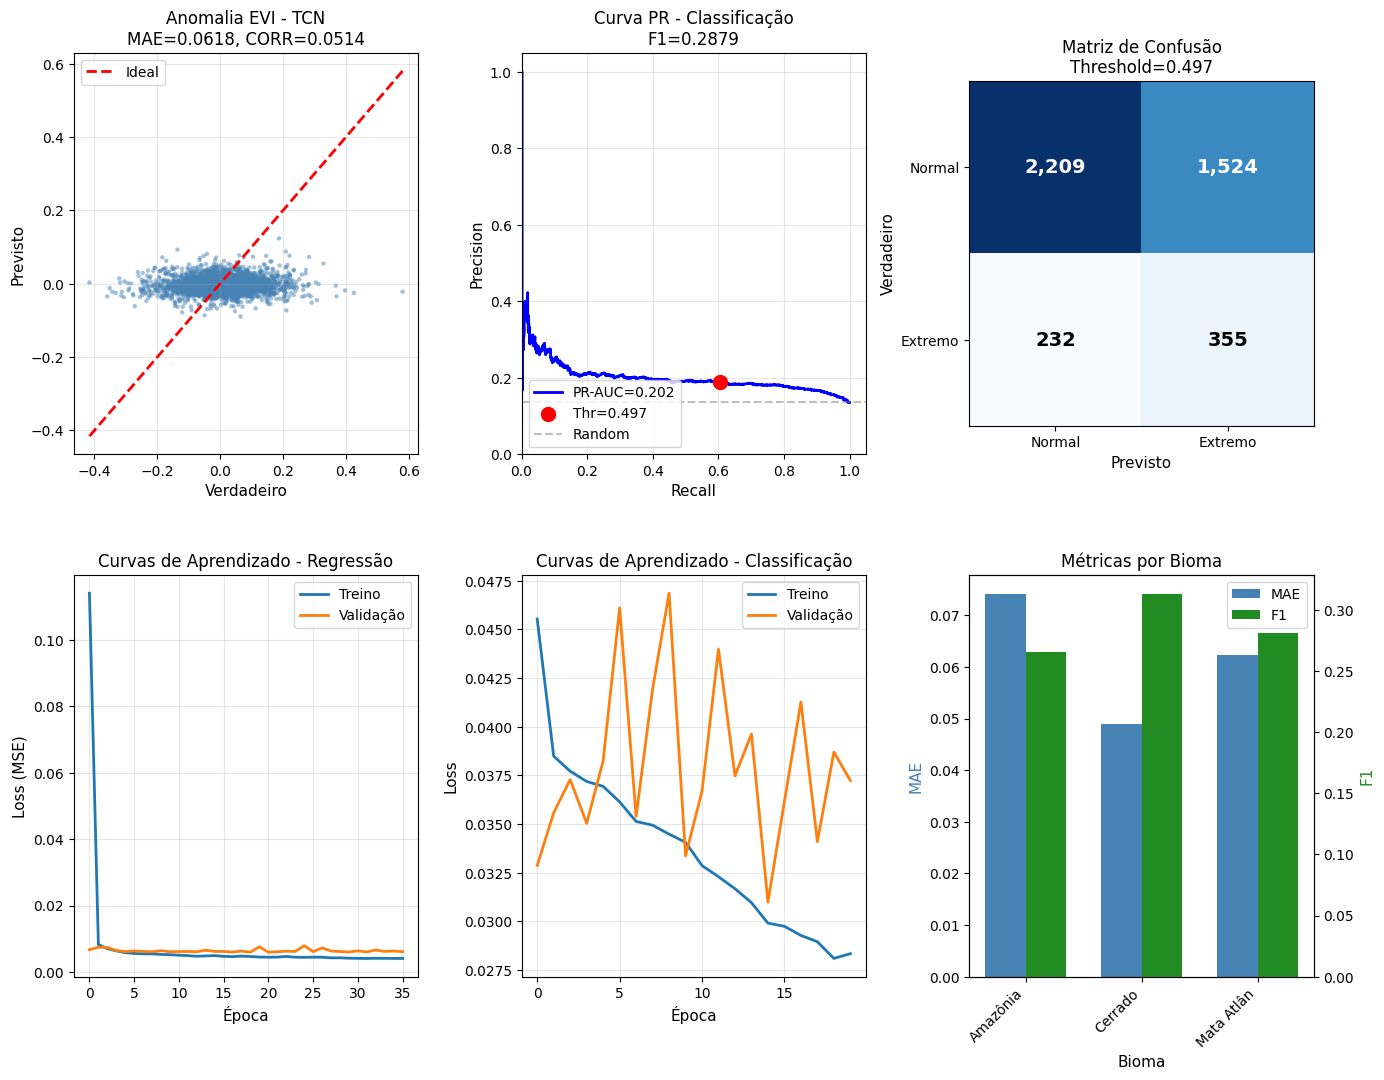

  Figura consolidada salva: /content/drive/MyDrive/deepveg-gee360/outputs/figures/consolidated_results.png

[4] Gerando tabelas...

TABELA 1: RESULTADOS PRINCIPAIS (TCN vs Baselines)


,Tarefa,Métrica,Baseline (Ridge),TCN,Δ,Melhor
0,Regressão,MAE,0.0610,0.0618,+0.0008,
1,Regressão,RMSE,0.0844,0.0852,+0.0008,
2,Regressão,CORR,0.1057,0.0514,-0.0542,
3,Classificação,Precision,0.0000,0.1889,+0.1889,✓
4,Classificação,Recall,0.0000,0.6048,+0.6048,✓
5,Classificação,F1,0.0000,0.2879,+0.2879,✓
6,Classificação,PR-AUC,0.1359,0.2022,+0.0664,✓



TABELA 2: RESULTADOS POR BIOMA


,Bioma,N Amostras,N Tiles,N Extremos,MAE,RMSE,CORR,Precision,Recall,F1,PR-AUC
0,Amazônia,1440,120,167,0.0741,0.1001,0.0470,0.1727,0.5749,0.2656,0.1983
1,Cerrado,1440,120,224,0.0490,0.0686,0.0813,0.2090,0.6205,0.3127,0.2296
2,Mata Atlântica,1440,120,196,0.0624,0.0839,0.0364,0.1824,0.6122,0.2810,0.1855
3,MÉDIA,4320,360,587,0.0618,0.0842,0.0549,0.1880,0.6025,0.2864,0.2045



TABELA 3: LOBO (Leave-One-Biome-Out)


,Bioma (Test),N Train,N Val,N Test,N Extremos,MAE,CORR,F1,PR-AUC,Threshold
0,Amazônia,5757,2880,1440,167,0.0730,0.1379,0.2663,0.1656,0.4878
1,Cerrado,5757,2880,1440,224,0.0494,0.1142,0.3112,0.2502,0.4970
2,Mata Atlântica,5760,2880,1440,196,0.0627,-0.0035,0.2374,0.1577,0.5234
3,MÉDIA ± STD,-,-,-,-,0.0617 ± 0.0097,0.0828 ± 0.0619,0.2716 ± 0.0303,0.1912 ± 0.0418,-



TABELA 4: INTERVALOS DE CONFIANÇA (Bootstrap por Tile)


,Tarefa,Métrica,Valor,IC 95% Inferior,IC 95% Superior
0,Regressão,MAE,0.0618,0.0593,0.0642
1,Regressão,CORR,0.0514,0.0092,0.0934
2,Classificação,F1,0.2879,0.2594,0.3131
3,Classificação,PR-AUC,0.2022,0.1730,0.2362



RESUMO FINAL - TRILHA 03 (VERSÃO PAPER RIGOROSA)

DATASET:
  - Pontos: 360 (120 por bioma)
  - Biomas: Amazônia, Cerrado, Mata Atlântica
  - SEQ_LEN: 12 | RF: 31
  - Amostras: train=8,637, val=4,320, test=4,320

SPLITS (SEM VAZAMENTO):
  - Warm-up: 2019-01-01 a 2020-12-31
  - Train:   2021-01-01 a 2022-12-31
  - Val:     2023-01-01 a 2023-12-31
  - Test:    2024-01-01 a 2024-12-31

REGRESSÃO (Anomalia EVI):
  - Baseline (Ridge): MAE=0.0610, CORR=0.1057
  - TCN:              MAE=0.0618, CORR=0.0514
  - Melhoria:         CORR -0.0542

CLASSIFICAÇÃO (Extremos p10):
  - Threshold: 0.4970 (calibrado na validação)
  - Precision: 0.1889
  - Recall:    0.6048
  - F1:        0.2879
  - PR-AUC:    0.2022


LOBO (Generalização Espacial):
  - Folds: 3
  - Regressão:
      MAE:  0.0617 ± 0.0097
      CORR: 0.0828 ± 0.0619
  - Classificação:
      F1:     0.2716 ± 0.0303
      PR-AUC: 0.1912 ± 0.0418


ARQUIVOS GERADOS:
  Checkpoints:
    - /content/drive/MyDrive/deepveg-gee360/outputs/checkpoints/

In [22]:
# ===========================================================================
# CÉLULA 14: MÉTRICAS E META.JSON CONSOLIDADO
# ===========================================================================
# Célula 14: Métricas e Figuras Finais - VERSÃO RIGOROSA
"""
CELULA 14: MÉTRICAS E META.JSON CONSOLIDADO (PAPER)

Salva:
1.metrics.json - métricas principais
2.metrics_by_biome.json - breakdown por bioma
3.meta.json - metadados completos do experimento
4.Figuras consolidadas
5.Tabela LaTeX para paper
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    precision_recall_fscore_support, average_precision_score,
    precision_recall_curve, confusion_matrix
)
from scipy.stats import pearsonr

# ---------------------------------------------------------------------------
# FUNÇÕES AUXILIARES
# ---------------------------------------------------------------------------
def rmse(a, b):
    return float(np.sqrt(mean_squared_error(a, b)))

def corr(a, b):
    if np.std(a) == 0 or np.std(b) == 0:
        return 0.0
    return float(pearsonr(a, b)[0])

print("=" * 70)
print("MÉTRICAS E META.JSON CONSOLIDADO")
print("=" * 70)

# ---------------------------------------------------------------------------
# 1.MÉTRICAS POR BIOMA (TESTE)
# ---------------------------------------------------------------------------
print("\n[1] Calculando métricas por bioma...")

metrics_by_biome = {}
sites_test_arr = sites_test.values

for biome in sorted(df["biome"].unique()):
    biome_mask = biomes_test == biome
    n_biome = biome_mask.sum()

    if n_biome == 0:
        continue

    yr_biome = yreg_test[biome_mask]
    yh_biome = yhat_reg[biome_mask]
    yb_biome = ybin_test[biome_mask]
    yp_biome = ytest_p[biome_mask]
    sites_biome = sites_test_arr[biome_mask]

    # Regressão
    mae_biome = mean_absolute_error(yr_biome, yh_biome)
    rmse_biome = rmse(yr_biome, yh_biome)
    corr_biome = corr(yr_biome, yh_biome)

    # Classificação
    yhat_biome = (yp_biome >= CALIB_THRESHOLD).astype(int)
    prec_b, rec_b, f1_b, _ = precision_recall_fscore_support(
        yb_biome, yhat_biome, average='binary', zero_division=0
    )
    ap_b = average_precision_score(yb_biome, yp_biome) if yb_biome.sum() > 0 else 0

    biome_result = {
        "n_samples": int(n_biome),
        "n_tiles": int(len(np.unique(sites_biome))),
        "n_extremos": int(yb_biome.sum()),
        "regression": {
            "MAE": float(mae_biome),
            "RMSE": float(rmse_biome),
            "CORR": float(corr_biome)
        },
        "classification": {
            "Precision": float(prec_b),
            "Recall": float(rec_b),
            "F1": float(f1_b),
            "PR_AUC": float(ap_b)
        }
    }

    # Bootstrap por tile se habilitado
    if EVAL.RUN_BOOTSTRAP:
        mae_m, mae_l, mae_h = bootstrap_metric_by_tile(yr_biome, yh_biome, sites_biome, mean_absolute_error, 500)
        corr_m, corr_l, corr_h = bootstrap_metric_by_tile(yr_biome, yh_biome, sites_biome, corr, 500)

        biome_result["regression"]["MAE_ci"] = [float(mae_l), float(mae_h)]
        biome_result["regression"]["CORR_ci"] = [float(corr_l), float(corr_h)]

    metrics_by_biome[biome] = biome_result
    print(f"  {biome}: n={n_biome:,}, MAE={mae_biome:.4f}, F1={f1_b:.4f}")

# Salvar
biome_metrics_path = f"{BASE}/outputs/metrics/metrics_by_biome.json"
with open(biome_metrics_path, "w") as f:
    json.dump(metrics_by_biome, f, indent=2)
print(f"\n  Salvo: {biome_metrics_path}")

# ---------------------------------------------------------------------------
# 2.META.JSON COMPLETO
# ---------------------------------------------------------------------------
print("\n[2] Gerando meta.json...")

meta = {
    "experiment": {
        "name": "DeepVegTCN-360",
        "version": "paper_v1_rigorous",
        "timestamp": datetime.now().isoformat(),
        "seed": ENV.SEED,
        "device": ENV.DEVICE
    },

    "dataset": {
        "n_points": len(POINTS),
        "n_points_per_biome": DATA.N_POINTS_PER_BIOME,
        "biomes": list(df["biome"].unique()),
        "min_distance_km": DATA.MIN_DISTANCE_KM,
        "period": {
            "start": DATA.START_DATE,
            "end": DATA.END_DATE,
            "warmup": f"{DATA.START_DATE} to {DATA.WARMUP_END}",
            "train": f"2021-01-01 to {DATA.TRAIN_END}",
            "val": f"2023-01-01 to {DATA.VAL_END}",
            "test": f"2024-01-01 to {DATA.END_DATE}"
        },
        "samples": {
            "train": int(len(yreg_train)),
            "val": int(len(yreg_val)),
            "test": int(len(yreg_test)),
            "total": int(len(yreg_train) + len(yreg_val) + len(yreg_test))
        },
        "tiles": {
            "train": int(sites_train.nunique()),
            "val": int(sites_val.nunique()),
            "test": int(sites_test.nunique())
        }
    },

    "preprocessing": {
        "features": list(FEATURES),
        "seq_len": int(SEQ_LEN),
        "normalization": {
            "method": "zscore",
            "fit_on": "train_only",
            "scaler_path": PATHS["scaler_pkl"],
            "scaler_meta_path": f"{BASE}/outputs/checkpoints/scaler_meta.json"
        },
        "climatology": {
            "calculated_on": "train_only",
            "path": f"{BASE}/outputs/checkpoints/climatology_frozen.csv"
        },
        "extreme_definition": {
            "percentile": FEAT.EXTREME_PERCENTILE,
            "by_biome": FEAT.EXTREME_BY_BIOME,
            "calculated_on": "train_only",
            "p10_global": float(p10_global),
            "p10_by_biome": {k: float(v) for k, v in p10_por_bioma.items()},
            "path": f"{BASE}/outputs/checkpoints/p10_thresholds_frozen.json"
        }
    },

    "architecture": {
        "type": "TCN",
        "blocks": MODEL.N_BLOCKS,
        "convs_per_block": MODEL.CONVS_PER_BLOCK,
        "channels": MODEL.NUM_CHANNELS,
        "kernel_size": MODEL.KERNEL_SIZE,
        "dilations": MODEL.DILATIONS,
        "dropout": MODEL.DROPOUT,
        "receptive_field": MODEL.RECEPTIVE_FIELD,
        "parameters": {
            "regression": n_params,
            "classification": n_params_cls
        }
    },

    "training": {
        "batch_size": TRAIN.BATCH_SIZE,
        "max_epochs": TRAIN.EPOCHS,
        "patience": TRAIN.PATIENCE,
        "optimizer": TRAIN.OPTIMIZER,
        "learning_rate": TRAIN.LEARNING_RATE,
        "weight_decay": TRAIN.WEIGHT_DECAY,
        "gradient_clip": TRAIN.GRADIENT_CLIP,
        "loss": {
            "regression": TRAIN.REG_LOSS,
            "classification": TRAIN.CLS_LOSS,
            "focal_alpha": TRAIN.FOCAL_ALPHA,
            "focal_gamma": TRAIN.FOCAL_GAMMA
        }
    },

    "calibration": {
        "threshold": float(CALIB_THRESHOLD),
        "method": "max_f1_from_pr_curve",
        "calibrated_on": "validation",
        "path": f"{BASE}/outputs/checkpoints/threshold_calibration.json"
    },

    "baselines": baselines_results,

    "results": {
        "regression": {
            "test": {
                "MAE": float(mae_reg),
                "RMSE": float(rmse_reg),
                "CORR": float(corr_reg)
            },
            "vs_baseline": {
                "MAE_diff": float(mae_reg - BASELINE_MAE),
                "CORR_diff": float(corr_reg - BASELINE_CORR),
                "beats_baseline": bool(corr_reg > BASELINE_CORR)
            }
        },
        "classification": {
            "test": {
                "Precision": float(prec),
                "Recall": float(rec),
                "F1": float(f1),
                "PR_AUC": float(ap),
                "threshold": float(CALIB_THRESHOLD)
            }
        },
        "by_biome": metrics_by_biome
    }
}

# Adicionar bootstrap se executado
if EVAL.RUN_BOOTSTRAP:
    meta["bootstrap"] = {
        "enabled": True,
        "method": "by_tile",
        "n_iterations": EVAL.N_BOOTSTRAP,
        "confidence": EVAL.BOOTSTRAP_CI
    }
    if bootstrap_cls_results is not None:
        meta["results"]["classification"]["test"]["bootstrap_ci"] = bootstrap_cls_results

# Adicionar LOBO se executado
if EVAL.RUN_LOBO and 'lobo_summary' in dir() and lobo_summary.get("n_folds", 0) > 0:
    meta["lobo"] = lobo_summary.get("aggregated", {})
    meta["lobo"]["n_folds"] = lobo_summary["n_folds"]
    meta["lobo"]["biomas"] = lobo_summary.get("biomas", [])

# Adicionar EVI absoluto se disponível
if 'mae_abs' in dir() and mae_abs is not None:
    meta["results"]["regression"]["evi_absolute"] = {
        "MAE": float(mae_abs),
        "RMSE": float(rmse_abs),
        "CORR": float(corr_abs)
    }

# Arquivos gerados
meta["files"] = {
    "checkpoints": {
        "regression": f"{BASE}/outputs/checkpoints/tcn_reg_best.pt",
        "classification": f"{BASE}/outputs/checkpoints/tcn_cls_best.pt",
        "scaler": PATHS["scaler_pkl"],
        "climatology": f"{BASE}/outputs/checkpoints/climatology_frozen.csv",
        "p10_thresholds": f"{BASE}/outputs/checkpoints/p10_thresholds_frozen.json",
        "threshold_calibration": f"{BASE}/outputs/checkpoints/threshold_calibration.json"
    },
    "metrics": {
        "main": f"{BASE}/outputs/metrics/metrics.json",
        "by_biome": biome_metrics_path,
        "baselines": f"{BASE}/outputs/metrics/baselines.json",
        "lobo_summary": f"{BASE}/outputs/metrics/lobo_summary.json"
    },
    "figures": {
        "consolidated": f"{BASE}/outputs/figures/consolidated_results.png",
        "pr_curve": f"{BASE}/outputs/figures/pr_curve_confusion_cls.png"
    }
}

meta_path = f"{BASE}/outputs/meta.json"
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2, default=str)

print(f"  Meta salvo: {meta_path}")

# Salvar também metrics.json simplificado
metrics_simple = {
    "regression": meta["results"]["regression"],
    "classification": meta["results"]["classification"],
    "baselines": {
        "ridge_MAE": BASELINE_MAE,
        "ridge_CORR": BASELINE_CORR
    }
}
if EVAL.RUN_LOBO and 'lobo_summary' in dir():
    metrics_simple["lobo"] = meta.get("lobo", {})

metrics_path = f"{BASE}/outputs/metrics/metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics_simple, f, indent=2)
print(f"  Métricas salvas: {metrics_path}")

# ---------------------------------------------------------------------------
# 3.FIGURA CONSOLIDADA
# ---------------------------------------------------------------------------
print("\n[3] Gerando figura consolidada...")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# (0,0) Scatter regressão
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(yreg_test, yhat_reg, s=10, alpha=0.5, c='steelblue', edgecolors='none')
lims = [min(yreg_test.min(), yhat_reg.min()), max(yreg_test.max(), yhat_reg.max())]
ax1.plot(lims, lims, 'r--', lw=2, label='Ideal')
ax1.set_xlabel("Verdadeiro", fontsize=11)
ax1.set_ylabel("Previsto", fontsize=11)
ax1.set_title(f"Anomalia EVI - TCN\nMAE={mae_reg:.4f}, CORR={corr_reg:.4f}", fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# (0,1) Curva PR
ax2 = fig.add_subplot(gs[0, 1])
prec_curve_final, rec_curve_final, _ = precision_recall_curve(ybin_test, ytest_p)
ax2.plot(rec_curve_final, prec_curve_final, lw=2, color='blue', label=f'PR-AUC={ap:.3f}')
ax2.scatter([rec], [prec], color='red', s=100, zorder=5, label=f'Thr={CALIB_THRESHOLD:.3f}')
ax2.axhline(y=ybin_test.mean(), color='gray', linestyle='--', alpha=0.5, label='Random')
ax2.set_xlabel("Recall", fontsize=11)
ax2.set_ylabel("Precision", fontsize=11)
ax2.set_title(f"Curva PR - Classificação\nF1={f1:.4f}", fontsize=12)
ax2.legend(loc='lower left')
ax2.grid(alpha=0.3)
ax2.set_xlim([0, 1.05])
ax2.set_ylim([0, 1.05])

# (0,2) Matriz de confusão
ax3 = fig.add_subplot(gs[0, 2])
cm = confusion_matrix(ybin_test, ytest_hat, labels=[0, 1])
im = ax3.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax3.set_title(f"Matriz de Confusão\nThreshold={CALIB_THRESHOLD:.3f}", fontsize=12)
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])
ax3.set_xticklabels(['Normal', 'Extremo'])
ax3.set_yticklabels(['Normal', 'Extremo'])
ax3.set_xlabel('Previsto', fontsize=11)
ax3.set_ylabel('Verdadeiro', fontsize=11)
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax3.text(j, i, f'{cm[i, j]:,}', ha='center', va='center',
                 color=color, fontsize=14, fontweight='bold')

# (1,0) Learning curves regressão
ax4 = fig.add_subplot(gs[1, 0])
if 'train_losses_reg' in dir() and len(train_losses_reg) > 0:
    ax4.plot(train_losses_reg, label='Treino', lw=2)
    ax4.plot(val_losses_reg, label='Validação', lw=2)
    ax4.set_xlabel('Época', fontsize=11)
    ax4.set_ylabel('Loss (MSE)', fontsize=11)
    ax4.set_title('Curvas de Aprendizado - Regressão', fontsize=12)
    ax4.legend()
    ax4.grid(alpha=0.3)
else:
    ax4.text(0.5, 0.5, 'Dados não disponíveis', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Curvas de Aprendizado - Regressão', fontsize=12)

# (1,1) Learning curves classificação
ax5 = fig.add_subplot(gs[1, 1])
if 'train_losses_cls' in dir() and len(train_losses_cls) > 0:
    ax5.plot(train_losses_cls, label='Treino', lw=2)
    ax5.plot(val_losses_cls, label='Validação', lw=2)
    ax5.set_xlabel('Época', fontsize=11)
    ax5.set_ylabel('Loss', fontsize=11)
    ax5.set_title('Curvas de Aprendizado - Classificação', fontsize=12)
    ax5.legend()
    ax5.grid(alpha=0.3)
else:
    ax5.text(0.5, 0.5, 'Dados não disponíveis', ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('Curvas de Aprendizado - Classificação', fontsize=12)

# (1,2) Métricas por bioma
ax6 = fig.add_subplot(gs[1, 2])
biomes_list = list(metrics_by_biome.keys())
x_pos = np.arange(len(biomes_list))
width = 0.35

mae_vals = [metrics_by_biome[b]["regression"]["MAE"] for b in biomes_list]
f1_vals = [metrics_by_biome[b]["classification"]["F1"] for b in biomes_list]

bars1 = ax6.bar(x_pos - width/2, mae_vals, width, label='MAE', color='steelblue')
ax6_twin = ax6.twinx()
bars2 = ax6_twin.bar(x_pos + width/2, f1_vals, width, label='F1', color='forestgreen')

ax6.set_xlabel('Bioma', fontsize=11)
ax6.set_ylabel('MAE', color='steelblue', fontsize=11)
ax6_twin.set_ylabel('F1', color='forestgreen', fontsize=11)
ax6.set_xticks(x_pos)
ax6.set_xticklabels([b[:10] for b in biomes_list], rotation=45, ha='right')
ax6.set_title('Métricas por Bioma', fontsize=12)

lines1, labels1 = ax6.get_legend_handles_labels()
lines2, labels2 = ax6_twin.get_legend_handles_labels()
ax6.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
consolidated_fig_path = f"{BASE}/outputs/figures/consolidated_results.png"
plt.savefig(consolidated_fig_path, dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print(f"  Figura consolidada salva: {consolidated_fig_path}")

# ---------------------------------------------------------------------------
# 4.TABELAS EM PANDAS DATAFRAME
# ---------------------------------------------------------------------------
print("\n[4] Gerando tabelas...")

# Tabela 1: Resultados Principais (TCN vs Baselines)
print("\n" + "=" * 70)
print("TABELA 1: RESULTADOS PRINCIPAIS (TCN vs Baselines)")
print("=" * 70)

results_main = pd.DataFrame([
    {
        "Tarefa": "Regressão",
        "Métrica": "MAE",
        "Baseline (Ridge)": BASELINE_MAE,
        "TCN": mae_reg,
        "Δ": mae_reg - BASELINE_MAE,
        "Melhor": "✓" if mae_reg < BASELINE_MAE else ""
    },
    {
        "Tarefa": "Regressão",
        "Métrica": "RMSE",
        "Baseline (Ridge)": baselines_results["regression"]["ridge"]["test"]["RMSE"],
        "TCN": rmse_reg,
        "Δ": rmse_reg - baselines_results["regression"]["ridge"]["test"]["RMSE"],
        "Melhor": "✓" if rmse_reg < baselines_results["regression"]["ridge"]["test"]["RMSE"] else ""
    },
    {
        "Tarefa": "Regressão",
        "Métrica": "CORR",
        "Baseline (Ridge)": BASELINE_CORR,
        "TCN": corr_reg,
        "Δ": corr_reg - BASELINE_CORR,
        "Melhor": "✓" if corr_reg > BASELINE_CORR else ""
    },
    {
        "Tarefa": "Classificação",
        "Métrica": "Precision",
        "Baseline (Ridge)": 0.0,
        "TCN": prec,
        "Δ": prec,
        "Melhor": "✓" if prec > 0 else ""
    },
    {
        "Tarefa": "Classificação",
        "Métrica": "Recall",
        "Baseline (Ridge)": 0.0,
        "TCN": rec,
        "Δ": rec,
        "Melhor": "✓" if rec > 0 else ""
    },
    {
        "Tarefa": "Classificação",
        "Métrica": "F1",
        "Baseline (Ridge)": 0.0,
        "TCN": f1,
        "Δ": f1,
        "Melhor": "✓" if f1 > 0 else ""
    },
    {
        "Tarefa": "Classificação",
        "Métrica": "PR-AUC",
        "Baseline (Ridge)": ybin_test.mean(),  # Random baseline
        "TCN": ap,
        "Δ": ap - ybin_test.mean(),
        "Melhor": "✓" if ap > ybin_test.mean() else ""
    },
])

# Formatar números
results_main["Baseline (Ridge)"] = results_main["Baseline (Ridge)"].apply(lambda x: f"{x:.4f}")
results_main["TCN"] = results_main["TCN"].apply(lambda x: f"{x:.4f}")
results_main["Δ"] = results_main["Δ"].apply(lambda x: f"{x:+.4f}")

display(results_main)

# Salvar como CSV
results_main.to_csv(f"{BASE}/outputs/metrics/table_main_results.csv", index=False)

# Tabela 2: Resultados por Bioma
print("\n" + "=" * 70)
print("TABELA 2: RESULTADOS POR BIOMA")
print("=" * 70)

biome_rows = []
for biome in sorted(metrics_by_biome.keys()):
    m = metrics_by_biome[biome]
    row = {
        "Bioma": biome,
        "N Amostras": m["n_samples"],
        "N Tiles": m["n_tiles"],
        "N Extremos": m["n_extremos"],
        "MAE": m["regression"]["MAE"],
        "RMSE": m["regression"]["RMSE"],
        "CORR": m["regression"]["CORR"],
        "Precision": m["classification"]["Precision"],
        "Recall": m["classification"]["Recall"],
        "F1": m["classification"]["F1"],
        "PR-AUC": m["classification"]["PR_AUC"]
    }
    biome_rows.append(row)

# Adicionar linha de média
avg_row = {
    "Bioma": "MÉDIA",
    "N Amostras": sum(r["N Amostras"] for r in biome_rows),
    "N Tiles": sum(r["N Tiles"] for r in biome_rows),
    "N Extremos": sum(r["N Extremos"] for r in biome_rows),
    "MAE": np.mean([r["MAE"] for r in biome_rows]),
    "RMSE": np.mean([r["RMSE"] for r in biome_rows]),
    "CORR": np.mean([r["CORR"] for r in biome_rows]),
    "Precision": np.mean([r["Precision"] for r in biome_rows]),
    "Recall": np.mean([r["Recall"] for r in biome_rows]),
    "F1": np.mean([r["F1"] for r in biome_rows]),
    "PR-AUC": np.mean([r["PR-AUC"] for r in biome_rows])
}
biome_rows.append(avg_row)

results_biome = pd.DataFrame(biome_rows)

# Formatar números
for col in ["MAE", "RMSE", "CORR", "Precision", "Recall", "F1", "PR-AUC"]:
    results_biome[col] = results_biome[col].apply(lambda x: f"{x:.4f}")

display(results_biome)

# Salvar como CSV
results_biome.to_csv(f"{BASE}/outputs/metrics/table_biome_results.csv", index=False)

# Tabela 3: LOBO (se executado)
if EVAL.RUN_LOBO and 'lobo_summary' in dir() and lobo_summary.get("n_folds", 0) > 0:
    print("\n" + "=" * 70)
    print("TABELA 3: LOBO (Leave-One-Biome-Out)")
    print("=" * 70)

    lobo_rows = []
    for fold_result in lobo_summary.get("results_per_fold", []):
        left_out = fold_result["left_out"]

        # Extrair métricas (podem ser dict com CI ou float)
        def get_val(d, key):
            if d is None:
                return None
            v = d.get(key)
            if isinstance(v, dict):
                return v.get("mean", v)
            return v

        row = {
            "Bioma (Test)": left_out,
            "N Train": fold_result["n_samples"]["train"],
            "N Val": fold_result["n_samples"]["val"],
            "N Test": fold_result["n_samples"]["test"],
            "N Extremos": fold_result.get("n_extremos_test", 0),
            "MAE": get_val(fold_result["regression"], "MAE"),
            "CORR": get_val(fold_result["regression"], "CORR"),
        }

        if fold_result["classification"] is not None:
            row["F1"] = get_val(fold_result["classification"], "F1")
            row["PR-AUC"] = get_val(fold_result["classification"], "PR_AUC")
            row["Threshold"] = get_val(fold_result["classification"], "threshold")
        else:
            row["F1"] = None
            row["PR-AUC"] = None
            row["Threshold"] = None

        lobo_rows.append(row)

    # Adicionar linha de média
    if len(lobo_rows) > 0:
        avg_lobo = {
            "Bioma (Test)": "MÉDIA ± STD",
            "N Train": "-",
            "N Val": "-",
            "N Test": "-",
            "N Extremos": "-",
            "MAE": f"{np.mean([r['MAE'] for r in lobo_rows if r['MAE']]):.4f} ± {np.std([r['MAE'] for r in lobo_rows if r['MAE']]):.4f}",
            "CORR": f"{np.mean([r['CORR'] for r in lobo_rows if r['CORR']]):.4f} ± {np.std([r['CORR'] for r in lobo_rows if r['CORR']]):.4f}",
            "F1": f"{np.mean([r['F1'] for r in lobo_rows if r['F1']]):.4f} ± {np.std([r['F1'] for r in lobo_rows if r['F1']]):.4f}" if any(r['F1'] for r in lobo_rows) else "-",
            "PR-AUC": f"{np.mean([r['PR-AUC'] for r in lobo_rows if r['PR-AUC']]):.4f} ± {np.std([r['PR-AUC'] for r in lobo_rows if r['PR-AUC']]):.4f}" if any(r['PR-AUC'] for r in lobo_rows) else "-",
            "Threshold": "-"
        }
        lobo_rows.append(avg_lobo)

    results_lobo = pd.DataFrame(lobo_rows)

    # Formatar números (exceto última linha que já está formatada)
    for col in ["MAE", "CORR", "F1", "PR-AUC", "Threshold"]:
        if col in results_lobo.columns:
            results_lobo[col] = results_lobo[col].apply(
                lambda x: f"{x:.4f}" if isinstance(x, (int, float)) and x is not None else x
            )

    display(results_lobo)

    # Salvar como CSV
    results_lobo.to_csv(f"{BASE}/outputs/metrics/table_lobo_results.csv", index=False)

# Tabela 4: Bootstrap CIs (se executado)
if EVAL.RUN_BOOTSTRAP:
    print("\n" + "=" * 70)
    print("TABELA 4: INTERVALOS DE CONFIANÇA (Bootstrap por Tile)")
    print("=" * 70)

    ci_rows = []

    # Regressão
    if 'bootstrap_cls_results' in dir():
        # Calcular bootstrap para regressão também
        mae_m, mae_l, mae_h = bootstrap_metric_by_tile(
            yreg_test, yhat_reg, sites_test_arr, mean_absolute_error, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI
        )
        corr_m, corr_l, corr_h = bootstrap_metric_by_tile(
            yreg_test, yhat_reg, sites_test_arr, corr, EVAL.N_BOOTSTRAP, EVAL.BOOTSTRAP_CI
        )

        ci_rows.append({
            "Tarefa": "Regressão",
            "Métrica": "MAE",
            "Valor": mae_reg,
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Inferior": mae_l,
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Superior": mae_h
        })
        ci_rows.append({
            "Tarefa": "Regressão",
            "Métrica": "CORR",
            "Valor": corr_reg,
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Inferior": corr_l,
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Superior": corr_h
        })

    if bootstrap_cls_results is not None:
        ci_rows.append({
            "Tarefa": "Classificação",
            "Métrica": "F1",
            "Valor": f1,
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Inferior": bootstrap_cls_results["F1"]["ci_lower"],
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Superior": bootstrap_cls_results["F1"]["ci_upper"]
        })
        ci_rows.append({
            "Tarefa": "Classificação",
            "Métrica": "PR-AUC",
            "Valor": ap,
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Inferior": bootstrap_cls_results["PR_AUC"]["ci_lower"],
            f"IC {EVAL.BOOTSTRAP_CI*100:.0f}% Superior": bootstrap_cls_results["PR_AUC"]["ci_upper"]
        })

    if ci_rows:
        results_ci = pd.DataFrame(ci_rows)

        # Formatar números
        for col in results_ci.columns:
            if col not in ["Tarefa", "Métrica"]:
                results_ci[col] = results_ci[col].apply(lambda x: f"{x:.4f}")

        display(results_ci)

        # Salvar como CSV
        results_ci.to_csv(f"{BASE}/outputs/metrics/table_bootstrap_ci.csv", index=False)

# ---------------------------------------------------------------------------
# 5.RESUMO FINAL
# ---------------------------------------------------------------------------
print("\n" + "=" * 70)
print("RESUMO FINAL - TRILHA 03 (VERSÃO PAPER RIGOROSA)")
print("=" * 70)

print(f"""
DATASET:
  - Pontos: {len(POINTS)} ({DATA.N_POINTS_PER_BIOME} por bioma)
  - Biomas: {', '.join(df['biome'].unique())}
  - SEQ_LEN: {SEQ_LEN} | RF: {MODEL.RECEPTIVE_FIELD}
  - Amostras: train={len(yreg_train):,}, val={len(yreg_val):,}, test={len(yreg_test):,}

SPLITS (SEM VAZAMENTO):
  - Warm-up: {DATA.START_DATE} a {DATA.WARMUP_END}
  - Train:   2021-01-01 a {DATA.TRAIN_END}
  - Val:     2023-01-01 a {DATA.VAL_END}
  - Test:    2024-01-01 a {DATA.END_DATE}

REGRESSÃO (Anomalia EVI):
  - Baseline (Ridge): MAE={BASELINE_MAE:.4f}, CORR={BASELINE_CORR:.4f}
  - TCN:              MAE={mae_reg:.4f}, CORR={corr_reg:.4f}
  - Melhoria:         CORR {corr_reg - BASELINE_CORR:+.4f}

CLASSIFICAÇÃO (Extremos p10):
  - Threshold: {CALIB_THRESHOLD:.4f} (calibrado na validação)
  - Precision: {prec:.4f}
  - Recall:    {rec:.4f}
  - F1:        {f1:.4f}
  - PR-AUC:    {ap:.4f}
""")

if EVAL.RUN_LOBO and 'lobo_summary' in dir() and lobo_summary.get("aggregated"):
    agg = lobo_summary['aggregated']
    print(f"""
LOBO (Generalização Espacial):
  - Folds: {lobo_summary['n_folds']}
  - Regressão:
      MAE:  {agg['regression']['MAE']['mean']:.4f} ± {agg['regression']['MAE']['std']:.4f}
      CORR: {agg['regression']['CORR']['mean']:.4f} ± {agg['regression']['CORR']['std']:.4f}
  - Classificação:
      F1:     {agg['classification']['F1']['mean']:.4f} ± {agg['classification']['F1']['std']:.4f}
      PR-AUC: {agg['classification']['PR_AUC']['mean']:.4f} ± {agg['classification']['PR_AUC']['std']:.4f}
""")

print(f"""
ARQUIVOS GERADOS:
  Checkpoints:
    - {BASE}/outputs/checkpoints/tcn_reg_best.pt
    - {BASE}/outputs/checkpoints/tcn_cls_best.pt
    - {BASE}/outputs/checkpoints/scaler.pkl
    - {BASE}/outputs/checkpoints/climatology_frozen.csv
    - {BASE}/outputs/checkpoints/p10_thresholds_frozen.json
    - {BASE}/outputs/checkpoints/threshold_calibration.json

  Métricas:
    - {BASE}/outputs/metrics/metrics.json
    - {BASE}/outputs/metrics/metrics_by_biome.json
    - {BASE}/outputs/metrics/baselines.json
    - {BASE}/outputs/metrics/lobo_summary.json
    - {BASE}/outputs/metrics/table_main_results.csv
    - {BASE}/outputs/metrics/table_biome_results.csv
    - {BASE}/outputs/metrics/table_lobo_results.csv
    - {BASE}/outputs/metrics/table_bootstrap_ci.csv

  Figuras:
    - {BASE}/outputs/figures/consolidated_results.png
    - {BASE}/outputs/figures/pr_curve_confusion_cls.png
    - {BASE}/outputs/figures/lobo_pr_curves/*.png

  Metadados:
    - {BASE}/outputs/meta.json
""")

print("=" * 70)
print("PIPELINE TRILHA 03 (VERSÃO PAPER RIGOROSA) CONCLUÍDO!")
print("=" * 70)

# Célula 15: Composições Sentinel-2

GERANDO COMPOSICOES SENTINEL-2 (AMOSTRA)
  Colecao: COPERNICUS/S2_SR_HARMONIZED
  Meses: ['2024-06', '2024-09', '2024-12']
  Pontos: 15 (amostra de 360 total)
  Max por bioma: 5
[Amazônia/AMZ_001 2024-06] TrueColor OK (12 imgs)
[Amazônia/AMZ_001 2024-06] NDVI OK
[Amazônia/AMZ_001 2024-09] TrueColor OK (11 imgs)
[Amazônia/AMZ_001 2024-09] NDVI OK
[Amazônia/AMZ_001 2024-12] TrueColor OK (3 imgs)
[Amazônia/AMZ_001 2024-12] NDVI OK
[Amazônia/AMZ_002 2024-06] TrueColor OK (6 imgs)
[Amazônia/AMZ_002 2024-06] NDVI OK
[Amazônia/AMZ_002 2024-09] TrueColor OK (6 imgs)
[Amazônia/AMZ_002 2024-09] NDVI OK
[Amazônia/AMZ_002 2024-12] TrueColor OK (1 imgs)
[Amazônia/AMZ_002 2024-12] NDVI OK
[Amazônia/AMZ_003 2024-06] TrueColor OK (6 imgs)
[Amazônia/AMZ_003 2024-06] NDVI OK
[Amazônia/AMZ_003 2024-09] TrueColor OK (4 imgs)
[Amazônia/AMZ_003 2024-09] NDVI OK
[Amazônia/AMZ_003 2024-12] sem imagens validas
[Amazônia/AMZ_004 2024-06] TrueColor OK (22 imgs)
[Amazônia/AMZ_004 2024-06] NDVI OK
[Amazônia/AMZ_00

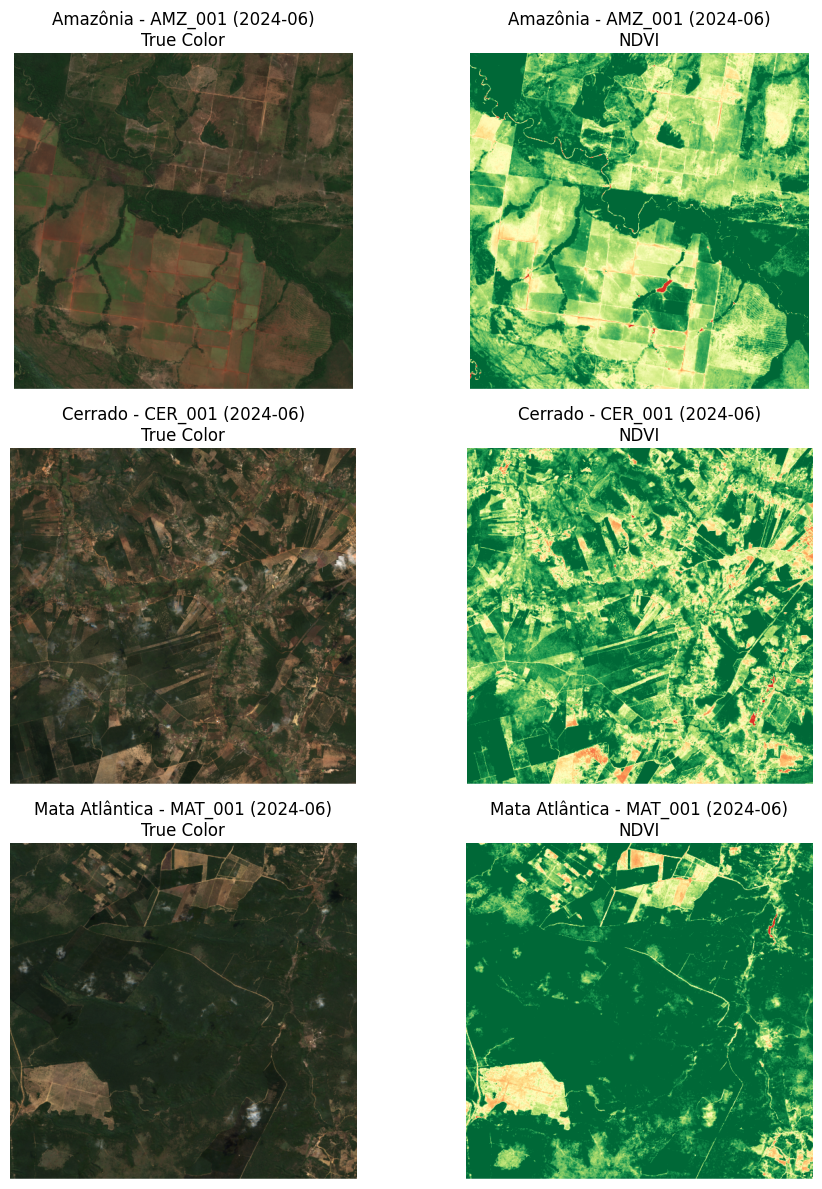


Exemplo salvo: /content/drive/MyDrive/deepveg-gee360/outputs/figures/s2_composites/examples_by_biome.png

CELULA 15 CONCLUIDA


   NOTEBOOK TRILHA 03 (deepveg-gee360) CONCLUIDO!

   Dataset: 360 pontos (120 por bioma)
   Biomas: Amazônia, Cerrado, Mata Atlântica
   Periodo: 2019-01-01 a 2024-12-31
   
   Arquitetura TCN:
   - Blocos: 4
   - Canais: 32
   - Campo receptivo: 31 timesteps
   
   Resultados salvos em:
   /content/drive/MyDrive/deepveg-gee360/outputs/



In [23]:
# ===========================================================================
# CÉLULA 15: COMPOSIÇÕES SENTINEL-2 (OPCIONAL)
# ===========================================================================
# Célula 15: Composições Sentinel-2
"""
CELULA 15: COMPOSICOES SENTINEL-2 (OPCIONAL)
Gera imagens True-Color e NDVI colorido por ponto e mes.
Para 360 pontos, gera apenas uma amostra representativa.
"""

import os
import time
import requests
import ee
import numpy as np
from PIL import Image
from io import BytesIO
import pandas as pd

# ---------------------------------------------------------------------------
# CONFIGURACOES
# ---------------------------------------------------------------------------
S2_COLLECTION = DATA.GEE_ASSETS["sentinel"]

# Meses a renderizar
PLOT_MONTHS = ["2024-06", "2024-09", "2024-12"]

# Buffer e dimensoes
BUFFER_M = 5000
IMG_DIMS = 512

# Visualizacao
VIS_TRUE = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000, "gamma": 1.2}
NDVI_PALETTE = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf',
                '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']

OUT_DIR = f"{BASE}/outputs/figures/s2_composites"
os.makedirs(OUT_DIR, exist_ok=True)

# Para 360 pontos, processar apenas amostra (5 por bioma)
MAX_POINTS_PER_BIOME = 5

# ---------------------------------------------------------------------------
# FUNCOES
# ---------------------------------------------------------------------------
def s2_mask_clouds(image):
    qa = image.select('QA60')
    cloud = qa.bitwiseAnd(1 << 10).neq(0)
    cirrus = qa.bitwiseAnd(1 << 11).neq(0)
    mask = cloud.Or(cirrus).Not()
    return image.updateMask(mask)


def get_s2_composite(aoi, y, m):
    start = ee.Date.fromYMD(y, m, 1)
    end = start.advance(1, 'month')

    ic = (
        ee.ImageCollection(S2_COLLECTION)
        .filterDate(start, end)
        .filterBounds(aoi)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 50))
        .map(s2_mask_clouds)
    )

    count = ic.size().getInfo()
    if count == 0:
        return None, 0

    composite = ic.median().clip(aoi)
    return composite, count


def download_thumbnail(url, filepath):
    try:
        response = requests.get(url, timeout=60)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            img.save(filepath)
            return True
        return False
    except:
        return False


def bbox_from_point(lon, lat, buffer_m):
    point = ee.Geometry.Point([lon, lat])
    return point.buffer(buffer_m).bounds()


def ym_from_str(s):
    y, m = s.split("-")
    return int(y), int(m)


# ---------------------------------------------------------------------------
# SELECIONAR AMOSTRA DE PONTOS
# ---------------------------------------------------------------------------
df_points_sample = pd.DataFrame(POINTS)
points_sample = []

for biome in df_points_sample['biome'].unique():
    biome_points = df_points_sample[df_points_sample['biome'] == biome].head(MAX_POINTS_PER_BIOME)
    points_sample.extend(biome_points.to_dict('records'))

print("=" * 60)
print("GERANDO COMPOSICOES SENTINEL-2 (AMOSTRA)")
print("=" * 60)
print(f"  Colecao: {S2_COLLECTION}")
print(f"  Meses: {PLOT_MONTHS}")
print(f"  Pontos: {len(points_sample)} (amostra de {len(POINTS)} total)")
print(f"  Max por bioma: {MAX_POINTS_PER_BIOME}")

t0 = time.time()
ok, skipped, errors = 0, 0, 0
results = []

for p in points_sample:
    biome = p["biome"]
    site = p["name"]
    lat = p["lat"]
    lon = p["lon"]

    site_dir = f"{OUT_DIR}/{biome}/{site}"
    os.makedirs(site_dir, exist_ok=True)

    region = bbox_from_point(lon, lat, BUFFER_M)

    for ym in PLOT_MONTHS:
        y, m = ym_from_str(ym)

        try:
            comp, count = get_s2_composite(region, y, m)

            if comp is None or count == 0:
                print(f"[{biome}/{site} {ym}] sem imagens validas")
                skipped += 1
                continue

            # True Color
            out_true = f"{site_dir}/{site}_{ym}_truecolor.png"
            if not os.path.exists(out_true):
                url_true = comp.visualize(**VIS_TRUE).getThumbURL({
                    'region': region,
                    'dimensions': IMG_DIMS,
                    'format': 'png'
                })
                if download_thumbnail(url_true, out_true):
                    print(f"[{biome}/{site} {ym}] TrueColor OK ({count} imgs)")
                    ok += 1
                    results.append({"biome": biome, "site": site, "month": ym, "type": "truecolor", "path": out_true})
                else:
                    errors += 1
            else:
                ok += 1
                results.append({"biome": biome, "site": site, "month": ym, "type": "truecolor", "path": out_true})

            # NDVI
            out_ndvi = f"{site_dir}/{site}_{ym}_ndvi.png"
            if not os.path.exists(out_ndvi):
                ndvi = comp.normalizedDifference(['B8', 'B4']).rename('NDVI')
                ndvi_vis = ndvi.visualize(min=0.0, max=0.8, palette=NDVI_PALETTE)
                url_ndvi = ndvi_vis.getThumbURL({
                    'region': region,
                    'dimensions': IMG_DIMS,
                    'format': 'png'
                })
                if download_thumbnail(url_ndvi, out_ndvi):
                    print(f"[{biome}/{site} {ym}] NDVI OK")
                    ok += 1
                    results.append({"biome": biome, "site": site, "month": ym, "type": "ndvi", "path": out_ndvi})
                else:
                    errors += 1
            else:
                ok += 1
                results.append({"biome": biome, "site": site, "month": ym, "type": "ndvi", "path": out_ndvi})

        except Exception as e:
            print(f"[ERRO] {biome}/{site} {ym}: {str(e)[:50]}")
            errors += 1

dt = time.time() - t0

# ---------------------------------------------------------------------------
# RESUMO
# ---------------------------------------------------------------------------
print("\n" + "=" * 60)
print("RESUMO")
print("=" * 60)
print(f"  Imagens geradas: {ok}")
print(f"  Puladas: {skipped}")
print(f"  Erros: {errors}")
print(f"  Tempo: {dt:.1f}s")
print(f"  Saida: {OUT_DIR}")

# Visualizacao de exemplo
if results:
    import matplotlib.pyplot as plt

    summary_df = pd.DataFrame(results)
    biomes_with_images = summary_df["biome"].unique()[:3]

    fig, axes = plt.subplots(len(biomes_with_images), 2, figsize=(10, 4*len(biomes_with_images)))
    if len(biomes_with_images) == 1:
        axes = axes.reshape(1, -1)

    for i, biome in enumerate(biomes_with_images):
        biome_df = summary_df[summary_df["biome"] == biome]

        tc_rows = biome_df[biome_df["type"] == "truecolor"]
        if len(tc_rows) > 0:
            tc_row = tc_rows.iloc[0]
            if os.path.exists(tc_row["path"]):
                img_tc = Image.open(tc_row["path"])
                axes[i, 0].imshow(img_tc)
                axes[i, 0].set_title(f"{biome} - {tc_row['site']} ({tc_row['month']})\nTrue Color")
        axes[i, 0].axis('off')

        ndvi_rows = biome_df[biome_df["type"] == "ndvi"]
        if len(ndvi_rows) > 0:
            ndvi_row = ndvi_rows.iloc[0]
            if os.path.exists(ndvi_row["path"]):
                img_ndvi = Image.open(ndvi_row["path"])
                axes[i, 1].imshow(img_ndvi)
                axes[i, 1].set_title(f"{biome} - {ndvi_row['site']} ({ndvi_row['month']})\nNDVI")
        axes[i, 1].axis('off')

    plt.tight_layout()
    example_path = f"{OUT_DIR}/examples_by_biome.png"
    plt.savefig(example_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nExemplo salvo: {example_path}")

print("\n" + "=" * 60)
print("CELULA 15 CONCLUIDA")
print("=" * 60)


# ===========================================================================
# FIM DO NOTEBOOK - TRILHA 03 (360 PONTOS)
# ===========================================================================
print("\n")
print("=" * 70)
print("   NOTEBOOK TRILHA 03 (deepveg-gee360) CONCLUIDO!")
print("=" * 70)
print(f"""
   Dataset: {DATA.N_TOTAL_POINTS} pontos ({DATA.N_POINTS_PER_BIOME} por bioma)
   Biomas: {', '.join(DATA.BIOMES)}
   Periodo: {DATA.START_DATE} a {DATA.END_DATE}

   Arquitetura TCN:
   - Blocos: {MODEL.N_BLOCKS}
   - Canais: {MODEL.NUM_CHANNELS}
   - Campo receptivo: {MODEL.RECEPTIVE_FIELD} timesteps

   Resultados salvos em:
   {BASE}/outputs/
""")
print("=" * 70)